In [1]:
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers,initializers,applications
import numpy as np
import sys
sys.path.append("..") # 为了导入上层目录的d2lzh_tensorflow
import matplotlib.pyplot as plt
import d2lzh_tensorflow2 as d2lzh

In [2]:
from PIL import Image,ImageFilter,ImageDraw,ImageEnhance
import  random
from tqdm import tqdm
import numpy as np
import sys
from tifffile import TIFF
import tifffile as tiff
import os
import json
import matplotlib.pyplot as plt
%matplotlib inline
from tensorflow.keras.utils import plot_model
from tensorflow.keras import layers, Model, Sequential

In [3]:
from tensorflow.keras.preprocessing.image import img_to_array
import utils
import math
import cv2
from keras import backend as K
import keras.models as KM
import keras.layers as KL
import keras.engine as KE
import keras.backend as KB
import tensorflow_addons as tfa
from tensorflow.keras.models import Model
from tensorflow.keras.layers import *
from tensorflow import nn
root = 'F:\train_data\Semantic_segmentation\Inria\srcs\srcs_train'

In [4]:
train_parameters = {
    "input_size": [3, 256, 256],                           #输入图片的shape
    "class_dim": -1,                                     #分类数
    "src_path":'F:/train_data/Semantic_segmentation/Inria',       #原始数据集路径
    "target_path":'F:/train_data/Semantic_segmentation/Inria/srcs/',        #要解压的路径 
    "train_list_path": "F:/train_data/Semantic_segmentation/Inria/tifs/train_data.txt",              #train_data.txt路径
    "eval_list_path": "F:/train_data/Semantic_segmentation/Inria/tifs/val_data.txt",                  #eval_data.txt路径
    "label_dict":{},                                    #标签字典
    "readme_path": "F:/train_data/Semantic_segmentation/Inria/tifs/readme.json",   #readme.json路径
    "num_epochs": 10,                                    #训练轮数
    "train_batch_size":64,                             #批次的大小
    "learning_strategy": {                              #优化函数相关的配置
        "lr": 0.01                                     #超参数学习率
    } 
}

In [5]:
def get_data_list(target_path,train_list_path,eval_list_path):
    '''
    生成数据列表
    '''
    #存放所有类别的信息
    class_detail = []
    #获取所有类别保存的文件夹名称
    data_list_path=target_path
    class_dirs = os.listdir(data_list_path)
    if '__MACOSX' in class_dirs:
        class_dirs.remove('__MACOSX')
    # #总的图像数量
    all_class_images = 0
    # #存放类别数目
    class_dim = 0
    # #存储要写进eval.txt和train.txt中的内容
    trainer_list=[]
    eval_list=[]
    #读取每个类别
    for class_dir in class_dirs:
        if class_dir != ".DS_Store":
            class_dim += 1
            #每个类别的信息
            class_detail_list = {}
            eval_sum = 0
            trainer_sum = 0
            #统计每个类别有多少张图片
            class_sum = 0
            #获取类别路径 
            path = os.path.join(data_list_path,class_dir)
            # print(path)
            # 获取所有图片
            
            img_paths = os.listdir(path)
            for img_path in img_paths:                                   # 遍历文件夹下的每个图片
                if img_path =='.DS_Store':
                    continue
#                 name_path = os.path.join(path,img_path)                   # 每张图片的路径
                name_path = img_path
                print(name_path)
                if class_sum % 15 == 0:                                   # 每15张图片取一个做验证数据
                    eval_sum += 1                                         # eval_sum为测试数据的数目
                    eval_list.append(name_path + "\n")
                else:
                    trainer_sum += 1                                      #trainer_sum测试数据的数目
                    trainer_list.append(name_path + "\n")#trainer_sum测试数据的数目
                class_sum += 1                                           #每类图片的数目
                all_class_images += 1                                    #所有类图片的数目
            
            # 说明的json文件的class_detail数据
            class_detail_list['class_name'] = class_dir             #类别名称
            class_detail_list['class_eval_images'] = eval_sum       #该类数据的测试集数目
            class_detail_list['class_trainer_images'] = trainer_sum #该类数据的训练集数目
            class_detail.append(class_detail_list)  
            
    #初始化分类数
    train_parameters['class_dim'] = class_dim
    #print(train_parameters)
    #乱序  
    random.shuffle(eval_list)
    with open(eval_list_path, 'a') as f:
        for eval_image in eval_list:
            f.write(eval_image) 
    #乱序        
    random.shuffle(trainer_list) 
    with open(train_list_path, 'a') as f2:
        for train_image in trainer_list:
            f2.write(train_image) 

    # 说明的json文件信息
    readjson = {}
    readjson['all_class_name'] = data_list_path                  #文件父目录
    readjson['all_class_images'] = all_class_images
    readjson['class_detail'] = class_detail
    jsons = json.dumps(readjson, sort_keys=True, indent=4, separators=(',', ': '))
    with open(train_parameters['readme_path'],'w') as f:
        f.write(jsons)
    print ('生成数据列表完成！')

In [6]:
'''
参数初始化
'''
src_path=train_parameters['src_path']
target_path=train_parameters['target_path']
train_list_path=train_parameters['train_list_path']
eval_list_path=train_parameters['eval_list_path']
batch_size=train_parameters['train_batch_size']

#每次生成数据列表前，首先清空train.txt和eval.txt
with open(train_list_path, 'w') as f: 
    f.seek(0)
    f.truncate() 
with open(eval_list_path, 'w') as f: 
    f.seek(0)
    f.truncate() 
#生成数据列表   
get_data_list(target_path,train_list_path,eval_list_path)

0.tif
1.tif
10.tif
100.tif
1000.tif
10000.tif
10001.tif
10002.tif
10003.tif
10004.tif
10005.tif
10006.tif
10007.tif
10008.tif
10009.tif
1001.tif
10010.tif
10011.tif
10012.tif
10013.tif
10014.tif
10015.tif
10016.tif
10017.tif
10018.tif
10019.tif
1002.tif
10020.tif
10021.tif
10022.tif
10023.tif
10024.tif
10025.tif
10026.tif
10027.tif
10028.tif
10029.tif
1003.tif
10030.tif
10031.tif
10032.tif
10033.tif
10034.tif
10035.tif
10036.tif
10037.tif
10038.tif
10039.tif
1004.tif
10040.tif
10041.tif
10042.tif
10043.tif
10044.tif
10045.tif
10046.tif
10047.tif
10048.tif
10049.tif
1005.tif
10050.tif
10051.tif
10052.tif
10053.tif
10054.tif
10055.tif
10056.tif
10057.tif
10058.tif
10059.tif
1006.tif
10060.tif
10061.tif
10062.tif
10063.tif
10064.tif
10065.tif
10066.tif
10067.tif
10068.tif
10069.tif
1007.tif
10070.tif
10071.tif
10072.tif
10073.tif
10074.tif
10075.tif
10076.tif
10077.tif
10078.tif
10079.tif
1008.tif
10080.tif
10081.tif
10082.tif
10083.tif
10084.tif
10085.tif
10086.tif
10087.tif
10088.tif
10

12828.tif
12829.tif
1283.tif
12830.tif
12831.tif
12832.tif
12833.tif
12834.tif
12835.tif
12836.tif
12837.tif
12838.tif
12839.tif
1284.tif
12840.tif
12841.tif
12842.tif
12843.tif
12844.tif
12845.tif
12846.tif
12847.tif
12848.tif
12849.tif
1285.tif
12850.tif
12851.tif
12852.tif
12853.tif
12854.tif
12855.tif
12856.tif
12857.tif
12858.tif
12859.tif
1286.tif
12860.tif
12861.tif
12862.tif
12863.tif
12864.tif
12865.tif
12866.tif
12867.tif
12868.tif
12869.tif
1287.tif
12870.tif
12871.tif
12872.tif
12873.tif
12874.tif
12875.tif
12876.tif
12877.tif
12878.tif
12879.tif
1288.tif
12880.tif
12881.tif
12882.tif
12883.tif
12884.tif
12885.tif
12886.tif
12887.tif
12888.tif
12889.tif
1289.tif
12890.tif
12891.tif
12892.tif
12893.tif
12894.tif
12895.tif
12896.tif
12897.tif
12898.tif
12899.tif
129.tif
1290.tif
12900.tif
12901.tif
12902.tif
12903.tif
12904.tif
12905.tif
12906.tif
12907.tif
12908.tif
12909.tif
1291.tif
12910.tif
12911.tif
12912.tif
12913.tif
12914.tif
12915.tif
12916.tif
12917.tif
12918.tif
1

14714.tif
14715.tif
14716.tif
14717.tif
14718.tif
14719.tif
1472.tif
14720.tif
14721.tif
14722.tif
14723.tif
14724.tif
14725.tif
14726.tif
14727.tif
14728.tif
14729.tif
1473.tif
14730.tif
14731.tif
14732.tif
14733.tif
14734.tif
14735.tif
14736.tif
14737.tif
14738.tif
14739.tif
1474.tif
14740.tif
14741.tif
14742.tif
14743.tif
14744.tif
14745.tif
14746.tif
14747.tif
14748.tif
14749.tif
1475.tif
14750.tif
14751.tif
14752.tif
14753.tif
14754.tif
14755.tif
14756.tif
14757.tif
14758.tif
14759.tif
1476.tif
14760.tif
14761.tif
14762.tif
14763.tif
14764.tif
14765.tif
14766.tif
14767.tif
14768.tif
14769.tif
1477.tif
14770.tif
14771.tif
14772.tif
14773.tif
14774.tif
14775.tif
14776.tif
14777.tif
14778.tif
14779.tif
1478.tif
14780.tif
14781.tif
14782.tif
14783.tif
14784.tif
14785.tif
14786.tif
14787.tif
14788.tif
14789.tif
1479.tif
14790.tif
14791.tif
14792.tif
14793.tif
14794.tif
14795.tif
14796.tif
14797.tif
14798.tif
14799.tif
148.tif
1480.tif
14800.tif
14801.tif
14802.tif
14803.tif
14804.tif
1

17507.tif
17508.tif
17509.tif
1751.tif
17510.tif
17511.tif
17512.tif
17513.tif
17514.tif
17515.tif
17516.tif
17517.tif
17518.tif
17519.tif
1752.tif
17520.tif
17521.tif
17522.tif
17523.tif
17524.tif
17525.tif
17526.tif
17527.tif
17528.tif
17529.tif
1753.tif
17530.tif
17531.tif
17532.tif
17533.tif
17534.tif
17535.tif
17536.tif
17537.tif
17538.tif
17539.tif
1754.tif
17540.tif
17541.tif
17542.tif
17543.tif
17544.tif
17545.tif
17546.tif
17547.tif
17548.tif
17549.tif
1755.tif
17550.tif
17551.tif
17552.tif
17553.tif
17554.tif
17555.tif
17556.tif
17557.tif
17558.tif
17559.tif
1756.tif
17560.tif
17561.tif
17562.tif
17563.tif
17564.tif
17565.tif
17566.tif
17567.tif
17568.tif
17569.tif
1757.tif
17570.tif
17571.tif
17572.tif
17573.tif
17574.tif
17575.tif
17576.tif
17577.tif
17578.tif
17579.tif
1758.tif
17580.tif
17581.tif
17582.tif
17583.tif
17584.tif
17585.tif
17586.tif
17587.tif
17588.tif
17589.tif
1759.tif
17590.tif
17591.tif
17592.tif
17593.tif
17594.tif
17595.tif
17596.tif
17597.tif
17598.tif

20311.tif
20312.tif
20313.tif
20314.tif
20315.tif
20316.tif
20317.tif
20318.tif
20319.tif
2032.tif
20320.tif
20321.tif
20322.tif
20323.tif
20324.tif
20325.tif
20326.tif
20327.tif
20328.tif
20329.tif
2033.tif
20330.tif
20331.tif
20332.tif
20333.tif
20334.tif
20335.tif
20336.tif
20337.tif
20338.tif
20339.tif
2034.tif
20340.tif
20341.tif
20342.tif
20343.tif
20344.tif
20345.tif
20346.tif
20347.tif
20348.tif
20349.tif
2035.tif
20350.tif
20351.tif
20352.tif
20353.tif
20354.tif
20355.tif
20356.tif
20357.tif
20358.tif
20359.tif
2036.tif
20360.tif
20361.tif
20362.tif
20363.tif
20364.tif
20365.tif
20366.tif
20367.tif
20368.tif
20369.tif
2037.tif
20370.tif
20371.tif
20372.tif
20373.tif
20374.tif
20375.tif
20376.tif
20377.tif
20378.tif
20379.tif
2038.tif
20380.tif
20381.tif
20382.tif
20383.tif
20384.tif
20385.tif
20386.tif
20387.tif
20388.tif
20389.tif
2039.tif
20390.tif
20391.tif
20392.tif
20393.tif
20394.tif
20395.tif
20396.tif
20397.tif
20398.tif
20399.tif
204.tif
2040.tif
20400.tif
20401.tif
2

23254.tif
23255.tif
23256.tif
23257.tif
23258.tif
23259.tif
2326.tif
23260.tif
23261.tif
23262.tif
23263.tif
23264.tif
23265.tif
23266.tif
23267.tif
23268.tif
23269.tif
2327.tif
23270.tif
23271.tif
23272.tif
23273.tif
23274.tif
23275.tif
23276.tif
23277.tif
23278.tif
23279.tif
2328.tif
23280.tif
23281.tif
23282.tif
23283.tif
23284.tif
23285.tif
23286.tif
23287.tif
23288.tif
23289.tif
2329.tif
23290.tif
23291.tif
23292.tif
23293.tif
23294.tif
23295.tif
23296.tif
23297.tif
23298.tif
23299.tif
233.tif
2330.tif
23300.tif
23301.tif
23302.tif
23303.tif
23304.tif
23305.tif
23306.tif
23307.tif
23308.tif
23309.tif
2331.tif
23310.tif
23311.tif
23312.tif
23313.tif
23314.tif
23315.tif
23316.tif
23317.tif
23318.tif
23319.tif
2332.tif
23320.tif
23321.tif
23322.tif
23323.tif
23324.tif
23325.tif
23326.tif
23327.tif
23328.tif
23329.tif
2333.tif
23330.tif
23331.tif
23332.tif
23333.tif
23334.tif
23335.tif
23336.tif
23337.tif
23338.tif
23339.tif
2334.tif
23340.tif
23341.tif
23342.tif
23343.tif
23344.tif
2

26318.tif
26319.tif
2632.tif
26320.tif
26321.tif
26322.tif
26323.tif
26324.tif
26325.tif
26326.tif
26327.tif
26328.tif
26329.tif
2633.tif
26330.tif
26331.tif
26332.tif
26333.tif
26334.tif
26335.tif
26336.tif
26337.tif
26338.tif
26339.tif
2634.tif
26340.tif
26341.tif
26342.tif
26343.tif
26344.tif
26345.tif
26346.tif
26347.tif
26348.tif
26349.tif
2635.tif
26350.tif
26351.tif
26352.tif
26353.tif
26354.tif
26355.tif
26356.tif
26357.tif
26358.tif
26359.tif
2636.tif
26360.tif
26361.tif
26362.tif
26363.tif
26364.tif
26365.tif
26366.tif
26367.tif
26368.tif
26369.tif
2637.tif
26370.tif
26371.tif
26372.tif
26373.tif
26374.tif
26375.tif
26376.tif
26377.tif
26378.tif
26379.tif
2638.tif
26380.tif
26381.tif
26382.tif
26383.tif
26384.tif
26385.tif
26386.tif
26387.tif
26388.tif
26389.tif
2639.tif
26390.tif
26391.tif
26392.tif
26393.tif
26394.tif
26395.tif
26396.tif
26397.tif
26398.tif
26399.tif
264.tif
2640.tif
26400.tif
26401.tif
26402.tif
26403.tif
26404.tif
26405.tif
26406.tif
26407.tif
26408.tif
2

29311.tif
29312.tif
29313.tif
29314.tif
29315.tif
29316.tif
29317.tif
29318.tif
29319.tif
2932.tif
29320.tif
29321.tif
29322.tif
29323.tif
29324.tif
29325.tif
29326.tif
29327.tif
29328.tif
29329.tif
2933.tif
29330.tif
29331.tif
29332.tif
29333.tif
29334.tif
29335.tif
29336.tif
29337.tif
29338.tif
29339.tif
2934.tif
29340.tif
29341.tif
29342.tif
29343.tif
29344.tif
29345.tif
29346.tif
29347.tif
29348.tif
29349.tif
2935.tif
29350.tif
29351.tif
29352.tif
29353.tif
29354.tif
29355.tif
29356.tif
29357.tif
29358.tif
29359.tif
2936.tif
29360.tif
29361.tif
29362.tif
29363.tif
29364.tif
29365.tif
29366.tif
29367.tif
29368.tif
29369.tif
2937.tif
29370.tif
29371.tif
29372.tif
29373.tif
29374.tif
29375.tif
29376.tif
29377.tif
29378.tif
29379.tif
2938.tif
29380.tif
29381.tif
29382.tif
29383.tif
29384.tif
29385.tif
29386.tif
29387.tif
29388.tif
29389.tif
2939.tif
29390.tif
29391.tif
29392.tif
29393.tif
29394.tif
29395.tif
29396.tif
29397.tif
29398.tif
29399.tif
294.tif
2940.tif
29400.tif
29401.tif
2

4328.tif
4329.tif
433.tif
4330.tif
4331.tif
4332.tif
4333.tif
4334.tif
4335.tif
4336.tif
4337.tif
4338.tif
4339.tif
434.tif
4340.tif
4341.tif
4342.tif
4343.tif
4344.tif
4345.tif
4346.tif
4347.tif
4348.tif
4349.tif
435.tif
4350.tif
4351.tif
4352.tif
4353.tif
4354.tif
4355.tif
4356.tif
4357.tif
4358.tif
4359.tif
436.tif
4360.tif
4361.tif
4362.tif
4363.tif
4364.tif
4365.tif
4366.tif
4367.tif
4368.tif
4369.tif
437.tif
4370.tif
4371.tif
4372.tif
4373.tif
4374.tif
4375.tif
4376.tif
4377.tif
4378.tif
4379.tif
438.tif
4380.tif
4381.tif
4382.tif
4383.tif
4384.tif
4385.tif
4386.tif
4387.tif
4388.tif
4389.tif
439.tif
4390.tif
4391.tif
4392.tif
4393.tif
4394.tif
4395.tif
4396.tif
4397.tif
4398.tif
4399.tif
44.tif
440.tif
4400.tif
4401.tif
4402.tif
4403.tif
4404.tif
4405.tif
4406.tif
4407.tif
4408.tif
4409.tif
441.tif
4410.tif
4411.tif
4412.tif
4413.tif
4414.tif
4415.tif
4416.tif
4417.tif
4418.tif
4419.tif
442.tif
4420.tif
4421.tif
4422.tif
4423.tif
4424.tif
4425.tif
4426.tif
4427.tif
4428.tif
4429

7309.tif
731.tif
7310.tif
7311.tif
7312.tif
7313.tif
7314.tif
7315.tif
7316.tif
7317.tif
7318.tif
7319.tif
732.tif
7320.tif
7321.tif
7322.tif
7323.tif
7324.tif
7325.tif
7326.tif
7327.tif
7328.tif
7329.tif
733.tif
7330.tif
7331.tif
7332.tif
7333.tif
7334.tif
7335.tif
7336.tif
7337.tif
7338.tif
7339.tif
734.tif
7340.tif
7341.tif
7342.tif
7343.tif
7344.tif
7345.tif
7346.tif
7347.tif
7348.tif
7349.tif
735.tif
7350.tif
7351.tif
7352.tif
7353.tif
7354.tif
7355.tif
7356.tif
7357.tif
7358.tif
7359.tif
736.tif
7360.tif
7361.tif
7362.tif
7363.tif
7364.tif
7365.tif
7366.tif
7367.tif
7368.tif
7369.tif
737.tif
7370.tif
7371.tif
7372.tif
7373.tif
7374.tif
7375.tif
7376.tif
7377.tif
7378.tif
7379.tif
738.tif
7380.tif
7381.tif
7382.tif
7383.tif
7384.tif
7385.tif
7386.tif
7387.tif
7388.tif
7389.tif
739.tif
7390.tif
7391.tif
7392.tif
7393.tif
7394.tif
7395.tif
7396.tif
7397.tif
7398.tif
7399.tif
74.tif
740.tif
7400.tif
7401.tif
7402.tif
7403.tif
7404.tif
7405.tif
7406.tif
7407.tif
7408.tif
7409.tif
741.

生成数据列表完成！


In [7]:
isprs_dir = root='F:/train_data/Semantic_segmentation/Inria'

In [8]:
def rand_crop(feature, label, height, width):
    """
    Random crop feature (tf image) and label (tf image).
    先将channel合并，剪裁之后再分开
    """
    combined = tf.concat([feature, label], axis=2)
    last_label_dim = tf.shape(label)[-1]
    last_feature_dim = tf.shape(feature)[-1]
    combined_crop = tf.image.random_crop(combined,
                        size=tf.concat([(height, width), [last_label_dim + last_feature_dim]],axis=0))
    return combined_crop[:, :, :last_feature_dim], combined_crop[:, :, last_feature_dim:]

In [ ]:
'''
读入TIFF格式的图像
'''
def read_images(is_train=True,root=isprs_dir):
    txt_fname = '%s//tifs//%s' % (
        root, 'train_data.txt' if is_train else 'val_data.txt')
    
    with open(txt_fname, 'r') as f:
        image_names = f.read().split()
        
    images,labels= [None] * len(image_names),[None] * len(image_names)
    
    for i, fname in enumerate(image_names):
        
        img_name = '%s\\srcs\\srcs_train\\%s' % (root, fname)
        lbl_name = '%s\\labels\\labels_train\\%s' % (root, fname)
        
        images[i] = cv2.imread(img_name)
        images[i] = cv2.cvtColor(images[i],cv2.COLOR_BGR2RGB)
#         labels[i] = cv2.imread(lbl_name,cv2.IMREAD_GRAYSCALE)
        labels[i] = cv2.imread(lbl_name)
        labels[i] = cv2.cvtColor(labels[i],cv2.COLOR_BGR2RGB)
        
        #if i == 1:
            #print(img_name)
            #print(lbl_name)
#     print('images',images)
    
    return images, labels

In [10]:
# train_images,train_labels = read_images(root)
# print('image shape:', train_images[0].shape)
# print('label shape:', train_labels[0].shape)

In [11]:
# '''
# 使用Matplotlib显示5幅图像及其对应的标签
# 目的是校验数据读取是否正确
# '''
# plt.figure(figsize=(20,10))
# rows = 2
# cols = 5
# for i, image in enumerate(train_images[:cols]):
#     plt.subplot(rows, cols, i+1)
#     plt.imshow(image)
    
# for i, image in enumerate(train_labels[:cols]):
#     plt.subplot(rows, cols, cols+i+1)
#     plt.imshow(image)

In [12]:
COLORMAP = [
    [0, 0, 0],
    [255, 255, 255],
]

COLORCLASS = [
    'Background',
    'Building',
]

print('colormap size:', len(COLORMAP))
print('colorclass size:', len(COLORCLASS))

colormap size: 6
colorclass size: 6


In [13]:
#第一张样本图像索引
colormap2label = np.zeros(256 ** 3)
for i, color_map in enumerate(COLORMAP):
#     print("dddd", (color_map[0] * 256 + color_map[1]) * 256 + color_map[2])
#     print(i)
    colormap2label[(color_map[0] * 256 + color_map[1]) * 256 + color_map[2]] = i
    #i = int(colormap2label[(color_map[0] * 256 + color_map[1]) * 256 + color_map[2]])
colormap2label = tf.convert_to_tensor(colormap2label)
print(colormap2label)

tf.Tensor([0. 0. 0. ... 0. 0. 2.], shape=(16777216,), dtype=float64)


In [14]:
def label_indices(colormap,colormap2label):
    colormap = tf.cast(colormap, dtype=tf.int32)
    idx = ((colormap[:, :, 0] * 256 + colormap[:, :, 1]) * 256 + colormap[:, :, 2])
    #print(((colormap[:, :, 0] * 256 + colormap[:, :, 1]) * 256 + colormap[:, :, 2]).astype(np.int))
    return tf.gather_nd(colormap2label, tf.expand_dims(idx, -1))

In [15]:
# y = label_indices(train_labels[0],colormap2label)
# y[105:115, 130:140]

In [16]:
def IsprsDataset(is_train, crop_size, isprs_dir, colormap2label):
    """
    crop_size: (h, w)
    """
    features, labels = read_images(root=isprs_dir, 
                        is_train=is_train)
    def _filter(imgs, crop_size):
        return [img for img in imgs if (
            img.shape[0] >= crop_size[0] and
            img.shape[1] >= crop_size[1])]
    
    def _crop(features, labels):
        features_crop = []
        labels_crop = []
        for feature, label in zip(features, labels):
            feature, label = rand_crop(feature, label, 
                            height=crop_size[0],
                            width=crop_size[1])
            features_crop.append(feature)
            labels_crop.append(label)
        return features_crop, labels_crop
    
    def _normalize(feature, label):
#         rgb_mean = np.array([0.485, 0.456, 0.406])
#         rgb_std = np.array([0.229, 0.224, 0.225])
        
        label = label_indices(label, colormap2label)
        feature = tf.cast(feature, tf.float32)
        feature = tf.divide(feature, 255.)
        # feature = tf.divide(tf.subtract(feature, rgb_mean), rgb_std)
        return feature, label

    features = _filter(features, crop_size)
    labels = _filter(labels, crop_size)
    features, labels = _crop(features, labels)

    print('read ' + str(len(features)) + ' valid examples')
    dataset = tf.data.Dataset.from_tensor_slices((features, labels))
    dataset = dataset.map(_normalize)
    return dataset

In [32]:
#读取数据集
crop_size = (256, 256)
colormap2label = np.zeros(256 ** 3, dtype=np.uint8)

for i, colormap in enumerate(COLORMAP):
    colormap2label[(colormap[0] * 256 + colormap[1]) * 256 + colormap[2]] = i

colormap2label = tf.convert_to_tensor(colormap2label)

Isprs_train = IsprsDataset(True, crop_size, isprs_dir, colormap2label)
Isprs_test = IsprsDataset(False, crop_size, isprs_dir, colormap2label)
batch_size = 32
Isprs_train = Isprs_train.shuffle(buffer_size=1024).batch(batch_size)
Isprs_test = Isprs_test.shuffle(buffer_size=1024).batch(batch_size)

read 29120 valid examples
read 2080 valid examples


In [6]:
class Bottleneck(layers.Layer):
    """
    注意：原论文中，在虚线残差结构的主分支上，第一个1x1卷积层的步距是2，第二个3x3卷积层步距是1。
    但在pytorch官方实现过程中是第一个1x1卷积层的步距是1，第二个3x3卷积层步距是2，
    这么做的好处是能够在top1上提升大概0.5%的准确率。
    可参考Resnet v1.5 https://ngc.nvidia.com/catalog/model-scripts/nvidia:resnet_50_v1_5_for_pytorch
    """
    expansion = 4

    def __init__(self, out_channel, strides=1, downsample=None, **kwargs):
        super(Bottleneck, self).__init__(**kwargs)
        self.conv1 = layers.Conv2D(out_channel, kernel_size=1, use_bias=False, name="conv1")
        self.bn1 = layers.BatchNormalization(momentum=0.9, epsilon=1e-5, name="conv1/BatchNorm")
        # -----------------------------------------
        self.conv2 = layers.Conv2D(out_channel, kernel_size=3, use_bias=False,
                                   strides=strides, padding="SAME", name="conv2")
        self.bn2 = layers.BatchNormalization(momentum=0.9, epsilon=1e-5, name="conv2/BatchNorm")
        # -----------------------------------------
        self.conv3 = layers.Conv2D(out_channel * self.expansion, kernel_size=1, use_bias=False, name="conv3")
        self.bn3 = layers.BatchNormalization(momentum=0.9, epsilon=1e-5, name="conv3/BatchNorm")
        # -----------------------------------------
        self.relu = layers.ReLU()
        self.downsample = downsample
        self.add = layers.Add()

    def call(self, inputs, training=False):
        identity = inputs
        if self.downsample is not None:
            identity = self.downsample(inputs)

        x = self.conv1(inputs)
        x = self.bn1(x, training=training)
        x = self.relu(x)

        x = self.conv2(x)
        x = self.bn2(x, training=training)
        x = self.relu(x)

        x = self.conv3(x)
        x = self.bn3(x, training=training)

        x = self.add([x, identity])
        x = self.relu(x)

        return x

In [7]:
class BasicBlock(layers.Layer):
    expansion = 1

    def __init__(self, out_channel, strides=1, downsample=None, **kwargs):
        super(BasicBlock, self).__init__(**kwargs)
        self.conv1 = layers.Conv2D(out_channel, kernel_size=3, strides=strides,
                                   padding="SAME", use_bias=False)
        self.bn1 = layers.BatchNormalization(momentum=0.9, epsilon=1e-5)
        # -----------------------------------------
        self.conv2 = layers.Conv2D(out_channel, kernel_size=3, strides=1,
                                   padding="SAME", use_bias=False)
        self.bn2 = layers.BatchNormalization(momentum=0.9, epsilon=1e-5)
        # -----------------------------------------
        self.downsample = downsample
        self.relu = layers.ReLU()
        self.add = layers.Add()

    def call(self, inputs, training=False):
        identity = inputs
        if self.downsample is not None:
            identity = self.downsample(inputs)

        x = self.conv1(inputs)
        x = self.bn1(x, training=training)
        x = self.relu(x)

        x = self.conv2(x)
        x = self.bn2(x, training=training)

        x = self.add([identity, x])
        x = self.relu(x)

        return x

In [8]:
def _make_layer(block, in_channel, channel, block_num, name, strides=1):
    downsample = None
    if strides != 1 or in_channel != channel * block.expansion:
        downsample = Sequential([
            layers.Conv2D(channel * block.expansion, kernel_size=1, strides=strides,
                          use_bias=False, name="conv1"),
            layers.BatchNormalization(momentum=0.9, epsilon=1.001e-5, name="BatchNorm")
        ], name="shortcut")

    layers_list = []
    layers_list.append(block(channel, downsample=downsample, strides=strides, name="unit_1"))

    for index in range(1, block_num):
        layers_list.append(block(channel, name="unit_" + str(index + 1)))

    return Sequential(layers_list, name=name)

In [9]:
def _resnet(block, blocks_num, im_width=256, im_height=256, num_classes=2, include_top=True):
    # tensorflow中的tensor通道排序是NHWC
    # (None, 224, 224, 3)
    input_image = layers.Input(shape=(im_height, im_width, 3), dtype="float32")
    x = layers.Conv2D(filters=64, kernel_size=7, strides=2,
                      padding="SAME", use_bias=False, name="conv1")(input_image)
    x = layers.BatchNormalization(momentum=0.9, epsilon=1e-5, name="conv1/BatchNorm")(x)
    x = layers.ReLU()(x)
    x = layers.MaxPool2D(pool_size=3, strides=2, padding="SAME")(x)

    x = _make_layer(block, x.shape[-1], 64, blocks_num[0], name="block1")(x)
    x = _make_layer(block, x.shape[-1], 128, blocks_num[1], strides=2, name="block2")(x)
    x = _make_layer(block, x.shape[-1], 256, blocks_num[2], strides=1, name="block3")(x)
    x = _make_layer(block, x.shape[-1], 512, blocks_num[3], strides=1, name="block4")(x)

    if include_top:
        x = layers.GlobalAvgPool2D()(x)  # pool + flatten
        x = layers.Dense(num_classes, name="logits")(x)
#         predict = layers.Softmax()(x)
    else:
        predict = x

    model = Model(inputs=input_image, outputs=predict)

    return model

In [11]:
def resnet101(im_width=256, im_height=256, num_classes=2, include_top=True):
    return  _resnet(Bottleneck, [3, 4, 6, 3], im_width, im_height, num_classes, include_top)

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
model (Functional)           (None, 32, 32, 2048)      23564288  
Total params: 23,564,288
Trainable params: 23,511,168
Non-trainable params: 53,120
_________________________________________________________________


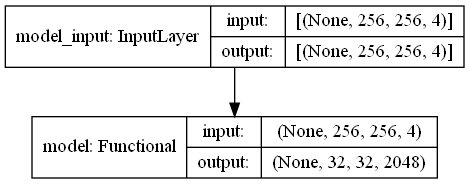

In [12]:
net = keras.Sequential()
pretrained_net=resnet101(num_classes=2,include_top=False)
net.add(pretrained_net)
net.summary()
net.compile(loss='sparse_categorical_crossentropy', optimizer=tf.keras.optimizers.Adam(learning_rate=0.001))
plot_model(net, to_file='resnet_hed_all_1.png', show_shapes=True)

In [14]:
from tensorflow.keras import Model, Input
from tensorflow.keras.layers import Dense, Flatten, Conv2D, MaxPooling2D, Dropout
from keras_flops import get_flops
flops = get_flops(net, batch_size=32)
print(f"FLOPS: {flops / 10 ** 9:.03} G")

FLOPS: 1.6e+03 G


In [33]:
net = keras.Sequential()
net.add(pretrained_net)

In [34]:
# x = np.random.uniform(size=(1, 256, 256, 4))
# x = tf.convert_to_tensor(x, dtype=tf.float32)
# net(x).shape

In [35]:
num_classes = 2
net.add(keras.layers.Conv2D(num_classes, kernel_size=1, activation='relu'))
# print(net(x).shape)
net.add(keras.layers.Conv2DTranspose(num_classes,
                kernel_size=32,
                padding='same',
                strides=8))
# print(net(x).shape)
net.add(keras.layers.Softmax(axis=-1))

In [36]:
# 目的就是找出 kernel_size*kernel_size 的框，框内的权值中间大外面小
# 然后每个通道只乘以自己的权值 就像上面图一样（kernel_size=2）
# 每个channel乘以对应的权值
# in_channels, out_channels 应该相同

def bilinear_kernel(in_channels, out_channels, kernel_size):
    factor = (kernel_size + 1) // 2
    if kernel_size % 2 == 1:
        center = factor - 1
    else:
        center = factor - 0.5
    og = np.ogrid[:kernel_size, :kernel_size]
    filt = (1-abs(og[0]-center)/factor) * (1-abs(og[1]-center)/factor)

#     kernel_size = (kernel_size, kernel_size, in_channels, out_channels)
    weight = np.zeros((kernel_size, kernel_size, in_channels, out_channels), dtype='float32')
    weight[:, :, range(in_channels), range(out_channels)] = filt.reshape((kernel_size,kernel_size,1))
    return weight

In [37]:
init_param = initializers.Constant(bilinear_kernel(3,3,4))
conv_trans = layers.Conv2DTranspose(3,
                kernel_size=4,
                padding='same',
                strides=2,
                kernel_initializer=init_param,)

In [38]:
net.layers

In [39]:
num_classes = 6
for i in range(-2, -1):
    bias_weight = net.layers[i].get_weights()[1]
    kernel_size = net.layers[i].get_config()['kernel_size'][0]
    net.layers[i].set_weights([bilinear_kernel(num_classes, num_classes, kernel_size), 
                bias_weight])

for i in range(4):
    print(net.layers[i].trainable)

True
True
True
True


In [40]:
# # 这个地方报错
# x1 = np.random.uniform(size=(1, 256, 256, 3))
# # x2 = np.random.uniform(size=(1, 256, 256, 5))
# x1 = tf.convert_to_tensor(x1, dtype=tf.float32)
# # x2 = tf.convert_to_tensor(x2, dtype=tf.float32)
# net(x1).shape

In [41]:
net.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=0.0004),
        loss=keras.losses.sparse_categorical_crossentropy,
        metrics=['accuracy'])
net.output

<KerasTensor: shape=(None, 256, 256, 6) dtype=float32 (created by layer 'softmax')>

In [42]:
history = net.fit(Isprs_train, epochs=100, validation_data=Isprs_test)

Epoch 1/350
910/910 [==============================] - 297s 306ms/step - loss: 1.5486 - accuracy: 0.5480 - val_loss: 1.1679 - val_accuracy: 0.5948
Epoch 2/350
910/910 [==============================] - 278s 305ms/step - loss: 1.1009 - accuracy: 0.6182 - val_loss: 1.1214 - val_accuracy: 0.5622
Epoch 3/350
910/910 [==============================] - 279s 306ms/step - loss: 0.9549 - accuracy: 0.6531 - val_loss: 0.9051 - val_accuracy: 0.6630
Epoch 4/350
910/910 [==============================] - 279s 306ms/step - loss: 0.8102 - accuracy: 0.7027 - val_loss: 0.7592 - val_accuracy: 0.7150
Epoch 5/350
910/910 [==============================] - 279s 306ms/step - loss: 0.7201 - accuracy: 0.7336 - val_loss: 0.8018 - val_accuracy: 0.7096
Epoch 6/350
910/910 [==============================] - 279s 306ms/step - loss: 0.6616 - accuracy: 0.7575 - val_loss: 0.6532 - val_accuracy: 0.7611
Epoch 7/350
910/910 [==============================] - 279s 306ms/step - loss: 0.6052 - accuracy: 0.7784 - val_loss: 0

910/910 [==============================] - 278s 305ms/step - loss: 0.0433 - accuracy: 0.9824 - val_loss: 0.3884 - val_accuracy: 0.9121
Epoch 112/350
910/910 [==============================] - 278s 305ms/step - loss: 0.0382 - accuracy: 0.9843 - val_loss: 0.3984 - val_accuracy: 0.9115
Epoch 113/350
910/910 [==============================] - 278s 305ms/step - loss: 0.0514 - accuracy: 0.9795 - val_loss: 0.3806 - val_accuracy: 0.9096
Epoch 114/350
910/910 [==============================] - 278s 305ms/step - loss: 0.0442 - accuracy: 0.9820 - val_loss: 0.4150 - val_accuracy: 0.9077
Epoch 115/350
910/910 [==============================] - 278s 305ms/step - loss: 0.0523 - accuracy: 0.9793 - val_loss: 0.3855 - val_accuracy: 0.9066
Epoch 116/350
910/910 [==============================] - 278s 306ms/step - loss: 0.0416 - accuracy: 0.9830 - val_loss: 0.3945 - val_accuracy: 0.9121
Epoch 117/350
910/910 [==============================] - 277s 304ms/step - loss: 0.0427 - accuracy: 0.9828 - val_loss: 0

910/910 [==============================] - 278s 305ms/step - loss: 0.0311 - accuracy: 0.9871 - val_loss: 0.4661 - val_accuracy: 0.9134
Epoch 167/350
910/910 [==============================] - 278s 305ms/step - loss: 0.0356 - accuracy: 0.9856 - val_loss: 0.4662 - val_accuracy: 0.9138
Epoch 168/350
910/910 [==============================] - 278s 306ms/step - loss: 0.0281 - accuracy: 0.9883 - val_loss: 0.4690 - val_accuracy: 0.9137
Epoch 169/350
910/910 [==============================] - 279s 306ms/step - loss: 0.0359 - accuracy: 0.9855 - val_loss: 0.4547 - val_accuracy: 0.9134
Epoch 170/350
910/910 [==============================] - 278s 306ms/step - loss: 0.0338 - accuracy: 0.9862 - val_loss: 0.4339 - val_accuracy: 0.9094
Epoch 171/350
910/910 [==============================] - 279s 306ms/step - loss: 0.0292 - accuracy: 0.9879 - val_loss: 0.4736 - val_accuracy: 0.9136
Epoch 172/350
910/910 [==============================] - 278s 305ms/step - loss: 0.0399 - accuracy: 0.9840 - val_loss: 0

910/910 [==============================] - 278s 305ms/step - loss: 0.0300 - accuracy: 0.9877 - val_loss: 0.4957 - val_accuracy: 0.9129
Epoch 222/350
910/910 [==============================] - 278s 305ms/step - loss: 0.0227 - accuracy: 0.9905 - val_loss: 0.5373 - val_accuracy: 0.9151
Epoch 223/350
910/910 [==============================] - 278s 305ms/step - loss: 0.0235 - accuracy: 0.9902 - val_loss: 0.5470 - val_accuracy: 0.9103
Epoch 224/350
910/910 [==============================] - 279s 306ms/step - loss: 0.0331 - accuracy: 0.9867 - val_loss: 0.4921 - val_accuracy: 0.9150
Epoch 225/350
910/910 [==============================] - 278s 306ms/step - loss: 0.0220 - accuracy: 0.9908 - val_loss: 0.5268 - val_accuracy: 0.9151
Epoch 226/350
910/910 [==============================] - 279s 306ms/step - loss: 0.0322 - accuracy: 0.9871 - val_loss: 0.4796 - val_accuracy: 0.9125
Epoch 227/350
910/910 [==============================] - 278s 305ms/step - loss: 0.0236 - accuracy: 0.9901 - val_loss: 0

910/910 [==============================] - 278s 305ms/step - loss: 0.0209 - accuracy: 0.9913 - val_loss: 0.5094 - val_accuracy: 0.9088
Epoch 277/350
910/910 [==============================] - 278s 305ms/step - loss: 0.0223 - accuracy: 0.9907 - val_loss: 0.5371 - val_accuracy: 0.9140
Epoch 278/350
910/910 [==============================] - 277s 304ms/step - loss: 0.0190 - accuracy: 0.9920 - val_loss: 0.5941 - val_accuracy: 0.9149
Epoch 279/350
910/910 [==============================] - 278s 305ms/step - loss: 0.0279 - accuracy: 0.9887 - val_loss: 0.5251 - val_accuracy: 0.9125
Epoch 280/350
910/910 [==============================] - 278s 305ms/step - loss: 0.0199 - accuracy: 0.9916 - val_loss: 0.5811 - val_accuracy: 0.9155
Epoch 281/350
910/910 [==============================] - 278s 305ms/step - loss: 0.0197 - accuracy: 0.9917 - val_loss: 0.6052 - val_accuracy: 0.9149
Epoch 282/350
910/910 [==============================] - 278s 305ms/step - loss: 0.0234 - accuracy: 0.9903 - val_loss: 0

910/910 [==============================] - 278s 305ms/step - loss: 0.0173 - accuracy: 0.9927 - val_loss: 0.6189 - val_accuracy: 0.9161
Epoch 332/350
910/910 [==============================] - 277s 304ms/step - loss: 0.0172 - accuracy: 0.9927 - val_loss: 0.6314 - val_accuracy: 0.9157
Epoch 333/350
910/910 [==============================] - 278s 305ms/step - loss: 0.0273 - accuracy: 0.9892 - val_loss: 0.5626 - val_accuracy: 0.9145
Epoch 334/350
910/910 [==============================] - 278s 305ms/step - loss: 0.0175 - accuracy: 0.9926 - val_loss: 0.6302 - val_accuracy: 0.9159
Epoch 335/350
910/910 [==============================] - 278s 305ms/step - loss: 0.0158 - accuracy: 0.9933 - val_loss: 0.6453 - val_accuracy: 0.9160
Epoch 336/350
910/910 [==============================] - 278s 305ms/step - loss: 0.0195 - accuracy: 0.9921 - val_loss: 0.4873 - val_accuracy: 0.8854
Epoch 337/350
910/910 [==============================] - 278s 305ms/step - loss: 0.0229 - accuracy: 0.9905 - val_loss: 0

In [43]:
net.save(r'E:\hed_model\Inria-Resnet50-layer_4_model_e100_0.0004')

C:\Users\Y\AppData\Roaming\Python\Python38\site-packages\tensorflow\python\keras\utils\generic_utils.py:494: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  warnings.warn('Custom mask layers require a config and must override '


INFO:tensorflow:Assets written to: E:\hed_model\res-layer_4_model_e350_0.0004\assets


INFO:tensorflow:Assets written to: E:\hed_model\res-layer_4_model_e350_0.0004\assets


In [45]:
new_model = tf.keras.models.load_model(r'E:\hed_model\Inria-Resnet50-layer_4_model_e100_0.0004')
new_model.summary()

Model: "sequential_3"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
model (Functional)           (None, 32, 32, 2048)      23564288  
_________________________________________________________________
conv2d (Conv2D)              (None, 32, 32, 6)         12294     
_________________________________________________________________
conv2d_transpose (Conv2DTran (None, 256, 256, 6)       147462    
_________________________________________________________________
softmax (Softmax)            (None, 256, 256, 6)       0         
Total params: 23,724,044
Trainable params: 23,670,924
Non-trainable params: 53,120
_________________________________________________________________


In [46]:
#返回值history
history_dict = history.history
history_dict.keys()

dict_keys(['loss', 'accuracy', 'val_loss', 'val_accuracy'])

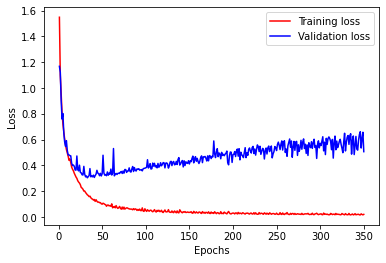

In [47]:
acc = history_dict['accuracy']
val_acc = history_dict['val_accuracy']
loss = history_dict['loss']
val_loss = history_dict['val_loss']

epochs = range(1, len(acc) + 1)

# “bo”代表 "蓝点"
plt.plot(epochs, loss, 'r', label='Training loss')
# b代表“蓝色实线”
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.savefig('new-hed-39-train-val loss')

plt.show()
# save_fig('train_val_loss')

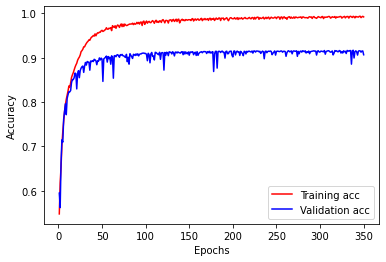

In [48]:
plt.plot(epochs, acc, 'r', label='Training acc')
plt.plot(epochs, val_acc, 'b', label='Validation acc')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.savefig('new-hed-39-train-val-acc')

plt.show()

In [49]:
from PIL import Image,ImageFilter,ImageDraw,ImageEnhance
import  random
from tqdm import tqdm
import numpy as np
import sys
from tifffile import TIFF
import tifffile as tiff
import os
import json
import matplotlib.pyplot as plt
%matplotlib inline
from tensorflow.keras.utils import plot_model
from tensorflow.keras import layers, Model, Sequential
import cv2
isprs_dir = root=r'F:/train_data/Semantic_segmentation/Inria_t'

In [50]:
#为预测标签创建新路径
test_parameters = {
    "input_size": [3, 256, 256],                           #输入图片的shape
    "class_dim": -1,                                     #分类数
    "test_path":r'F:/train_data/Semantic_segmentation/Inria_t',       #原始数据集路径
    "target_path":'F:/train_data/Semantic_segmentation/Inria_t/srcs/',        #要解压的路径 
    "test_list_path": "F:/train_data/Semantic_segmentation/Inria_t/tifs/test_data.txt",              #train_data.txt路径
    "label_dict":{},                                    #标签字典
    "readme_path": "F:/train_data/Semantic_segmentation/Inria_t/tifs/readme.json",   #readme.json路径
    "num_epochs": 10,                                    #训练轮数
    "train_batch_size":64,                             #批次的大小
    "learning_strategy": {                              #优化函数相关的配置
        "lr": 0.01                                     #超参数学习率
    } 
}

In [51]:
def get_data_list(target_path,test_list_path):
    '''
    生成数据列表
    '''
    #存放所有类别的信息
    class_detail = []
    #获取所有类别保存的文件夹名称
    data_list_path=target_path
    class_dirs = os.listdir(data_list_path)
    if '__MACOSX' in class_dirs:
        class_dirs.remove('__MACOSX')
    # #总的图像数量
    all_class_images = 0
    # #存放类别数目
    class_dim = 0
    # #存储要写进test.txt中的内容
    test_list=[]
    #读取每个类别
    for class_dir in class_dirs:
        if class_dir != ".DS_Store":
            class_dim += 1
            #每个类别的信息
            class_detail_list = {}
            test_sum = 0
            #统计每个类别有多少张图片
      
            #获取类别路径 
            path = os.path.join(data_list_path,class_dir)
            # print(path)
            # 获取所有图片
            
            img_paths = os.listdir(path)
            for img_path in img_paths:  
                # 遍历文件夹下的每个图片
                if img_path =='.DS_Store':
                    continue
#                 name_path = os.path.join(path,img_path)            # 每张图片的路径
                name_path = img_path
                test_sum += 1 
                test_list.append(name_path + "\n") 
                print(name_path)
                #test_sum测试数据的数目
    
            
            # 说明的json文件的class_detail数据
            class_detail_list['class_name'] = class_dir             #类别名称
            class_detail_list['class_test_images'] = test_sum       #该类数据的测试集数目
            class_detail.append(class_detail_list)  
            
    #初始化分类数
    test_parameters['class_dim'] = class_dim
    #print(train_parameters)
#     random.shuffle(test_list)
#按照数字顺序排列
    test_list.sort(key=lambda x: int(x.split('.')[0]))
    with open(test_list_path, 'a') as f:
        for test_image in test_list:
            f.write(test_image) 

    # 说明的json文件信息
    readjson = {}
    readjson['all_class_name'] = data_list_path                  #文件父目录
    readjson['all_class_images'] = all_class_images
    readjson['class_detail'] = class_detail
    jsons = json.dumps(readjson, sort_keys=True, indent=4, separators=(',', ': '))
    with open(test_parameters['readme_path'],'w') as f:
        f.write(jsons)
    print ('生成数据列表完成！')

In [52]:
'''
参数初始化
'''
test_path=test_parameters['test_path']
target_path=test_parameters['target_path']
test_list_path=test_parameters['test_list_path']

#每次生成数据列表前，首先清空test.txt
with open(test_list_path, 'w') as f: 
    f.seek(0)
    f.truncate() 
#生成数据列表   
get_data_list(target_path,test_list_path)

0.tif
1.tif
10.tif
100.tif
1000.tif
1001.tif
1002.tif
1003.tif
1004.tif
1005.tif
1006.tif
1007.tif
1008.tif
1009.tif
101.tif
1010.tif
1011.tif
1012.tif
1013.tif
1014.tif
1015.tif
1016.tif
1017.tif
1018.tif
1019.tif
102.tif
1020.tif
1021.tif
1022.tif
1023.tif
1024.tif
1025.tif
1026.tif
1027.tif
1028.tif
1029.tif
103.tif
1030.tif
1031.tif
1032.tif
1033.tif
1034.tif
1035.tif
1036.tif
1037.tif
1038.tif
1039.tif
104.tif
1040.tif
1041.tif
1042.tif
1043.tif
1044.tif
1045.tif
1046.tif
1047.tif
1048.tif
1049.tif
105.tif
1050.tif
1051.tif
1052.tif
1053.tif
1054.tif
1055.tif
1056.tif
1057.tif
1058.tif
1059.tif
106.tif
1060.tif
1061.tif
1062.tif
1063.tif
1064.tif
1065.tif
1066.tif
1067.tif
1068.tif
1069.tif
107.tif
1070.tif
1071.tif
1072.tif
1073.tif
1074.tif
1075.tif
1076.tif
1077.tif
1078.tif
1079.tif
108.tif
1080.tif
1081.tif
1082.tif
1083.tif
1084.tif
1085.tif
1086.tif
1087.tif
1088.tif
1089.tif
109.tif
1090.tif
1091.tif
1092.tif
1093.tif
1094.tif
1095.tif
1096.tif
1097.tif
1098.tif
1099.tif
1

3555.tif
3556.tif
3557.tif
3558.tif
3559.tif
356.tif
3560.tif
3561.tif
3562.tif
3563.tif
3564.tif
3565.tif
3566.tif
3567.tif
3568.tif
3569.tif
357.tif
3570.tif
3571.tif
3572.tif
3573.tif
3574.tif
3575.tif
3576.tif
3577.tif
3578.tif
3579.tif
358.tif
3580.tif
3581.tif
3582.tif
3583.tif
3584.tif
3585.tif
3586.tif
3587.tif
3588.tif
3589.tif
359.tif
3590.tif
3591.tif
3592.tif
3593.tif
3594.tif
3595.tif
3596.tif
3597.tif
3598.tif
3599.tif
36.tif
360.tif
3600.tif
3601.tif
3602.tif
3603.tif
3604.tif
3605.tif
3606.tif
3607.tif
3608.tif
3609.tif
361.tif
3610.tif
3611.tif
3612.tif
3613.tif
3614.tif
3615.tif
3616.tif
3617.tif
3618.tif
3619.tif
362.tif
3620.tif
3621.tif
3622.tif
3623.tif
3624.tif
3625.tif
3626.tif
3627.tif
3628.tif
3629.tif
363.tif
3630.tif
3631.tif
3632.tif
3633.tif
3634.tif
3635.tif
3636.tif
3637.tif
3638.tif
3639.tif
364.tif
3640.tif
3641.tif
3642.tif
3643.tif
3644.tif
3645.tif
3646.tif
3647.tif
3648.tif
3649.tif
365.tif
3650.tif
3651.tif
3652.tif
3653.tif
3654.tif
3655.tif
3656

6209.tif
621.tif
6210.tif
6211.tif
6212.tif
6213.tif
6214.tif
6215.tif
6216.tif
6217.tif
6218.tif
6219.tif
622.tif
6220.tif
6221.tif
6222.tif
6223.tif
6224.tif
6225.tif
6226.tif
6227.tif
6228.tif
6229.tif
623.tif
6230.tif
6231.tif
6232.tif
6233.tif
6234.tif
6235.tif
6236.tif
6237.tif
6238.tif
6239.tif
624.tif
6240.tif
6241.tif
6242.tif
6243.tif
6244.tif
6245.tif
6246.tif
6247.tif
6248.tif
6249.tif
625.tif
6250.tif
6251.tif
6252.tif
6253.tif
6254.tif
6255.tif
6256.tif
6257.tif
6258.tif
6259.tif
626.tif
6260.tif
6261.tif
6262.tif
6263.tif
6264.tif
6265.tif
6266.tif
6267.tif
6268.tif
6269.tif
627.tif
6270.tif
6271.tif
6272.tif
6273.tif
6274.tif
6275.tif
6276.tif
6277.tif
6278.tif
6279.tif
628.tif
6280.tif
6281.tif
6282.tif
6283.tif
6284.tif
6285.tif
6286.tif
6287.tif
6288.tif
6289.tif
629.tif
6290.tif
6291.tif
6292.tif
6293.tif
6294.tif
6295.tif
6296.tif
6297.tif
6298.tif
6299.tif
63.tif
630.tif
6300.tif
6301.tif
6302.tif
6303.tif
6304.tif
6305.tif
6306.tif
6307.tif
6308.tif
6309.tif
631.

In [53]:
'''
读入TIFF格式的图像
'''
def read_images(root=isprs_dir):
    txt_fname = '%s/tifs/%s' % (
        root, 'test_data.txt')
    
    with open(txt_fname, 'r') as f:
        image_names = f.read().split()
        
    image,images,ndsms= [None] * len(image_names), [None] * len(image_names), [None] * len(image_names)
    
    for i, fname in enumerate(image_names):
        
        img_name = '%s\\srcs\\srcs_train\\%s' % (root, fname)
       
        images[i] = cv2.imread(img_name)
        images[i] = cv2.cvtColor(images[i],cv2.COLOR_BGR2RGB)
    
    return images

In [54]:
test_images = read_images(root)
print('test_images[0]',test_images[0].shape)

test_images[0] (256, 256, 4)


In [76]:
test_images = np.array(test_images,dtype=np.float32) / 255

In [66]:
# def predict(img):
#     feature = tf.cast(img, tf.float32)
#     feature = tf.divide(img, 255.)
#     rgb_mean = np.array([ 0.334225, 0.362916, 0.329514, 0.000698])
#     rgb_std = np.array([ 0.143833,0.137335, 0.145572, 0.017366])
#     x = tf.divide(tf.subtract(feature, rgb_mean), rgb_std)
#     feature = (feature-rgb_mean)/rgb_std
#     x = tf.expand_dims(feature, axis=0)
#     print(x.shape)
#     return new_model.predict(x)

In [ ]:
def predict(img):
    feature = tf.cast(img, tf.float32)
    feature = tf.divide(img, 255.)
#     rgb_mean = np.array([ 0.334225, 0.362916, 0.329514, 0.000698])
#     rgb_std = np.array([ 0.143833,0.137335, 0.145572, 0.017366])
#     x = tf.divide(tf.subtract(feature, rgb_mean), rgb_std)
#     feature = (feature-rgb_mean)/rgb_std
    x = tf.expand_dims(feature, axis=0)
    print(x.shape)
    return new_model.predict(x)

In [56]:
def label2image(pred):
    colormap = np.array(COLORMAP, dtype='float32')
#     colormap = tuple(colormap)
    x = colormap[tf.argmax(pred, axis=-1)]
#     x = tup(x)
    print(pred[0, 160, 200])
    return x

In [57]:
#第一张样本图像索引
colormap2label = np.zeros(256 ** 3)
for i, color_map in enumerate(COLORMAP):
#     print("dddd", (color_map[0] * 256 + color_map[1]) * 256 + color_map[2])
#     print(i)
    colormap2label[(color_map[0] * 256 + color_map[1]) * 256 + color_map[2]] = i
    #i = int(colormap2label[(color_map[0] * 256 + color_map[1]) * 256 + color_map[2]])
colormap2label = tf.convert_to_tensor(colormap2label)
# print(colormap2label)

In [58]:
def label_indices(colormap,colormap2label):
    colormap = tf.cast(colormap, dtype=tf.int32)
    idx = ((colormap[:, :, 0] * 256 + colormap[:, :, 1]) * 256 + colormap[:, :, 2])

    #print(((colormap[:, :, 0] * 256 + colormap[:, :, 1]) * 256 + colormap[:, :, 2]).astype(np.int))
#     return tf.gather_nd(colormap2label, tf.expand_dims(idx, -1))
#     print(tf.gather_nd(colormap2label,tf.expand_dims(idx, -1)))
    return tf.gather_nd(colormap2label,tf.expand_dims(idx,-1))

In [ ]:
def predict_images(root=isprs_dir):
    output_dir = r'E:\train_data\Semantic_segmentation\Postdam_t\pre_label'
    plt.figure(figsize=(20,10))
    rows = 2
    cols = 5
    txt_fname = '%s/tifs/%s'%(
    root,'test_data.txt')
    with open(txt_fname,'r') as f:
        image_names = f.read().split()
        pred_images,pred_labels = [None] * len(image_names), [None] * len(image_names)
        images = [None] * len(image_names)
#         test_image,test_images,test_ndsms= [None] * len(image_names), [None] * len(image_names), [None] * len(image_names)
#         print(image_names)
#         print(pred_images)
    pred_images = []
#     for i,fname in enumerate(image_names[0:10]):
    for i,fname in enumerate(image_names):
        img_name = '%s\\srcs\\srcs_train\\%s' % (root, fname)
 

        
        test_images[i] = cv2.imread(img_name)
        test_images[i] = cv2.cvtColor(test_images[i],cv2.COLOR_BGR2RGB)
        test_images[i] = tf.cast(test_images[i],tf.float32)
      
        
#         test_images[i] = tiff.imread(img_name)
        pred_image = predict(test_images[i])
#         print('pred_image[0]',pred_image[0].shape)
        pred_image = label2image(pred_image)
#         print('pred_image[0]',pred_image[0])
        
#         print(pred_image)
#         pred_image = label2image(pred_image)
#         pred_image[i] = label_indices(pred_image[i],colormap2label)
#         print(pred_images)
#         pred_image = cv2.cvtColor(pred_image,cv2.COLOR_BGR2RGB)
        pred_images.append(pred_image)
#         pred_images[i] = np.array(pred_images[i],dtype=np.int32)
        tiff.imsave('%s.tif'%i, pred_image)
        pred_labels[i] = label_indices(pred_images[i],colormap2label)
        
# #         print(pred_images)

# #         print(os.path.join(output_dir, '%s.png'%i))
# #         cv2.imwrite(os.path.join(output_dir, str(i)+'.jpg'),pred_image)
#         tiff.imsave('%s.tif'%i, pred_image)
    return pred_images,pred_labels

In [61]:
pred_labels=predict_images(root)

(1, 256, 256, 4)


<ipython-input-56-06b96d9a59f7>:4: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  x = colormap[tf.argmax(pred, axis=-1)]


[3.6124906e-08 6.6424070e-07 7.1917167e-03 9.9274665e-01 6.0948762e-05
 1.4681078e-08]
(1, 256, 256, 4)
[3.1486475e-10 9.9999964e-01 1.7363089e-07 4.0390550e-08 6.6930333e-08
 2.2244955e-14]
(1, 256, 256, 4)
[5.1436615e-09 2.7648543e-09 7.8975262e-07 9.9999809e-01 1.0772106e-06
 4.6146517e-10]
(1, 256, 256, 4)
[8.1256569e-14 3.2803944e-11 3.6861825e-09 1.0000000e+00 8.4721657e-10
 9.9714734e-15]
(1, 256, 256, 4)
[1.0435271e-10 1.6813804e-14 9.1952080e-04 1.3725364e-09 5.1165311e-10
 9.9908042e-01]
(1, 256, 256, 4)
[7.5598439e-07 2.9067568e-09 9.9997449e-01 3.4949295e-08 3.0477040e-08
 2.4741474e-05]
(1, 256, 256, 4)
[9.4169629e-01 1.6144990e-05 2.2144463e-02 1.8288558e-02 1.7854566e-02
 2.0256116e-10]
(1, 256, 256, 4)
[1.6200633e-05 7.3409807e-05 3.5988941e-07 1.5702078e-06 9.9990845e-01
 2.9009676e-15]
(1, 256, 256, 4)
[1.56102561e-11 9.99997973e-01 2.02560705e-06 1.32264373e-11
 2.40259590e-09 1.09452175e-17]
(1, 256, 256, 4)
[1.2841015e-11 1.0000000e+00 6.6986261e-09 6.1901964e-09 4

[1.6993846e-06 3.9162897e-03 9.9608201e-01 1.5615412e-10 1.9252168e-11
 6.4341038e-10]
(1, 256, 256, 4)
[1.3592586e-07 9.4376759e-08 1.0877071e-06 1.5004190e-06 9.9999714e-01
 1.0758954e-08]
(1, 256, 256, 4)
[1.3336384e-07 3.4983707e-08 1.3558133e-06 1.1394684e-06 9.9999738e-01
 1.4855631e-10]
(1, 256, 256, 4)
[1.07027329e-08 4.40842710e-11 9.99999285e-01 9.59749542e-08
 1.05204805e-07 5.47980960e-07]
(1, 256, 256, 4)
[5.1161908e-10 1.0951972e-11 2.7462136e-07 2.1321003e-07 9.9999952e-01
 2.4299400e-15]
(1, 256, 256, 4)
[2.3223556e-08 4.3518103e-08 9.9996912e-01 9.6158055e-06 7.9962540e-08
 2.0967545e-05]
(1, 256, 256, 4)
[6.4180661e-11 9.9999928e-01 1.4568097e-07 2.9359069e-07 2.0917605e-07
 2.4291528e-14]
(1, 256, 256, 4)
[5.8842006e-06 1.2941570e-03 1.6718033e-05 9.5627620e-05 9.9858761e-01
 3.9373180e-09]
(1, 256, 256, 4)
[3.3745523e-10 9.9997628e-01 1.9748808e-07 2.2379218e-06 2.1290984e-05
 6.2772792e-14]
(1, 256, 256, 4)
[5.4447700e-09 1.5786098e-08 6.5104274e-08 9.1568644e-08 9

[1.8549084e-06 5.6862621e-07 2.9759396e-05 3.8523642e-05 9.9992895e-01
 3.5916096e-07]
(1, 256, 256, 4)
[1.5854460e-09 9.9532058e-12 9.1192845e-08 9.9999964e-01 1.9249600e-07
 4.4177674e-13]
(1, 256, 256, 4)
[3.0906600e-04 4.0638955e-07 6.5955806e-05 1.6167210e-08 9.9962449e-01
 5.9192007e-13]
(1, 256, 256, 4)
[1.2562126e-06 5.2041331e-09 9.9998641e-01 8.0059071e-06 4.2532479e-06
 3.0925541e-08]
(1, 256, 256, 4)
[6.2671131e-07 3.1828982e-09 3.3151700e-06 1.7791647e-06 9.9999416e-01
 6.3373577e-08]
(1, 256, 256, 4)
[9.0302459e-09 2.2236903e-10 6.8389783e-10 9.9999976e-01 2.0124047e-07
 1.7708389e-14]
(1, 256, 256, 4)
[3.6069705e-06 4.8076088e-04 9.9951565e-01 2.3954052e-11 2.2276664e-08
 1.8815762e-09]
(1, 256, 256, 4)
[8.0119920e-05 3.2596594e-01 2.0832764e-02 1.3181906e-03 6.5180290e-01
 1.4232019e-07]
(1, 256, 256, 4)
[9.5574360e-10 8.0330690e-12 9.9999845e-01 6.7813424e-08 1.4355431e-09
 1.4388883e-06]
(1, 256, 256, 4)
[5.8903385e-07 9.8373300e-07 1.5551755e-05 5.8052406e-06 9.99976

[6.6077213e-12 3.8683426e-10 8.2044909e-07 9.9999845e-01 6.7653076e-07
 2.5439880e-12]
(1, 256, 256, 4)
[5.23230987e-08 2.92644444e-07 9.99999285e-01 1.31994584e-08
 3.71112890e-07 1.38039805e-11]
(1, 256, 256, 4)
[1.1538251e-09 2.0537109e-07 9.9999976e-01 5.0496528e-08 2.4986853e-09
 1.9210962e-09]
(1, 256, 256, 4)
[1.2024883e-11 9.9999988e-01 6.4945826e-10 1.5737103e-07 5.4644669e-08
 2.4156984e-15]
(1, 256, 256, 4)
[2.4000399e-03 5.5902267e-01 1.2326340e-01 3.8886785e-05 3.1427428e-01
 1.0007480e-03]
(1, 256, 256, 4)
[1.8890811e-08 2.0425972e-10 9.9990797e-01 9.0987349e-05 9.8016858e-07
 6.2689367e-08]
(1, 256, 256, 4)
[7.0776684e-07 3.4466194e-10 6.4295670e-04 2.8447673e-08 3.1615869e-08
 9.9935633e-01]
(1, 256, 256, 4)
[4.4660087e-08 2.0887603e-07 1.6853987e-06 7.8868919e-07 9.9999726e-01
 3.4482889e-11]
(1, 256, 256, 4)
[1.5019393e-06 3.0744022e-08 4.6082561e-05 3.7873131e-03 9.9616504e-01
 3.9630361e-09]
(1, 256, 256, 4)
[9.1846243e-07 2.6160004e-07 9.9999738e-01 9.0464125e-09 1

[1.0028758e-09 1.0000000e+00 7.1271016e-09 5.0977927e-10 4.3011585e-09
 4.5478918e-15]
(1, 256, 256, 4)
[8.9779797e-07 3.9165350e-08 9.5078832e-07 6.8772486e-08 9.9999809e-01
 4.4396961e-10]
(1, 256, 256, 4)
[3.6534132e-07 6.0315269e-10 1.1590975e-06 9.9980611e-01 1.9235646e-04
 1.1300058e-09]
(1, 256, 256, 4)
[3.4417499e-06 3.6341862e-06 7.8212332e-05 4.2415276e-02 9.5749938e-01
 1.1902770e-09]
(1, 256, 256, 4)
[4.4610493e-09 1.5087287e-10 1.2359865e-06 9.9999857e-01 2.0549800e-07
 1.3633934e-08]
(1, 256, 256, 4)
[1.1462085e-07 1.2825265e-07 4.6687101e-06 2.3857958e-05 9.9997127e-01
 6.7914065e-09]
(1, 256, 256, 4)
[5.3987942e-06 2.2070592e-09 9.8736936e-01 6.2545966e-03 6.3699880e-03
 5.4508837e-07]
(1, 256, 256, 4)
[4.8345630e-08 2.9689927e-08 9.9999666e-01 1.1753029e-06 1.8170895e-06
 2.6004744e-07]
(1, 256, 256, 4)
[5.8406891e-07 2.6941991e-06 6.6779729e-05 3.1634164e-03 9.9676645e-01
 1.5606909e-07]
(1, 256, 256, 4)
[1.1545919e-08 2.6361621e-11 1.0925319e-06 8.6650698e-07 9.99997

[3.7834514e-12 4.8285371e-14 5.6065805e-09 1.0000000e+00 2.4985205e-08
 1.7258977e-12]
(1, 256, 256, 4)
[1.4077126e-07 1.9955733e-08 9.9999070e-01 2.1275873e-06 5.7368443e-06
 1.3404431e-06]
(1, 256, 256, 4)
[2.06898699e-06 1.34320473e-07 1.00575080e-02 2.48207543e-05
 9.89915490e-01 1.28504665e-08]
(1, 256, 256, 4)
[1.1917230e-06 6.1513128e-07 4.2679443e-04 3.7626203e-06 9.9956673e-01
 8.2775432e-07]
(1, 256, 256, 4)
[3.7854766e-06 9.7272132e-05 2.9430812e-04 4.7222777e-05 9.9952424e-01
 3.3295411e-05]
(1, 256, 256, 4)
[4.1655174e-10 4.3242437e-11 9.5465666e-06 9.9999046e-01 1.2181810e-08
 1.5307658e-11]
(1, 256, 256, 4)
[1.0420962e-09 1.6042995e-07 5.1800515e-07 9.9999821e-01 1.2410721e-06
 2.5769090e-11]
(1, 256, 256, 4)
[2.2702761e-07 1.2764430e-06 1.2082924e-05 2.8689144e-06 9.9998355e-01
 1.9899868e-08]
(1, 256, 256, 4)
[1.2314962e-08 5.7172974e-07 4.6039827e-07 1.6944514e-06 9.9999726e-01
 1.9328276e-12]
(1, 256, 256, 4)
[1.0084601e-08 3.6951878e-08 9.9999809e-01 3.9822257e-09 9

(1, 256, 256, 4)
[1.3193131e-11 1.1429840e-11 1.0000000e+00 2.8410181e-08 5.9308565e-11
 3.2131361e-08]
(1, 256, 256, 4)
[4.6401399e-07 4.9736377e-06 8.9508541e-07 1.0821927e-05 9.9998283e-01
 3.6486088e-11]
(1, 256, 256, 4)
[5.9038263e-07 1.2458101e-03 6.3320299e-06 9.9870086e-01 4.6425386e-05
 1.1525946e-09]
(1, 256, 256, 4)
[2.3937119e-07 6.6433427e-07 4.9156379e-06 6.1954540e-07 9.9999356e-01
 5.1125832e-09]
(1, 256, 256, 4)
[6.8041764e-08 4.9456943e-08 4.9813334e-06 1.2327826e-03 9.9876213e-01
 2.6901043e-10]
(1, 256, 256, 4)
[4.2124634e-11 5.5299901e-15 4.2189159e-09 1.0000000e+00 1.6838535e-09
 2.3754215e-12]
(1, 256, 256, 4)
[4.2152518e-11 6.6331727e-13 7.4847356e-10 1.0000000e+00 4.7488142e-09
 1.7514497e-15]
(1, 256, 256, 4)
[2.4398762e-08 2.6804542e-10 3.0496301e-06 9.8861617e-01 1.1380758e-02
 2.1872781e-12]
(1, 256, 256, 4)
[2.2031688e-10 5.8276335e-12 3.9723432e-08 1.4154239e-08 1.0000000e+00
 2.5555667e-12]
(1, 256, 256, 4)
[3.2064831e-06 2.9389501e-05 6.6887005e-04 1.33

[1.5612968e-11 6.7478870e-11 8.1089713e-09 1.0000000e+00 4.0768505e-08
 1.9979471e-14]
(1, 256, 256, 4)
[9.41338674e-10 9.99935150e-01 2.94840333e-07 1.79223425e-05
 4.66447163e-05 1.00677204e-13]
(1, 256, 256, 4)
[1.8643857e-07 1.1178113e-06 6.8217828e-06 5.7733263e-07 9.9999130e-01
 5.1762195e-10]
(1, 256, 256, 4)
[1.5088633e-06 1.5154463e-06 5.7816756e-06 1.9066500e-05 9.9997211e-01
 3.9829862e-10]
(1, 256, 256, 4)
[1.4238469e-07 6.5332662e-10 9.9999714e-01 2.2545423e-08 8.0147583e-11
 2.7384101e-06]
(1, 256, 256, 4)
[3.0879619e-05 2.6288832e-04 2.1835422e-04 3.4606561e-05 9.9944311e-01
 1.0164602e-05]
(1, 256, 256, 4)
[7.0544907e-08 3.6746277e-07 7.0471688e-06 5.9283093e-06 9.9998653e-01
 1.2208139e-08]
(1, 256, 256, 4)
[1.4271497e-05 2.6924486e-06 6.4909924e-04 2.9293672e-06 9.9932921e-01
 1.7493718e-06]
(1, 256, 256, 4)
[6.9376242e-08 7.6158886e-07 1.6478223e-06 2.1151891e-05 9.9997640e-01
 4.8659894e-09]
(1, 256, 256, 4)
[2.5725576e-12 9.9999094e-01 3.3602228e-09 4.8936558e-06 4

(1, 256, 256, 4)
[6.5598442e-06 1.0527590e-04 9.8665631e-01 2.2900127e-05 1.3208801e-02
 8.0195029e-08]
(1, 256, 256, 4)
[3.6494072e-12 2.6923262e-12 1.4769785e-09 9.9999988e-01 1.1298714e-07
 2.9535255e-16]
(1, 256, 256, 4)
[3.0503720e-14 4.3763437e-11 5.1826319e-08 1.0000000e+00 3.7739287e-09
 5.9497975e-12]
(1, 256, 256, 4)
[1.7767305e-09 4.3927323e-12 3.1158278e-09 1.0000000e+00 7.4240001e-09
 2.8002881e-11]
(1, 256, 256, 4)
[1.6172571e-08 1.9586184e-07 9.9999976e-01 1.4318021e-08 3.2156766e-10
 2.6352810e-08]
(1, 256, 256, 4)
[8.50544579e-10 8.72683092e-10 9.99998927e-01 1.01474775e-07
 2.38083719e-10 9.79491460e-07]
(1, 256, 256, 4)
[1.14853737e-14 1.00000000e+00 1.40692116e-08 1.65478831e-16
 1.57038553e-14 1.04400515e-22]
(1, 256, 256, 4)
[5.8166822e-08 6.1228484e-06 2.3302271e-04 9.0878311e-04 9.9885201e-01
 5.6376575e-08]
(1, 256, 256, 4)
[8.79360158e-08 9.99996185e-01 1.04380206e-07 4.98645125e-10
 3.61091475e-06 8.10719963e-11]
(1, 256, 256, 4)
[5.2584475e-15 3.8647233e-16 

[1.0538790e-13 9.9999976e-01 8.6870150e-10 8.1978953e-08 1.0772396e-07
 7.6313946e-18]
(1, 256, 256, 4)
[1.1939653e-09 1.9203221e-11 9.9997735e-01 2.0964881e-05 1.6339761e-06
 4.3564614e-09]
(1, 256, 256, 4)
[4.4515815e-07 2.4364208e-08 5.6093603e-07 1.8891383e-07 9.9999881e-01
 4.4148498e-09]
(1, 256, 256, 4)
[5.4626348e-09 8.9879074e-07 9.9999881e-01 5.9949552e-09 2.7833701e-07
 2.2276062e-10]
(1, 256, 256, 4)
[1.500898e-10 9.999999e-01 7.020357e-08 6.203196e-09 5.089559e-08
 2.986301e-16]
(1, 256, 256, 4)
[1.1152648e-06 6.3615185e-03 9.9331737e-01 5.9157905e-08 3.1986579e-04
 1.3409205e-07]
(1, 256, 256, 4)
[6.1985418e-05 8.4863636e-08 9.9992239e-01 4.1303517e-07 8.1949802e-06
 6.9663338e-06]
(1, 256, 256, 4)
[6.0539800e-01 9.1788871e-03 3.5142910e-02 4.8286463e-05 3.5023114e-01
 7.4584119e-07]
(1, 256, 256, 4)
[1.4077177e-10 2.7126977e-13 1.3582708e-03 9.9864155e-01 9.6779132e-08
 3.9490589e-10]
(1, 256, 256, 4)
[4.2593098e-17 1.0000000e+00 2.2668072e-12 1.8013957e-08 3.2739486e-08

(1, 256, 256, 4)
[3.27622658e-08 4.25947666e-10 1.93495381e-07 9.99610364e-01
 3.89475492e-04 1.10262565e-14]
(1, 256, 256, 4)
[3.8928279e-06 1.6341862e-07 9.9999571e-01 4.5695950e-10 9.0481443e-08
 1.5125920e-07]
(1, 256, 256, 4)
[7.7579348e-14 1.4988432e-15 3.2462453e-09 1.0000000e+00 2.3191572e-11
 2.1130027e-11]
(1, 256, 256, 4)
[7.2263851e-05 3.0223620e-05 1.2566931e-05 4.8162419e-06 9.9988008e-01
 1.3137728e-09]
(1, 256, 256, 4)
[2.3343759e-08 1.1567864e-08 4.5458721e-03 9.9542612e-01 2.8003500e-05
 1.2903750e-12]
(1, 256, 256, 4)
[7.2565615e-01 1.7056708e-03 2.7240565e-01 4.1302001e-06 3.6981903e-06
 2.2466115e-04]
(1, 256, 256, 4)
[1.0420832e-11 1.7880017e-11 1.0000000e+00 5.7957367e-10 2.8845689e-08
 5.2937377e-12]
(1, 256, 256, 4)
[1.8325713e-08 2.0418041e-09 2.6966316e-07 9.9997115e-01 2.8573984e-05
 6.9541427e-13]
(1, 256, 256, 4)
[9.9962399e-08 1.6251524e-06 1.7139520e-05 3.5126486e-05 9.9994600e-01
 3.1111225e-09]
(1, 256, 256, 4)
[1.37601734e-08 1.44758118e-07 1.33231639

[1.0018479e-08 8.7598900e-11 1.2208673e-05 9.9907351e-01 9.1416598e-04
 1.0670754e-09]
(1, 256, 256, 4)
[2.0033706e-09 4.8825713e-12 1.0000000e+00 4.4587481e-10 1.2577945e-09
 1.6262122e-08]
(1, 256, 256, 4)
[3.3075667e-09 6.3419897e-13 4.9978521e-10 9.9999499e-01 5.0209560e-06
 2.7358136e-18]
(1, 256, 256, 4)
[6.5207428e-06 2.7111162e-05 9.9996555e-01 2.0853463e-07 4.3089960e-07
 1.6879373e-07]
(1, 256, 256, 4)
[7.3525575e-10 3.8533940e-11 2.9269197e-06 9.9999332e-01 3.6445701e-06
 1.6886173e-14]
(1, 256, 256, 4)
[4.6107575e-12 7.7911753e-11 9.9999976e-01 1.2108022e-09 5.8800814e-10
 1.9457278e-07]
(1, 256, 256, 4)
[1.8757237e-29 1.0000000e+00 1.1213425e-19 1.1311106e-14 3.9130011e-13
 4.3217028e-38]
(1, 256, 256, 4)
[2.2890003e-08 1.6200298e-08 1.0000000e+00 9.5975539e-09 1.8031145e-08
 1.4726306e-08]
(1, 256, 256, 4)
[7.0658547e-07 5.0485778e-07 7.4187155e-05 9.9757212e-01 2.3524624e-03
 1.1291013e-13]
(1, 256, 256, 4)
[1.9417611e-10 5.7017065e-12 9.9999940e-01 3.3157196e-11 8.84303

[2.04799233e-11 1.00000000e+00 3.16038431e-08 3.23926241e-09
 1.28093065e-08 3.09832102e-13]
(1, 256, 256, 4)
[1.5195326e-08 2.8512850e-06 2.2641673e-07 8.7640405e-01 1.2359295e-01
 1.0438394e-18]
(1, 256, 256, 4)
[1.4197096e-06 1.8592840e-06 9.9998295e-01 4.7180442e-06 8.7494682e-06
 1.7981510e-07]
(1, 256, 256, 4)
[3.6622899e-07 3.7972977e-06 5.8857447e-01 1.3353941e-01 2.7788135e-01
 6.7997121e-07]
(1, 256, 256, 4)
[2.0294134e-07 5.3446382e-08 9.9999619e-01 3.7710436e-07 2.0912885e-06
 1.1166671e-06]
(1, 256, 256, 4)
[1.4840200e-10 9.9999964e-01 3.6417994e-08 2.1227699e-07 6.4454845e-08
 4.4869951e-13]
(1, 256, 256, 4)
[1.0322434e-15 1.7748817e-16 6.9371016e-11 1.0000000e+00 3.2781052e-11
 8.9658925e-16]
(1, 256, 256, 4)
[1.2022622e-09 8.7486249e-09 3.4540326e-06 8.2050055e-06 9.9998820e-01
 8.5609280e-08]
(1, 256, 256, 4)
[1.2525955e-10 4.4560730e-11 2.5906408e-08 9.9999928e-01 6.9249546e-07
 3.5456403e-13]
(1, 256, 256, 4)
[9.9888390e-01 4.9664618e-06 1.0672281e-03 2.5189630e-09 2

[5.7560817e-10 8.5248852e-10 9.9998164e-01 1.7709399e-05 1.0246837e-08
 5.3369791e-07]
(1, 256, 256, 4)
[4.7361559e-10 6.9241032e-08 2.2189132e-08 1.7131306e-07 9.9999976e-01
 4.1158674e-12]
(1, 256, 256, 4)
[8.4278377e-05 5.0956130e-01 4.9035445e-01 1.2438668e-10 3.5790138e-09
 1.8583007e-14]
(1, 256, 256, 4)
[3.4441994e-13 1.0000000e+00 4.6062766e-08 2.2538942e-09 7.2495339e-09
 7.1615982e-18]
(1, 256, 256, 4)
[5.7430171e-08 1.9097399e-09 9.9999905e-01 2.3294113e-07 7.2222313e-08
 6.5092144e-07]
(1, 256, 256, 4)
[1.8391302e-05 1.9609137e-08 4.7595909e-06 9.1651142e-01 8.3465271e-02
 5.0777391e-09]
(1, 256, 256, 4)
[3.6518479e-06 9.9997115e-01 2.2831060e-05 5.4597604e-07 1.7305538e-06
 2.7169262e-09]
(1, 256, 256, 4)
[2.8887477e-08 3.2680381e-09 8.0626723e-09 2.6996283e-08 9.9999988e-01
 6.6801320e-18]
(1, 256, 256, 4)
[1.9450208e-06 1.1812780e-05 8.4191831e-03 1.4216642e-05 9.9155223e-01
 6.3794704e-07]
(1, 256, 256, 4)
[9.3836308e-09 7.1744246e-09 9.9405759e-07 2.9953870e-05 9.99969

[2.2179859e-06 1.6131567e-05 9.9998128e-01 1.9377627e-07 3.9402872e-09
 1.1560771e-07]
(1, 256, 256, 4)
[3.8295493e-08 9.2491979e-09 1.1086183e-06 7.7544646e-06 9.9999106e-01
 8.0766761e-11]
(1, 256, 256, 4)
[1.0905407e-11 9.9999785e-01 7.5641164e-09 1.3837988e-06 7.0222075e-07
 5.8254005e-15]
(1, 256, 256, 4)
[1.0902352e-04 9.6804431e-09 5.4575037e-05 7.2475043e-03 9.9258822e-01
 6.5905436e-07]
(1, 256, 256, 4)
[2.7844137e-06 9.9715841e-01 2.8388239e-03 4.1538821e-12 3.7556202e-08
 7.4809570e-13]
(1, 256, 256, 4)
[9.4931829e-07 6.9010092e-08 2.7831498e-05 2.3356025e-04 9.9973541e-01
 2.1126182e-06]
(1, 256, 256, 4)
[1.4029842e-09 1.2516700e-10 2.0739550e-07 9.9999833e-01 1.3755091e-06
 6.1637149e-12]
(1, 256, 256, 4)
[9.4670142e-08 1.4990309e-08 9.9999964e-01 2.8975153e-08 5.4216208e-08
 2.3487374e-07]
(1, 256, 256, 4)
[9.5861459e-01 4.0986303e-02 4.6780304e-05 2.7694894e-04 7.3869283e-05
 1.5850782e-06]
(1, 256, 256, 4)
[4.3119702e-08 2.4265623e-09 9.9997890e-01 9.5262067e-07 1.80706

(1, 256, 256, 4)
[2.32247572e-08 8.86893936e-09 2.35164691e-07 1.28453435e-08
 9.99999762e-01 3.33382127e-10]
(1, 256, 256, 4)
[3.11673034e-06 4.16484522e-03 9.95665610e-01 1.53573405e-04
 1.25420975e-05 2.75730571e-07]
(1, 256, 256, 4)
[1.2029918e-11 9.9999893e-01 1.0849865e-06 2.1849777e-11 1.1226883e-10
 1.0134776e-17]
(1, 256, 256, 4)
[3.4549468e-15 1.0000000e+00 1.1913165e-10 2.4454908e-10 4.3878359e-11
 1.4617478e-19]
(1, 256, 256, 4)
[8.3749512e-08 2.5765027e-07 9.9999952e-01 5.4642985e-08 6.1137007e-09
 9.8474786e-08]
(1, 256, 256, 4)
[2.6165667e-09 1.5435421e-07 3.3400497e-07 9.9385595e-08 9.9999940e-01
 4.3752350e-13]
(1, 256, 256, 4)
[1.8562987e-07 6.8164452e-09 1.2334563e-04 1.2043946e-03 9.9867213e-01
 2.7223859e-09]
(1, 256, 256, 4)
[1.11864855e-08 1.25754811e-08 1.00000000e+00 2.51552801e-09
 2.33743691e-10 2.05239861e-08]
(1, 256, 256, 4)
[8.3278125e-14 1.0000000e+00 3.3239060e-09 1.1392893e-09 3.6771168e-09
 1.3703853e-19]
(1, 256, 256, 4)
[3.7010766e-06 7.0169045e-07 

(1, 256, 256, 4)
[3.72810810e-11 1.00000000e+00 2.83971646e-09 3.68452540e-08
 9.68878133e-09 1.05513175e-14]
(1, 256, 256, 4)
[2.1874136e-08 7.9323894e-01 2.0676106e-01 5.8356202e-11 1.6633522e-10
 2.1750872e-11]
(1, 256, 256, 4)
[1.7621793e-11 9.4966679e-10 1.0000000e+00 3.9302130e-09 3.6400313e-11
 1.1026886e-08]
(1, 256, 256, 4)
[1.1437282e-08 1.7680090e-07 8.0940799e-06 3.3436436e-07 9.9999142e-01
 1.0309199e-08]
(1, 256, 256, 4)
[1.2203979e-10 6.7235093e-12 9.9999952e-01 2.3958713e-10 2.8983521e-10
 5.0357460e-07]
(1, 256, 256, 4)
[5.4873736e-03 9.7652996e-01 1.7878268e-02 3.8460037e-08 8.9887188e-05
 1.4365377e-05]
(1, 256, 256, 4)
[8.1690679e-12 1.0000000e+00 2.5587605e-09 1.5795587e-08 1.0121116e-08
 5.7273340e-16]
(1, 256, 256, 4)
[2.9975553e-09 3.1848263e-08 9.9999845e-01 3.8642708e-07 4.6925326e-09
 1.1450514e-06]
(1, 256, 256, 4)
[1.4853452e-03 1.1414470e-01 1.7805810e-01 5.3680711e-03 7.0094359e-01
 2.8326212e-07]
(1, 256, 256, 4)
[3.2359501e-10 2.4286703e-12 9.9999988e-0

[2.5985381e-10 1.2473458e-07 1.0263363e-07 9.4319348e-06 9.9999034e-01
 1.4576085e-14]
(1, 256, 256, 4)
[2.0218983e-11 3.6820221e-13 1.0000000e+00 1.1124314e-08 1.3972903e-09
 2.6780467e-09]
(1, 256, 256, 4)
[9.57055211e-01 1.56587645e-04 1.02906313e-04 1.22144883e-09
 4.26733010e-02 1.20018185e-05]
(1, 256, 256, 4)
[4.2315481e-11 9.9999988e-01 1.5080498e-07 5.4829405e-14 2.6103434e-12
 6.0587817e-17]
(1, 256, 256, 4)
[1.0956837e-20 1.0000000e+00 9.1316835e-15 4.9292570e-11 1.5624772e-10
 7.0512316e-28]
(1, 256, 256, 4)
[7.8640757e-12 3.1666543e-15 4.6101872e-12 1.0000000e+00 2.2902974e-08
 3.6735702e-20]
(1, 256, 256, 4)
[2.7818821e-04 7.1592501e-07 2.4089203e-03 2.1936305e-02 9.7535795e-01
 1.7921884e-05]
(1, 256, 256, 4)
[1.0749999e-02 5.6703222e-01 4.2218783e-01 2.6088487e-09 1.6421041e-05
 1.3535846e-05]
(1, 256, 256, 4)
[9.6767767e-12 9.9999964e-01 5.7241638e-09 1.8241414e-07 9.4442179e-08
 5.2819674e-15]
(1, 256, 256, 4)
[8.7224095e-10 9.9993455e-01 8.5650782e-07 4.8207163e-05 1

(1, 256, 256, 4)
[1.3145748e-06 1.9110914e-07 7.4330092e-07 1.9739111e-06 9.9999583e-01
 6.3722634e-12]
(1, 256, 256, 4)
[3.1020736e-10 5.0984457e-09 4.2988509e-06 9.9991190e-01 8.3766994e-05
 3.7282829e-12]
(1, 256, 256, 4)
[6.5748180e-16 1.0000000e+00 1.4478050e-11 4.5999613e-09 1.4566626e-08
 4.3768723e-21]
(1, 256, 256, 4)
[9.9578108e-05 2.3213932e-08 9.9896002e-01 1.7184835e-05 3.9959422e-04
 5.2372512e-04]
(1, 256, 256, 4)
[1.3084665e-12 9.9999249e-01 1.4990967e-09 4.1140133e-06 3.3873371e-06
 6.9277984e-17]
(1, 256, 256, 4)
[3.22678915e-07 1.06674465e-08 3.30617672e-06 5.33386628e-06
 9.99990940e-01 8.12863021e-08]
(1, 256, 256, 4)
[2.3998609e-06 1.3650289e-09 9.9997330e-01 1.5418519e-06 1.8057501e-05
 4.7175981e-06]
(1, 256, 256, 4)
[2.4534855e-11 8.6619885e-11 9.2275366e-07 9.9999905e-01 1.6054601e-08
 8.6799651e-11]
(1, 256, 256, 4)
[1.5750502e-09 4.0724553e-09 9.9999952e-01 1.7057280e-08 8.6786293e-11
 5.1129160e-07]
(1, 256, 256, 4)
[3.6360720e-07 1.6780052e-07 1.6077402e-0

[1.5556584e-10 2.1631095e-12 3.8063837e-07 5.7557324e-04 9.9942410e-01
 4.6125766e-13]
(1, 256, 256, 4)
[1.6821149e-03 2.4160379e-08 9.9831104e-01 7.0835341e-07 6.0931570e-06
 9.5237320e-09]
(1, 256, 256, 4)
[8.9965280e-09 1.4052097e-07 6.1862784e-07 8.2331013e-08 9.9999917e-01
 2.5356930e-11]
(1, 256, 256, 4)
[4.7118667e-13 1.0000000e+00 2.0066835e-08 1.0463923e-09 1.1651129e-09
 5.5893249e-17]
(1, 256, 256, 4)
[1.3284617e-04 9.9943978e-01 3.8365822e-04 7.1610611e-07 4.2990203e-05
 1.1582036e-11]
(1, 256, 256, 4)
[1.9893408e-11 2.0943586e-13 7.8541946e-09 1.0000000e+00 5.1353193e-09
 1.8297388e-12]
(1, 256, 256, 4)
[3.7923984e-09 3.9433554e-10 9.9845731e-01 1.5416059e-03 1.0845760e-06
 4.9335956e-12]
(1, 256, 256, 4)
[3.6580995e-11 3.6299574e-11 1.0000000e+00 8.0437035e-09 3.8629167e-09
 4.1939442e-11]
(1, 256, 256, 4)
[1.0685692e-11 1.0000000e+00 3.2925129e-10 2.0576331e-10 3.0753816e-10
 5.9838397e-15]
(1, 256, 256, 4)
[1.3864329e-07 9.9999940e-01 4.2585896e-07 2.9351719e-08 4.67827

[3.5006730e-07 5.0216033e-07 1.8114637e-05 8.9149245e-05 9.9989176e-01
 6.8713121e-08]
(1, 256, 256, 4)
[8.0078716e-10 1.5639438e-07 9.4768530e-01 2.5042484e-06 5.2312076e-02
 5.6378985e-13]
(1, 256, 256, 4)
[3.4064835e-09 7.8625133e-09 1.0000000e+00 9.7788566e-10 1.2404193e-09
 4.4962093e-08]
(1, 256, 256, 4)
[1.0993714e-09 7.3367510e-12 6.8500644e-01 3.1497961e-01 1.3973642e-05
 1.1148908e-11]
(1, 256, 256, 4)
[5.7935996e-08 9.3669740e-08 3.2234479e-07 9.9998677e-01 1.2781446e-05
 9.3329294e-12]
(1, 256, 256, 4)
[2.5191744e-09 5.5023396e-13 3.1961983e-10 9.9999511e-01 4.9224618e-06
 3.6511158e-20]
(1, 256, 256, 4)
[7.5835919e-06 9.9998903e-01 2.9601465e-06 2.4788758e-07 5.1071535e-08
 9.1847134e-09]
(1, 256, 256, 4)
[1.4981241e-09 2.9952154e-09 1.7193697e-07 9.9999964e-01 2.5431558e-07
 1.5393761e-11]
(1, 256, 256, 4)
[3.9315838e-13 9.9999988e-01 1.1653283e-09 7.0647651e-08 8.9496908e-09
 1.1063581e-16]
(1, 256, 256, 4)
[4.3914849e-08 3.3821148e-09 9.9999988e-01 1.4783345e-07 5.00682

(1, 256, 256, 4)
[7.4530704e-10 3.9716532e-09 9.9999845e-01 1.5138546e-07 4.7910914e-10
 1.4618025e-06]
(1, 256, 256, 4)
[8.41196670e-05 2.65633735e-05 6.63949177e-03 1.03385755e-05
 9.93239522e-01 9.62854951e-09]
(1, 256, 256, 4)
[1.9356154e-11 1.0000000e+00 3.6478574e-11 1.2973672e-09 2.4819463e-10
 2.5650304e-16]
(1, 256, 256, 4)
[2.0189425e-11 2.9407534e-13 6.1168148e-10 7.1715203e-11 1.0000000e+00
 1.0292025e-18]
(1, 256, 256, 4)
[1.3595447e-10 1.6201803e-08 1.0329772e-08 9.9999368e-01 6.2735298e-06
 1.6843406e-17]
(1, 256, 256, 4)
[3.5080407e-11 9.1510494e-11 2.7670462e-06 4.8230539e-04 9.9951494e-01
 1.6515032e-14]
(1, 256, 256, 4)
[2.2024320e-15 1.6115886e-19 3.2398060e-09 1.0000000e+00 1.1730443e-09
 1.7743342e-15]
(1, 256, 256, 4)
[3.4984129e-08 9.9999988e-01 1.4865597e-07 1.8276083e-15 2.2540946e-14
 1.5317013e-17]
(1, 256, 256, 4)
[9.4112653e-01 1.8340332e-04 5.7351679e-02 2.4807418e-04 1.0902166e-03
 3.2799544e-10]
(1, 256, 256, 4)
[7.3055958e-07 2.1277502e-10 4.4207255e-0

(1, 256, 256, 4)
[2.6622975e-12 3.5638534e-15 9.9728274e-01 1.3444580e-11 2.0662506e-11
 2.7171862e-03]
(1, 256, 256, 4)
[4.9511112e-07 9.9985647e-01 1.4188913e-04 4.5553437e-09 1.2136860e-06
 5.0272781e-12]
(1, 256, 256, 4)
[7.50202067e-10 1.17822616e-07 1.27647772e-05 9.99880552e-01
 1.06533604e-04 6.64907419e-13]
(1, 256, 256, 4)
[9.0247842e-05 5.0005701e-07 2.7022430e-01 3.7010348e-05 7.2701973e-01
 2.6282812e-03]
(1, 256, 256, 4)
[9.0264490e-10 5.8904317e-09 9.9999940e-01 1.2071885e-07 6.3187600e-10
 4.5466146e-07]
(1, 256, 256, 4)
[7.6454320e-08 1.7077246e-05 1.4860913e-05 4.7000558e-06 9.9996328e-01
 4.8553663e-09]
(1, 256, 256, 4)
[1.8157551e-09 1.6460916e-07 9.9999988e-01 2.3025787e-08 5.6920690e-09
 1.8986540e-12]
(1, 256, 256, 4)
[6.6749863e-08 1.9059192e-08 9.9995279e-01 1.7283927e-06 4.5417972e-05
 8.0472065e-09]
(1, 256, 256, 4)
[2.1356013e-09 1.9808210e-08 4.2905583e-08 9.9999988e-01 6.1537527e-08
 5.0031292e-11]
(1, 256, 256, 4)
[6.5439125e-12 2.0826698e-13 9.9999940e-0

(1, 256, 256, 4)
[1.7975472e-12 8.0586296e-16 9.9999774e-01 2.2841086e-06 4.7752099e-08
 2.8136787e-10]
(1, 256, 256, 4)
[8.8062675e-11 1.2630117e-14 2.9675136e-06 8.4650535e-09 8.2781997e-11
 9.9999702e-01]
(1, 256, 256, 4)
[0.0000000e+00 1.0000000e+00 2.4401713e-35 5.7241130e-27 6.0589106e-28
 0.0000000e+00]
(1, 256, 256, 4)
[3.2860947e-07 4.4334008e-09 1.9886299e-06 7.1868371e-08 9.9999762e-01
 2.9412878e-11]
(1, 256, 256, 4)
[4.4753196e-07 5.3115133e-07 7.0838146e-06 2.2564034e-01 7.7435160e-01
 7.6171717e-12]
(1, 256, 256, 4)
[1.3250455e-09 1.0531387e-10 9.9999928e-01 2.9344442e-08 6.4688234e-11
 7.6530205e-07]
(1, 256, 256, 4)
[6.4206709e-08 3.2422514e-09 9.9999917e-01 2.3107705e-07 3.5136759e-07
 6.9843175e-08]
(1, 256, 256, 4)
[2.2728640e-12 9.9996746e-01 9.9162163e-09 3.4065956e-06 2.9039413e-05
 2.6941595e-16]
(1, 256, 256, 4)
[2.5979212e-23 1.0000000e+00 6.4577908e-16 6.7488233e-12 1.4928996e-12
 1.2552971e-28]
(1, 256, 256, 4)
[1.7908232e-04 4.3345891e-09 9.9598026e-01 1.33

[4.6331238e-02 4.8584160e-01 4.6777055e-01 1.4532884e-07 5.4726253e-05
 1.6769263e-06]
(1, 256, 256, 4)
[9.8257402e-11 5.0386644e-16 1.1441944e-07 1.1287824e-07 1.1587568e-12
 9.9999976e-01]
(1, 256, 256, 4)
[7.3394112e-08 4.7257483e-11 2.2122388e-09 9.9999762e-01 2.2827016e-06
 5.3724441e-16]
(1, 256, 256, 4)
[4.3974950e-08 2.8035190e-09 9.9999428e-01 1.1443774e-06 1.5324126e-08
 4.5471184e-06]
(1, 256, 256, 4)
[7.20764717e-07 1.36885685e-08 1.14317472e-05 9.89932418e-01
 1.00554451e-02 1.37945533e-09]
(1, 256, 256, 4)
[5.2914975e-09 2.5032383e-09 9.9994528e-01 1.0651305e-06 8.9725372e-06
 4.4619523e-05]
(1, 256, 256, 4)
[3.1804984e-10 1.5452896e-10 9.9999952e-01 1.6826496e-08 1.0144797e-10
 5.1541036e-07]
(1, 256, 256, 4)
[6.3493291e-09 1.3185363e-09 9.9999940e-01 4.6546387e-07 5.9384913e-08
 7.3930635e-09]
(1, 256, 256, 4)
[1.9928605e-04 1.8179324e-04 3.2974116e-04 5.9074404e-07 9.9928856e-01
 4.1894897e-11]
(1, 256, 256, 4)
[5.9072931e-06 9.3530712e-09 4.7615424e-02 9.5141804e-01 9

(1, 256, 256, 4)
[5.3532490e-09 1.2109635e-11 7.9948648e-10 9.9999285e-01 7.0937931e-06
 1.0994924e-16]
(1, 256, 256, 4)
[1.0123690e-10 6.2309512e-14 2.3448496e-09 4.0365501e-07 9.9999964e-01
 5.3864681e-17]
(1, 256, 256, 4)
[2.2438742e-09 1.0000000e+00 3.0796990e-08 1.1525870e-09 4.6624917e-09
 1.6374386e-12]
(1, 256, 256, 4)
[1.5843737e-07 1.2207711e-08 6.9080561e-01 3.0909121e-01 2.6612057e-05
 7.6380515e-05]
(1, 256, 256, 4)
[2.8576359e-09 9.2215491e-10 7.1336638e-07 1.0605384e-04 9.9989319e-01
 5.6731420e-10]
(1, 256, 256, 4)
[1.0567361e-08 4.2231002e-10 9.9999809e-01 1.6326441e-06 1.1306762e-08
 1.7822852e-07]
(1, 256, 256, 4)
[3.6580784e-07 5.7174759e-07 8.4783292e-01 8.0827971e-07 1.5216355e-01
 1.8781348e-06]
(1, 256, 256, 4)
[5.8158513e-12 3.5616200e-12 9.9999988e-01 1.9181792e-08 3.2516389e-11
 1.7116383e-07]
(1, 256, 256, 4)
[3.89304944e-07 1.00768206e-10 2.14130342e-01 7.29931712e-01
 5.59375994e-02 1.92441771e-10]
(1, 256, 256, 4)
[4.0521832e-11 9.1673137e-16 1.0000000e+0

(1, 256, 256, 4)
[6.9476485e-02 6.5893278e-04 6.9356698e-01 1.4000594e-02 2.2220987e-01
 8.7213491e-05]
(1, 256, 256, 4)
[1.72462133e-08 8.68711658e-10 1.00000000e+00 5.29586899e-08
 1.04811075e-08 2.47287357e-10]
(1, 256, 256, 4)
[4.6306567e-09 9.9999988e-01 1.1996730e-07 3.0740735e-10 3.3460161e-09
 2.3699092e-12]
(1, 256, 256, 4)
[3.9225303e-12 1.0000000e+00 2.6944186e-11 1.0800326e-09 7.5956164e-10
 1.5006675e-16]
(1, 256, 256, 4)
[6.6572109e-11 9.0453445e-10 1.0000000e+00 1.0907600e-10 3.7003074e-12
 3.7064918e-14]
(1, 256, 256, 4)
[1.60533670e-11 5.51335270e-14 1.00000000e+00 1.50975654e-09
 1.06733775e-13 1.15269694e-09]
(1, 256, 256, 4)
[1.4053738e-19 1.0000000e+00 2.7354719e-11 1.3780411e-16 1.8166252e-16
 1.4318311e-25]
(1, 256, 256, 4)
[6.3104862e-11 9.9697363e-01 3.0263558e-03 2.3846542e-16 4.7955525e-13
 1.8888960e-21]
(1, 256, 256, 4)
[2.2461558e-07 1.8946491e-06 1.4476818e-05 2.8609986e-06 9.9998057e-01
 4.4037545e-08]
(1, 256, 256, 4)
[4.9667108e-08 5.4586144e-07 2.1919

(1, 256, 256, 4)
[7.7340934e-09 2.4370049e-06 9.9999619e-01 2.6633427e-07 2.8027291e-08
 1.0379409e-06]
(1, 256, 256, 4)
[1.8692679e-09 9.9867165e-01 1.2882712e-05 1.2198050e-03 9.5764452e-05
 2.8888100e-11]
(1, 256, 256, 4)
[1.0254633e-04 2.0955149e-08 9.9967206e-01 9.3238867e-07 2.1854091e-04
 5.9142549e-06]
(1, 256, 256, 4)
[2.5632595e-05 9.9975961e-01 2.1290159e-04 1.7879557e-07 1.6178126e-06
 1.5334621e-08]
(1, 256, 256, 4)
[5.3643603e-08 4.5970528e-06 4.3637552e-05 9.9994493e-01 6.6826410e-06
 6.5612156e-08]
(1, 256, 256, 4)
[4.1348409e-15 1.0000000e+00 6.0574025e-11 5.9880372e-09 1.3934153e-09
 3.6049813e-18]
(1, 256, 256, 4)
[4.0369796e-06 9.6725569e-07 9.9989283e-01 2.2468542e-07 9.4933210e-05
 6.9714647e-06]
(1, 256, 256, 4)
[3.6370352e-07 1.3018916e-09 9.9999845e-01 3.9758635e-07 6.3572128e-07
 1.8380656e-07]
(1, 256, 256, 4)
[2.4463476e-09 1.0609738e-05 9.9998939e-01 8.3658103e-09 1.8201353e-10
 4.3152140e-09]
(1, 256, 256, 4)
[2.6073104e-07 4.8479529e-07 9.7253710e-01 2.74

[1.5648455e-07 4.6902404e-10 4.9316372e-06 1.0997470e-07 1.7394818e-08
 9.9999475e-01]
(1, 256, 256, 4)
[2.4783710e-13 1.0000000e+00 1.7131423e-09 4.8617257e-09 1.6561780e-08
 7.5028041e-17]
(1, 256, 256, 4)
[1.5841929e-09 2.0523623e-10 9.9992609e-01 2.9581795e-06 7.0909162e-05
 2.1526073e-12]
(1, 256, 256, 4)
[4.2261387e-08 5.2063629e-09 1.8998255e-05 1.0310606e-06 9.9997997e-01
 7.2554024e-10]
(1, 256, 256, 4)
[5.6058904e-09 7.8523660e-11 3.0263716e-06 9.9999702e-01 1.6890572e-08
 2.0041785e-13]
(1, 256, 256, 4)
[1.4711942e-11 1.6492310e-08 1.4931154e-06 9.9949312e-01 5.0527777e-04
 2.8747394e-15]
(1, 256, 256, 4)
[9.9857628e-01 4.2975120e-08 7.7365775e-04 4.4108515e-06 6.3715497e-04
 8.5613810e-06]
(1, 256, 256, 4)
[4.8306542e-06 9.9989641e-01 9.8617966e-05 7.6329158e-08 2.6200290e-08
 1.1451562e-08]
(1, 256, 256, 4)
[1.8761149e-05 4.2459501e-08 9.9996853e-01 6.3439438e-06 6.0878456e-06
 2.4151578e-07]
(1, 256, 256, 4)
[2.2282507e-07 1.7872169e-07 2.8142249e-03 6.4028612e-08 9.97185

[1.7130860e-08 2.3153529e-08 9.9924588e-01 7.4326189e-04 2.6066398e-06
 8.1818316e-06]
(1, 256, 256, 4)
[3.1067259e-07 2.5069376e-06 1.9175028e-05 2.7983799e-04 9.9969816e-01
 4.1244047e-10]
(1, 256, 256, 4)
[1.0925251e-06 7.3892415e-02 9.2598313e-01 4.2963657e-06 1.1909069e-04
 6.5322214e-10]
(1, 256, 256, 4)
[4.0088923e-07 3.8402014e-08 9.9960834e-01 2.3539322e-07 3.9088496e-04
 4.7762189e-08]
(1, 256, 256, 4)
[7.2151920e-07 6.5158617e-10 8.2557964e-01 6.1433046e-04 1.7377856e-01
 2.6777861e-05]
(1, 256, 256, 4)
[8.0317168e-12 9.9999976e-01 2.8709630e-07 8.2422730e-10 6.9290804e-09
 3.8225955e-17]
(1, 256, 256, 4)
[7.6127151e-04 2.5324955e-08 2.7507736e-04 6.5034533e-09 1.2676300e-07
 9.9896348e-01]
(1, 256, 256, 4)
[4.1384300e-09 9.9999678e-01 3.2773839e-06 2.4770530e-10 1.8367125e-08
 6.5936601e-12]
(1, 256, 256, 4)
[2.8967769e-11 3.2861117e-11 6.9803643e-09 1.0000000e+00 1.0724953e-08
 1.7183660e-12]
(1, 256, 256, 4)
[1.2753385e-07 1.9180327e-08 2.9239325e-05 9.5932519e-01 4.06454

[5.5707194e-10 5.9644645e-09 1.0000000e+00 6.9330079e-09 4.4754414e-09
 1.2724972e-09]
(1, 256, 256, 4)
[1.4645415e-15 1.0000000e+00 2.3627593e-09 4.2568776e-15 2.6081064e-14
 4.6351488e-23]
(1, 256, 256, 4)
[1.1833284e-08 3.2073797e-09 6.6149980e-08 9.9995065e-01 4.9269940e-05
 8.0164908e-16]
(1, 256, 256, 4)
[3.0560579e-06 1.3469001e-03 8.3829998e-04 7.4045779e-04 9.9707127e-01
 3.2455409e-09]
(1, 256, 256, 4)
[2.4252567e-09 1.6341273e-08 9.9999559e-01 4.4394910e-06 1.4617160e-08
 7.8994637e-11]
(1, 256, 256, 4)
[3.9283674e-07 4.7502930e-09 9.9999857e-01 4.1377842e-08 1.0677504e-06
 3.9158238e-10]
(1, 256, 256, 4)
[7.9073308e-09 8.1882445e-07 6.4481005e-06 3.7351194e-07 9.9999237e-01
 2.4219158e-09]
(1, 256, 256, 4)
[3.7321795e-06 3.6478832e-06 9.9998736e-01 2.4969313e-06 1.9847616e-06
 8.0213647e-07]
(1, 256, 256, 4)
[5.6121841e-10 5.9459895e-11 1.0000000e+00 4.0297568e-10 4.0287887e-10
 1.3220872e-10]
(1, 256, 256, 4)
[5.2748322e-07 1.7060957e-07 2.9501063e-04 1.3994189e-03 9.98304

[1.3981717e-09 9.9999928e-01 7.1931066e-07 9.4815711e-09 5.4019726e-09
 1.9257411e-15]
(1, 256, 256, 4)
[2.6337710e-14 5.0110465e-15 1.0000000e+00 4.2072899e-12 2.7010755e-12
 1.9857397e-11]
(1, 256, 256, 4)
[1.91150012e-11 1.97451777e-12 1.00000000e+00 4.58110172e-09
 1.00672475e-08 1.93172256e-09]
(1, 256, 256, 4)
[4.6935900e-10 7.6927964e-11 9.9999332e-01 6.6180819e-06 4.9936442e-09
 4.1528644e-08]
(1, 256, 256, 4)
[6.0995018e-01 6.9380559e-07 2.4361480e-02 2.0591795e-05 3.6566707e-01
 3.4178129e-12]
(1, 256, 256, 4)
[5.4787741e-12 2.0119507e-10 9.9999976e-01 2.7570943e-07 2.3800492e-10
 6.4658239e-09]
(1, 256, 256, 4)
[1.6247719e-07 3.3681033e-08 9.9999845e-01 9.6887857e-07 5.3208087e-08
 2.6713820e-07]
(1, 256, 256, 4)
[5.7333254e-09 1.2294302e-12 1.1337094e-03 6.4731953e-09 1.4681958e-10
 9.9886632e-01]
(1, 256, 256, 4)
[3.4793579e-10 7.2720725e-11 1.0000000e+00 4.2171718e-12 8.9260297e-09
 5.6113895e-11]
(1, 256, 256, 4)
[1.05024816e-08 3.47557034e-07 5.27525190e-05 9.08430948e-

(1, 256, 256, 4)
[1.73568666e-15 1.00000000e+00 1.12806209e-10 7.49270956e-09
 2.57362185e-08 1.09387536e-20]
(1, 256, 256, 4)
[1.0645873e-09 5.9526373e-12 1.3351363e-09 9.9990106e-01 9.8906261e-05
 8.7888085e-19]
(1, 256, 256, 4)
[2.8947943e-11 7.6637682e-13 5.5199956e-09 1.0000000e+00 1.1064909e-09
 4.0281981e-13]
(1, 256, 256, 4)
[3.2336521e-07 2.1278657e-08 9.9998510e-01 9.9398015e-08 1.4405091e-05
 1.9716500e-09]
(1, 256, 256, 4)
[2.7734851e-08 7.5755679e-08 1.0084093e-03 1.5044884e-03 9.9748695e-01
 2.5339936e-10]
(1, 256, 256, 4)
[8.1107885e-01 1.8534705e-01 2.2966859e-04 9.6552765e-07 3.3431198e-03
 3.5145723e-07]
(1, 256, 256, 4)
[9.7896262e-08 3.1100626e-07 3.4316530e-05 4.8196340e-05 9.9991703e-01
 2.1886979e-08]
(1, 256, 256, 4)
[2.4843698e-07 1.4678892e-07 9.8361874e-05 2.4947371e-06 9.9989879e-01
 4.8863914e-08]
(1, 256, 256, 4)
[1.3002174e-11 4.7356981e-13 6.1205996e-09 1.0000000e+00 1.3780301e-09
 8.8390198e-12]
(1, 256, 256, 4)
[3.5148082e-06 3.0619155e-08 1.7685908e-0

[3.89109467e-10 5.48486118e-11 9.99999642e-01 2.65163322e-07
 3.40102924e-09 1.04075205e-07]
(1, 256, 256, 4)
[7.7730109e-04 5.0526774e-01 3.6045313e-01 7.9830952e-02 5.3668879e-02
 2.0483531e-06]
(1, 256, 256, 4)
[1.1973080e-08 1.9535760e-08 9.9999940e-01 3.8429913e-09 2.0831251e-07
 4.3677565e-07]
(1, 256, 256, 4)
[2.7347026e-08 3.4831576e-08 9.9999952e-01 7.8947323e-08 5.1145155e-09
 1.9404312e-07]
(1, 256, 256, 4)
[1.4928882e-10 2.3732433e-10 3.7368972e-07 8.2212136e-06 9.9999142e-01
 1.0916528e-12]
(1, 256, 256, 4)
[2.9085885e-09 7.6364637e-10 9.9999976e-01 3.3216618e-09 1.4615528e-11
 2.9390179e-07]
(1, 256, 256, 4)
[1.04824954e-10 6.07333872e-09 1.00000000e+00 5.90882232e-09
 1.37586730e-11 3.13069796e-12]
(1, 256, 256, 4)
[4.43901271e-09 1.19184049e-08 1.00000000e+00 1.40935175e-08
 7.67404862e-10 8.42878034e-09]
(1, 256, 256, 4)
[4.3448250e-07 1.0936731e-06 8.4313279e-01 1.3728256e-04 1.5672818e-01
 2.5454611e-07]
(1, 256, 256, 4)
[1.5339191e-15 1.0000000e+00 5.1447085e-10 1.8

[8.3654450e-10 9.4336702e-15 6.8274209e-09 3.6408184e-07 2.7718667e-12
 9.9999964e-01]
(1, 256, 256, 4)
[3.1725267e-10 4.6426220e-13 1.0000000e+00 1.2078678e-10 2.0137891e-11
 2.1651658e-08]
(1, 256, 256, 4)
[1.8904028e-10 5.3766558e-10 1.0000000e+00 6.4611654e-09 3.8085625e-11
 3.2543792e-09]
(1, 256, 256, 4)
[3.3958728e-11 3.2617575e-11 9.9999976e-01 2.2520177e-11 4.2762347e-12
 2.4053355e-07]
(1, 256, 256, 4)
[1.9816557e-08 2.6303260e-07 9.9999976e-01 7.2214896e-09 3.3270007e-09
 3.7923642e-09]
(1, 256, 256, 4)
[3.1205130e-10 1.6527581e-11 4.1250705e-09 9.9999630e-01 3.7184777e-06
 3.9630174e-17]
(1, 256, 256, 4)
[5.1413377e-11 3.1518816e-16 3.5749230e-07 9.9999750e-01 2.1386013e-06
 2.2539354e-13]
(1, 256, 256, 4)
[6.1296146e-07 8.1639895e-09 9.9999845e-01 6.2405725e-08 8.4786313e-07
 5.2846580e-09]
(1, 256, 256, 4)
[2.2478534e-02 7.2455388e-01 1.4200985e-03 2.2850993e-01 2.3023507e-02
 1.4063232e-05]
(1, 256, 256, 4)
[7.8894130e-10 9.9999988e-01 7.0041601e-08 1.1722748e-09 2.07333

(1, 256, 256, 4)
[7.3000902e-01 2.6525551e-01 4.2395950e-03 3.8584994e-10 4.9582694e-04
 7.1436211e-11]
(1, 256, 256, 4)
[1.2635771e-04 1.4468163e-06 9.9114168e-01 8.5816652e-07 8.7296190e-03
 5.2373605e-10]
(1, 256, 256, 4)
[1.1902558e-10 4.2790923e-08 3.6186931e-09 1.0000000e+00 4.1819723e-10
 1.4676800e-10]
(1, 256, 256, 4)
[1.9298363e-05 1.6392518e-08 9.9993551e-01 2.8821435e-07 1.2551123e-05
 3.2411768e-05]
(1, 256, 256, 4)
[6.9639117e-09 1.2926812e-09 3.0708455e-07 2.7572870e-08 9.9999964e-01
 9.3777841e-12]
(1, 256, 256, 4)
[1.5618682e-11 3.1433021e-13 9.9995768e-01 2.5079432e-09 1.6457652e-10
 4.2266471e-05]
(1, 256, 256, 4)
[9.1118402e-09 3.2895287e-11 2.2537670e-07 9.9999976e-01 5.0104514e-08
 4.4389949e-09]
(1, 256, 256, 4)
[7.3256373e-10 1.6236650e-05 1.2021804e-06 9.9998164e-01 9.8490455e-07
 1.9246957e-09]
(1, 256, 256, 4)
[7.9491622e-11 1.9584045e-08 4.1812019e-08 9.9999976e-01 2.3721965e-07
 1.2946132e-13]
(1, 256, 256, 4)
[4.69589020e-11 9.99982357e-01 1.91023002e-08 1

[3.9766096e-08 9.9926180e-01 7.3820096e-04 1.0167599e-10 2.2564161e-11
 1.4459078e-12]
(1, 256, 256, 4)
[2.7224344e-06 9.7998488e-01 1.9610643e-02 2.2587663e-08 4.0170559e-04
 1.4550107e-11]
(1, 256, 256, 4)
[6.53679788e-01 8.33364447e-06 2.43015513e-01 4.51821421e-07
 1.03295863e-01 1.06097305e-10]
(1, 256, 256, 4)
[2.1428260e-14 1.0000000e+00 3.4646763e-10 3.2766129e-10 2.7408317e-10
 1.6996343e-18]
(1, 256, 256, 4)
[8.0303053e-08 1.8555274e-06 9.9997079e-01 2.7199460e-05 3.7952884e-08
 2.1846573e-08]
(1, 256, 256, 4)
[1.0099528e-05 3.3555644e-08 9.9998987e-01 1.0126222e-13 2.4309343e-09
 9.9656930e-14]
(1, 256, 256, 4)
[1.7126537e-07 1.1095323e-08 6.6998864e-06 2.9118289e-06 9.9999022e-01
 2.5954134e-09]
(1, 256, 256, 4)
[5.0358356e-10 5.1192155e-11 9.9999213e-01 3.5394667e-09 7.5898397e-13
 7.8421390e-06]
(1, 256, 256, 4)
[2.3693584e-11 1.0861714e-10 5.9214485e-06 9.9999392e-01 4.6161759e-09
 1.4521937e-07]
(1, 256, 256, 4)
[1.16349401e-08 1.78963901e-07 9.99999642e-01 1.08850635e-

(1, 256, 256, 4)
[1.2163624e-13 4.6779415e-15 5.7283711e-09 1.0000000e+00 4.4001140e-11
 7.1690928e-13]
(1, 256, 256, 4)
[5.4288698e-08 9.9979097e-01 6.3276589e-06 5.8822752e-06 1.9689331e-04
 6.2854483e-10]
(1, 256, 256, 4)
[2.29984423e-07 9.99984980e-01 1.48313757e-05 9.63060812e-11
 4.86063911e-10 1.01279846e-10]
(1, 256, 256, 4)
[1.0088290e-05 2.6521561e-06 9.9996841e-01 9.8193968e-06 5.9078052e-06
 3.1809125e-06]
(1, 256, 256, 4)
[1.3855295e-07 4.3217767e-08 2.8805910e-06 2.6220478e-06 9.9999416e-01
 1.4466995e-07]
(1, 256, 256, 4)
[4.46033574e-15 3.58235739e-13 1.14410685e-08 1.00000000e+00
 4.45970656e-11 1.39547514e-11]
(1, 256, 256, 4)
[2.8336813e-22 1.0000000e+00 5.4442317e-16 4.8350230e-11 8.9422558e-12
 1.7885312e-29]
(1, 256, 256, 4)
[1.5847510e-09 6.6408284e-10 5.7853558e-06 9.9943930e-01 5.5486261e-04
 2.2911196e-11]
(1, 256, 256, 4)
[5.1493610e-14 6.4535898e-13 1.3475108e-09 1.0000000e+00 3.4484249e-10
 8.9218836e-15]
(1, 256, 256, 4)
[1.6002435e-11 1.6476849e-10 1.0000

[8.1949968e-11 3.0682686e-11 9.9999464e-01 4.1898640e-09 2.1783090e-07
 5.1625025e-06]
(1, 256, 256, 4)
[9.7911876e-01 4.3283484e-07 1.1328433e-02 4.0577821e-09 9.5523512e-03
 7.0796089e-15]
(1, 256, 256, 4)
[1.1241449e-04 7.3577696e-01 2.6350480e-01 1.6731875e-06 5.3561106e-04
 6.8563117e-05]
(1, 256, 256, 4)
[1.4085305e-10 2.3152200e-10 9.9999988e-01 5.4271649e-09 4.2182860e-10
 8.4800796e-08]
(1, 256, 256, 4)
[1.5800490e-05 2.1188418e-06 1.9961326e-04 2.1010781e-06 9.9977309e-01
 7.2262351e-06]
(1, 256, 256, 4)
[1.0176586e-09 7.0471025e-09 9.9999964e-01 3.2083693e-07 7.6446565e-09
 8.3011411e-09]
(1, 256, 256, 4)
[1.6623544e-17 1.0000000e+00 2.1393937e-12 1.5675556e-09 1.9008821e-09
 2.5796236e-22]
(1, 256, 256, 4)
[4.1605164e-09 2.4260244e-10 1.4334864e-07 8.5324499e-12 4.2925403e-11
 9.9999988e-01]
(1, 256, 256, 4)
[1.6229880e-09 2.5240757e-10 9.9999952e-01 3.4052350e-09 8.5022067e-10
 4.8393946e-07]
(1, 256, 256, 4)
[4.7179189e-09 4.4137853e-09 1.4216447e-07 1.4376804e-08 9.99999

(1, 256, 256, 4)
[4.113321e-06 8.378635e-06 1.811696e-04 8.086331e-04 9.989968e-01
 9.329619e-07]
(1, 256, 256, 4)
[2.7064795e-09 9.9999821e-01 1.7653936e-06 1.2744404e-09 8.6488656e-09
 2.1166178e-14]
(1, 256, 256, 4)
[1.2835413e-10 9.9999988e-01 1.2848120e-07 8.7684233e-09 5.2777152e-09
 8.0315207e-15]
(1, 256, 256, 4)
[4.3685291e-11 5.2630916e-12 1.0000000e+00 1.9520026e-11 3.8985454e-11
 1.4472949e-10]
(1, 256, 256, 4)
[2.0138726e-12 1.0000000e+00 2.7380742e-09 1.6407063e-11 9.1877485e-11
 4.9828843e-18]
(1, 256, 256, 4)
[1.0026105e-07 1.9802819e-06 9.9999762e-01 3.3833473e-08 1.7244223e-07
 1.7631891e-07]
(1, 256, 256, 4)
[1.02444879e-07 1.96380490e-09 9.99999762e-01 1.17860655e-08
 1.39234491e-08 5.79925832e-08]
(1, 256, 256, 4)
[3.4071153e-08 9.9999225e-01 6.7295618e-06 1.6088617e-07 8.7921791e-07
 3.2817099e-10]
(1, 256, 256, 4)
[8.1813614e-09 9.9999738e-01 4.4751781e-07 1.2333688e-06 9.0687246e-07
 2.1792557e-11]
(1, 256, 256, 4)
[1.9616111e-07 4.1045939e-10 2.3255964e-06 9.48

[7.1336450e-07 6.7482265e-12 9.9999928e-01 2.6847928e-11 1.0725130e-08
 5.7037136e-10]
(1, 256, 256, 4)
[6.33955096e-07 7.77496112e-09 9.99998331e-01 9.74410330e-09
 1.33516505e-08 1.08432778e-06]
(1, 256, 256, 4)
[3.9393530e-08 9.9999928e-01 7.5231929e-07 1.2871079e-13 2.6342484e-09
 2.1770774e-16]
(1, 256, 256, 4)
[7.7177722e-09 1.1078085e-07 9.9998939e-01 7.4053986e-08 1.0409195e-08
 1.0358172e-05]
(1, 256, 256, 4)
[4.4391400e-20 1.0000000e+00 2.0999336e-14 1.0457080e-09 3.6754322e-10
 5.4535581e-26]
(1, 256, 256, 4)
[1.7776140e-08 9.9999869e-01 1.2428175e-06 1.1540378e-08 4.0110756e-08
 1.5448072e-11]
(1, 256, 256, 4)
[9.0988511e-03 5.7136506e-01 1.7082568e-03 4.3171523e-05 4.1778445e-01
 1.4707938e-07]
(1, 256, 256, 4)
[4.0795065e-09 9.9997473e-01 2.5131725e-05 2.6677773e-09 1.0536769e-07
 3.4407638e-13]
(1, 256, 256, 4)
[3.7982545e-06 7.3947248e-10 4.8847005e-07 3.0670579e-09 3.6367628e-10
 9.9999571e-01]
(1, 256, 256, 4)
[8.1187329e-10 1.4219904e-09 1.0000000e+00 4.5410206e-10 2

(1, 256, 256, 4)
[3.7220190e-05 9.9984431e-01 1.1806148e-04 1.7415005e-08 3.8463773e-07
 1.4077702e-12]
(1, 256, 256, 4)
[1.0119273e-04 6.8633381e-04 8.2520163e-03 1.7561423e-04 9.9078429e-01
 6.1336584e-07]
(1, 256, 256, 4)
[2.0755776e-10 1.2507969e-11 1.1911053e-08 9.9993992e-01 6.0065056e-05
 1.1343939e-17]
(1, 256, 256, 4)
[1.9009724e-08 5.2612745e-07 9.2601144e-01 7.3924065e-02 6.3183004e-05
 7.8737565e-07]
(1, 256, 256, 4)
[1.4741756e-09 1.4219586e-08 1.0000000e+00 2.1390473e-08 4.6858495e-09
 2.3518065e-09]
(1, 256, 256, 4)
[2.0454452e-06 1.2511750e-06 1.8504436e-06 3.8832395e-06 9.9999094e-01
 3.7779637e-09]
(1, 256, 256, 4)
[1.6981885e-11 1.0000000e+00 1.4576957e-09 9.4890289e-17 1.0402090e-14
 3.4793915e-21]
(1, 256, 256, 4)
[3.3235217e-11 1.5648154e-10 9.9999988e-01 2.3630475e-09 7.3411078e-12
 1.0270647e-07]
(1, 256, 256, 4)
[1.5668605e-11 2.2745163e-12 1.0000000e+00 3.7860270e-09 5.4750281e-11
 1.5195500e-09]
(1, 256, 256, 4)
[1.5624970e-06 5.3001331e-10 2.8309844e-06 4.91

(1, 256, 256, 4)
[7.1990401e-13 9.9999917e-01 6.2140870e-09 1.6302691e-07 7.0985379e-07
 2.1523845e-18]
(1, 256, 256, 4)
[1.7790152e-08 1.5399197e-09 9.9999893e-01 6.2173638e-07 5.8748779e-09
 4.2500713e-07]
(1, 256, 256, 4)
[3.3856973e-09 2.3894184e-11 1.0000000e+00 1.5582675e-08 2.7979741e-09
 1.4761881e-08]
(1, 256, 256, 4)
[1.5877071e-09 1.9787217e-08 1.0000000e+00 3.7590868e-09 1.2685224e-10
 1.3116248e-08]
(1, 256, 256, 4)
[1.1701287e-07 9.9989927e-01 1.0062606e-04 2.3057685e-10 1.5586991e-08
 5.7993742e-11]
(1, 256, 256, 4)
[8.8608543e-10 2.4154896e-09 1.0000000e+00 2.7549383e-08 1.2512723e-08
 3.3232229e-08]
(1, 256, 256, 4)
[4.4333051e-11 2.4868861e-12 1.0000000e+00 9.1154528e-10 2.3704620e-11
 1.8026871e-09]
(1, 256, 256, 4)
[1.3080703e-09 5.2994711e-08 9.9999714e-01 7.8923910e-07 9.6865860e-10
 2.0804532e-06]
(1, 256, 256, 4)
[1.0970989e-10 1.1940236e-10 9.9999630e-01 1.3762081e-08 1.1921394e-10
 3.7212342e-06]
(1, 256, 256, 4)
[1.7940659e-08 9.9999869e-01 1.0387744e-06 9.77

[5.8172339e-10 7.0341788e-11 1.0000000e+00 2.0955747e-08 1.7108576e-08
 4.7056257e-09]
(1, 256, 256, 4)
[4.9804735e-13 6.2634827e-14 1.7556536e-08 1.0000000e+00 1.9019191e-09
 7.6942376e-12]
(1, 256, 256, 4)
[1.1188208e-09 1.5901922e-09 1.0000000e+00 5.3126610e-09 4.1139618e-08
 2.4521711e-09]
(1, 256, 256, 4)
[1.3631352e-12 1.0000000e+00 5.4015747e-09 2.1311699e-09 6.3045138e-09
 3.0091477e-17]
(1, 256, 256, 4)
[7.3937257e-03 7.6349932e-01 1.1741191e-03 3.6349257e-07 2.2793257e-01
 6.0013989e-16]
(1, 256, 256, 4)
[6.7237096e-08 5.7921636e-09 9.9998724e-01 2.6095677e-07 1.4655640e-09
 1.2374617e-05]
(1, 256, 256, 4)
[8.6734282e-13 1.0000000e+00 2.1960304e-08 2.2752172e-10 1.8244307e-09
 9.9373157e-19]
(1, 256, 256, 4)
[4.9546856e-08 6.1132088e-10 9.9999976e-01 2.4957956e-08 9.0452090e-09
 1.9421610e-07]
(1, 256, 256, 4)
[2.0980870e-11 1.2510574e-08 5.8584153e-08 4.5227427e-08 9.9999988e-01
 2.7820207e-16]
(1, 256, 256, 4)
[1.4524777e-08 3.7058742e-10 8.1562837e-07 9.9999917e-01 2.52378

(1, 256, 256, 4)
[1.6931625e-11 4.0419676e-09 1.6703076e-08 1.0000000e+00 2.8394581e-08
 6.0932374e-13]
(1, 256, 256, 4)
[2.0093179e-05 3.7889279e-07 3.0459678e-05 9.5583100e-06 9.9993145e-01
 8.1557046e-06]
(1, 256, 256, 4)
[4.1972550e-12 3.7720118e-18 2.3786892e-13 4.0906524e-08 3.3636251e-17
 1.0000000e+00]
(1, 256, 256, 4)
[2.1411970e-15 2.8574406e-18 9.9997056e-01 5.9464553e-09 2.2722922e-10
 2.9437317e-05]
(1, 256, 256, 4)
[3.1946887e-12 9.9999857e-01 9.3292973e-09 1.1526342e-06 1.9867447e-07
 4.7822352e-14]
(1, 256, 256, 4)
[4.6499778e-13 1.0000000e+00 9.9292956e-09 1.4967216e-10 5.2126647e-10
 4.6034950e-18]
(1, 256, 256, 4)
[7.2996713e-11 5.8218035e-11 9.9999988e-01 2.0833873e-08 2.4249303e-08
 4.7312493e-08]
(1, 256, 256, 4)
[1.8933217e-05 1.4698234e-06 3.7179443e-01 2.7300466e-05 6.2815779e-01
 3.3823365e-08]
(1, 256, 256, 4)
[1.3725938e-18 1.0000000e+00 2.2263016e-13 3.9049119e-09 1.3664615e-09
 5.5142079e-24]
(1, 256, 256, 4)
[6.2287020e-12 5.3352921e-14 1.0000000e+00 2.21

(1, 256, 256, 4)
[9.9960178e-01 8.0478103e-11 1.7054075e-06 4.7083115e-09 3.9661370e-04
 1.4629028e-23]
(1, 256, 256, 4)
[2.6910008e-09 2.4961566e-09 1.0000000e+00 6.5104833e-10 9.9858877e-10
 2.3452575e-09]
(1, 256, 256, 4)
[2.7402607e-09 4.5493522e-08 4.5156585e-06 9.9999523e-01 2.8557071e-07
 1.4525018e-09]
(1, 256, 256, 4)
[1.7360924e-07 1.2027073e-07 2.1862718e-06 3.1807381e-03 9.9681681e-01
 1.0515806e-10]
(1, 256, 256, 4)
[8.6974318e-08 1.2612489e-08 9.9999738e-01 1.1724323e-10 2.2376476e-11
 2.4452049e-06]
(1, 256, 256, 4)
[8.5880153e-10 1.1058434e-11 9.5325987e-07 1.6358409e-06 9.9999738e-01
 1.9888330e-13]
(1, 256, 256, 4)
[7.0342732e-11 7.9364198e-12 1.0000000e+00 2.4959221e-10 1.5452572e-11
 1.1704250e-09]
(1, 256, 256, 4)
[9.8088222e-09 3.3321474e-11 3.7117001e-09 9.9999976e-01 2.0135681e-07
 1.0925643e-15]
(1, 256, 256, 4)
[6.9562887e-08 1.2574085e-10 9.9898452e-01 2.7982372e-09 3.2067635e-07
 1.0150342e-03]
(1, 256, 256, 4)
[3.4760930e-07 6.5101772e-03 9.9348009e-01 1.07

[3.2357148e-05 7.5904104e-08 5.0524453e-05 2.1459963e-04 9.9970239e-01
 1.1496603e-09]
(1, 256, 256, 4)
[1.1474568e-12 1.2739190e-11 5.5013811e-09 1.0000000e+00 7.8816127e-09
 8.0113875e-15]
(1, 256, 256, 4)
[2.3617799e-14 1.0000000e+00 1.5421289e-09 7.6496903e-13 4.1819599e-12
 5.0238168e-21]
(1, 256, 256, 4)
[4.4385272e-14 1.0000000e+00 1.7724852e-10 1.4003184e-09 9.3173202e-10
 3.7303408e-19]
(1, 256, 256, 4)
[2.1290356e-14 1.1978235e-18 4.0002866e-11 7.8195977e-11 1.0000000e+00
 1.1340477e-23]
(1, 256, 256, 4)
[6.5598270e-11 2.9803462e-10 9.9999976e-01 2.9491903e-07 4.5639582e-11
 1.6523902e-09]
(1, 256, 256, 4)
[1.7570816e-03 9.9792117e-01 2.9819168e-04 2.0765211e-07 2.3490966e-05
 7.4858053e-10]
(1, 256, 256, 4)
[7.7927156e-13 1.5633907e-16 3.2750240e-11 1.2312207e-11 3.4271040e-16
 1.0000000e+00]
(1, 256, 256, 4)
[5.0177427e-09 8.4947105e-11 3.1885185e-04 7.9585588e-01 2.0382528e-01
 7.6811803e-12]
(1, 256, 256, 4)
[9.9977654e-01 2.2998124e-07 1.8882207e-04 8.4450227e-07 3.35936

[1.0004723e-07 9.7912645e-01 2.0873412e-02 1.0930883e-08 7.3941315e-09
 6.9349804e-10]
(1, 256, 256, 4)
[1.00855118e-07 5.59821478e-09 1.16095825e-05 9.78608668e-01
 2.13795472e-02 7.68911212e-10]
(1, 256, 256, 4)
[1.5365565e-07 9.9999905e-01 6.3225507e-08 4.0190821e-07 3.0629468e-07
 1.9128232e-10]
(1, 256, 256, 4)
[1.4848278e-09 3.8096912e-09 9.9999964e-01 3.2199516e-08 2.8614338e-07
 1.2867436e-08]
(1, 256, 256, 4)
[9.5959560e-09 9.9999762e-01 2.4001529e-06 2.2781407e-08 1.1594466e-08
 2.8897546e-12]
(1, 256, 256, 4)
[2.7523159e-09 1.0930575e-09 9.9996746e-01 1.9602835e-07 1.0732452e-10
 3.2278833e-05]
(1, 256, 256, 4)
[6.1837531e-09 2.1239013e-10 1.0000000e+00 4.1008859e-12 4.7462421e-09
 8.6389213e-13]
(1, 256, 256, 4)
[8.3274283e-11 1.3036298e-10 4.2252455e-09 1.0000000e+00 1.1661005e-08
 3.4253974e-13]
(1, 256, 256, 4)
[3.2870224e-09 1.3236372e-08 9.9999952e-01 4.3272412e-09 5.0848464e-10
 5.2729189e-07]
(1, 256, 256, 4)
[8.1920346e-09 4.1704837e-08 9.9999082e-01 5.9392907e-08 4

(1, 256, 256, 4)
[2.2443960e-07 3.0032718e-10 9.9032426e-01 5.9733441e-07 4.7764013e-07
 9.6744709e-03]
(1, 256, 256, 4)
[7.8096338e-07 9.9982065e-01 1.7859800e-04 1.6542658e-14 6.1133848e-10
 2.7792282e-18]
(1, 256, 256, 4)
[3.2284944e-08 4.5839159e-09 1.0000000e+00 2.6941349e-08 6.3728434e-10
 1.0805236e-08]
(1, 256, 256, 4)
[6.1409310e-08 1.7881835e-06 7.4114007e-07 3.5671664e-07 9.9999702e-01
 5.7300199e-11]
(1, 256, 256, 4)
[4.7030699e-06 9.9993396e-01 2.0859650e-05 1.5344840e-05 2.5120993e-05
 4.5190882e-09]
(1, 256, 256, 4)
[3.6677132e-08 9.9918646e-01 1.0703702e-05 3.5408473e-05 7.6743402e-04
 3.6465237e-11]
(1, 256, 256, 4)
[1.9965452e-09 2.6336116e-12 4.2215419e-07 9.9999940e-01 8.9391825e-08
 5.8683516e-09]
(1, 256, 256, 4)
[7.2343832e-01 4.0487676e-06 2.7503857e-01 2.1699119e-08 1.5190447e-03
 9.2481811e-10]
(1, 256, 256, 4)
[5.0193261e-08 8.3353213e-11 5.2498564e-07 9.9999940e-01 4.7026372e-08
 2.7156419e-08]
(1, 256, 256, 4)
[4.92111702e-08 9.99978423e-01 2.13922449e-05 4

[1.1695324e-09 9.9996567e-01 3.4337350e-05 1.8443352e-13 1.4644348e-12
 4.0033451e-16]
(1, 256, 256, 4)
[2.5099189e-07 2.6634080e-08 3.8613466e-06 2.8639748e-03 9.9713182e-01
 1.8738101e-11]
(1, 256, 256, 4)
[9.0617663e-10 6.5115141e-10 3.4995462e-09 2.8407459e-09 1.0000000e+00
 7.4380945e-15]
(1, 256, 256, 4)
[9.9998641e-01 1.6454367e-09 9.0209205e-06 3.5612686e-07 4.2238007e-06
 1.0457718e-16]
(1, 256, 256, 4)
[1.0852398e-09 4.5290768e-08 2.7806314e-07 2.4155639e-07 9.9999940e-01
 4.1438398e-11]
(1, 256, 256, 4)
[1.9993101e-08 1.7924894e-10 9.9999988e-01 1.1911648e-09 4.5854744e-08
 3.4304140e-08]
(1, 256, 256, 4)
[2.8964772e-07 1.8078963e-10 1.2690860e-07 9.9996209e-01 3.7545811e-05
 7.1298115e-12]
(1, 256, 256, 4)
[6.4332678e-10 2.5042082e-10 9.9999559e-01 2.1810956e-06 7.9850682e-11
 2.2494103e-06]
(1, 256, 256, 4)
[4.6460920e-09 4.8524512e-08 9.9999738e-01 1.4489776e-08 7.4478890e-10
 2.6636776e-06]
(1, 256, 256, 4)
[1.0427741e-08 1.1190967e-07 9.9999952e-01 1.8269136e-08 1.18049

[7.7280397e-11 1.0000000e+00 4.6406838e-09 5.1291913e-09 1.6811803e-09
 1.3348837e-13]
(1, 256, 256, 4)
[4.3707349e-08 1.6312473e-08 9.9999964e-01 6.8854318e-09 2.9800731e-10
 2.8577028e-07]
(1, 256, 256, 4)
[1.0067744e-04 1.3923963e-03 9.9734724e-01 1.7280603e-04 9.8359375e-04
 3.2878904e-06]
(1, 256, 256, 4)
[6.8033854e-09 5.5233251e-08 9.9999976e-01 1.5028637e-07 1.4247105e-09
 6.3156094e-09]
(1, 256, 256, 4)
[4.4941483e-03 7.1670824e-01 7.1201157e-03 3.6473139e-05 2.7161750e-01
 2.3543575e-05]
(1, 256, 256, 4)
[2.0660338e-09 1.0515581e-09 9.9999976e-01 1.2917626e-08 2.5111007e-07
 1.2533441e-10]
(1, 256, 256, 4)
[1.8518097e-07 4.1378817e-06 2.6551261e-05 1.3075203e-05 9.9995601e-01
 2.5565943e-09]
(1, 256, 256, 4)
[1.6339507e-06 9.9999702e-01 1.3158608e-06 1.0508473e-09 5.4054032e-09
 5.2116256e-10]
(1, 256, 256, 4)
[1.25885835e-08 2.19196288e-08 1.00000000e+00 6.47123466e-11
 1.50227457e-08 3.48668898e-08]
(1, 256, 256, 4)
[1.05833074e-04 1.29293812e-05 9.97699440e-01 8.59244552e-

(1, 256, 256, 4)
[1.5382664e-08 9.0477288e-09 9.9999988e-01 7.2689312e-09 4.2190951e-08
 1.7477849e-08]
(1, 256, 256, 4)
[6.16794367e-08 5.47833889e-10 6.73000386e-07 9.79022324e-01
 2.09768135e-02 1.02483915e-11]
(1, 256, 256, 4)
[6.12954807e-08 4.08835543e-09 1.01702305e-07 3.15327043e-07
 9.99999523e-01 2.86483380e-12]
(1, 256, 256, 4)
[2.4208312e-06 9.9934477e-01 5.0533090e-06 2.1791056e-05 6.2604016e-04
 3.6853696e-09]
(1, 256, 256, 4)
[1.8828207e-04 5.7366467e-03 9.4518876e-03 3.4143425e-06 9.8461723e-01
 2.5415204e-06]
(1, 256, 256, 4)
[6.3326811e-27 1.0000000e+00 2.4422213e-19 2.3094292e-14 1.3179245e-15
 1.1306936e-34]
(1, 256, 256, 4)
[7.5244755e-10 4.7845444e-10 1.4393525e-08 9.9998724e-01 1.2772788e-05
 4.9122972e-16]
(1, 256, 256, 4)
[4.3483880e-07 2.7796685e-07 2.8401279e-04 9.7139323e-01 2.8322030e-02
 1.9367754e-11]
(1, 256, 256, 4)
[1.1761886e-09 9.9999893e-01 8.0908256e-07 5.7809540e-08 2.2454924e-07
 2.4569517e-14]
(1, 256, 256, 4)
[1.5708751e-07 1.8331225e-08 9.7019

[4.5828688e-12 4.5116951e-13 1.0000000e+00 2.8347054e-09 1.5334452e-11
 4.6121995e-09]
(1, 256, 256, 4)
[2.1672069e-08 9.8744635e-10 1.3462001e-06 9.6085453e-01 3.9144039e-02
 9.5725924e-14]
(1, 256, 256, 4)
[1.7354852e-05 7.2640334e-09 4.5426421e-02 1.5959064e-05 9.5451891e-01
 2.1370261e-05]
(1, 256, 256, 4)
[5.2257531e-07 1.9142026e-06 5.4358279e-06 2.4422851e-01 7.5576359e-01
 9.9999273e-13]
(1, 256, 256, 4)
[1.10148925e-10 7.60567688e-14 7.37676753e-10 1.00000000e+00
 8.66782202e-09 5.56859382e-14]
(1, 256, 256, 4)
[7.2427588e-07 3.6234765e-06 1.4675795e-05 9.7813410e-01 2.1846892e-02
 9.8844734e-12]
(1, 256, 256, 4)
[6.7308669e-08 7.3232633e-09 1.5200313e-06 1.8310963e-06 9.9999654e-01
 6.3179648e-12]
(1, 256, 256, 4)
[6.2909891e-08 1.8543524e-07 1.7016729e-06 6.1231440e-01 3.8768375e-01
 1.6122554e-15]
(1, 256, 256, 4)
[4.3082479e-02 1.7041806e-05 2.9030564e-01 2.9658327e-01 3.6982757e-01
 1.8405466e-04]
(1, 256, 256, 4)
[9.2694776e-09 2.9318221e-07 1.4957449e-04 9.9883085e-01 1

[2.9679902e-26 1.0000000e+00 2.7457612e-17 3.9838792e-14 2.8010439e-13
 2.5540324e-34]
(1, 256, 256, 4)
[9.3364526e-12 1.0000000e+00 1.2642002e-08 1.0084230e-09 6.4542272e-10
 2.9725036e-16]
(1, 256, 256, 4)
[3.1060885e-08 1.9068789e-07 9.9999881e-01 2.6225923e-08 7.1073174e-08
 8.2381530e-07]
(1, 256, 256, 4)
[3.1504967e-06 1.3920627e-08 1.3881455e-06 9.4408783e-09 9.9999547e-01
 1.5620746e-09]
(1, 256, 256, 4)
[9.1325506e-12 1.3595533e-10 1.0000000e+00 1.2381164e-10 8.3104190e-11
 4.6167117e-14]
(1, 256, 256, 4)
[7.6746343e-10 2.9985761e-10 1.0000000e+00 9.9892645e-09 2.9763917e-11
 7.9051441e-09]
(1, 256, 256, 4)
[4.7568036e-11 9.9999976e-01 6.3292632e-08 1.3228558e-07 4.3892229e-08
 1.1299754e-15]
(1, 256, 256, 4)
[4.4422620e-04 2.4127942e-02 9.0268546e-01 1.0349136e-05 7.2503455e-02
 2.2855053e-04]
(1, 256, 256, 4)
[1.1965958e-08 4.3257224e-09 5.1780768e-07 6.2827503e-08 9.9999940e-01
 2.8853774e-11]
(1, 256, 256, 4)
[4.5737844e-13 6.0852148e-12 5.7760197e-09 1.0000000e+00 7.99248

[2.1355447e-05 3.5159814e-05 5.5901317e-05 5.2163977e-04 9.9936599e-01
 8.8272145e-09]
(1, 256, 256, 4)
[1.5867247e-11 8.3300565e-13 1.0000000e+00 1.3268188e-10 3.5228431e-10
 1.2897976e-09]
(1, 256, 256, 4)
[3.5879318e-16 1.0000000e+00 2.9425645e-10 1.8669965e-14 9.8450118e-14
 1.1864203e-22]
(1, 256, 256, 4)
[1.7746762e-11 4.2719455e-13 1.0000000e+00 1.2227733e-09 2.2491581e-12
 2.6686136e-09]
(1, 256, 256, 4)
[8.9797968e-11 9.9999845e-01 1.4847029e-07 7.0171575e-07 7.0604204e-07
 2.1227960e-14]
(1, 256, 256, 4)
[1.0716371e-13 9.9999928e-01 4.1854484e-10 4.5126350e-07 1.9077801e-07
 4.6306001e-17]
(1, 256, 256, 4)
[8.4429637e-11 1.0019662e-08 1.0000000e+00 2.4608540e-12 3.2396143e-13
 1.5028095e-09]
(1, 256, 256, 4)
[2.2610933e-09 2.0259795e-10 9.9999988e-01 8.3056397e-09 3.7126867e-08
 1.2089909e-07]
(1, 256, 256, 4)
[5.8159383e-10 4.2158329e-11 1.5343271e-07 9.9999857e-01 1.3474196e-06
 2.5290100e-12]
(1, 256, 256, 4)
[7.8796114e-07 9.2679002e-05 9.9990535e-01 2.2373756e-09 1.13828

(1, 256, 256, 4)
[2.0783710e-19 1.0000000e+00 5.8856586e-14 1.7724150e-09 1.1433944e-10
 7.9329509e-24]
(1, 256, 256, 4)
[3.1755354e-10 1.0000000e+00 4.1602468e-09 9.6515929e-10 3.1011653e-09
 2.2279169e-12]
(1, 256, 256, 4)
[1.0557920e-06 1.6987539e-07 1.9716754e-05 2.1563828e-06 9.9997687e-01
 2.2983554e-10]
(1, 256, 256, 4)
[3.6248275e-09 2.9623812e-10 1.0000000e+00 2.2599196e-10 6.5716819e-09
 3.0665970e-09]
(1, 256, 256, 4)
[5.23485665e-11 9.99999166e-01 1.19151281e-07 1.13490735e-07
 5.98854626e-07 3.37502650e-15]
(1, 256, 256, 4)
[9.9942422e-01 3.6459160e-04 1.6519868e-06 1.1919535e-09 1.9419197e-06
 2.0765186e-04]
(1, 256, 256, 4)
[2.17972706e-11 3.91626002e-11 1.09683036e-07 9.99999881e-01
 1.11474374e-09 3.07800008e-09]
(1, 256, 256, 4)
[4.4955410e-05 5.1038137e-06 1.1841113e-03 1.7321089e-02 9.8144472e-01
 4.5925148e-08]
(1, 256, 256, 4)
[2.5534252e-14 1.6856576e-15 9.1122448e-12 1.0000000e+00 8.5022469e-09
 6.8764679e-21]
(1, 256, 256, 4)
[1.3288225e-06 5.3656232e-01 8.4455

[1.0659323e-08 9.9999964e-01 7.4191597e-08 1.1313623e-07 8.6512742e-08
 6.3191774e-12]
(1, 256, 256, 4)
[2.2408205e-08 7.0386219e-10 1.3883412e-07 9.9999964e-01 2.8888860e-07
 6.8357396e-11]
(1, 256, 256, 4)
[2.2868323e-15 1.0000000e+00 6.3329987e-11 8.2342098e-11 4.6480872e-10
 2.4920123e-21]
(1, 256, 256, 4)
[9.2180238e-07 3.7059571e-08 1.5327914e-05 9.2983103e-01 7.0152692e-02
 1.4740075e-11]
(1, 256, 256, 4)
[9.1171842e-07 1.8478601e-06 1.9440199e-06 5.9076451e-04 9.9940455e-01
 5.0356737e-09]
(1, 256, 256, 4)
[7.9538637e-10 1.4592356e-09 9.9999917e-01 8.1969728e-07 6.6308503e-10
 1.8848587e-08]
(1, 256, 256, 4)
[6.1454017e-07 1.3403955e-03 9.9864143e-01 1.6076772e-05 1.4516655e-06
 9.1631200e-09]
(1, 256, 256, 4)
[9.16923852e-08 6.11269115e-08 1.76572229e-03 9.98178124e-01
 5.60438348e-05 1.30427775e-08]
(1, 256, 256, 4)
[2.3215657e-08 1.4378320e-07 9.9999511e-01 4.4980055e-08 4.7528847e-06
 7.7108681e-10]
(1, 256, 256, 4)
[3.7203176e-09 1.3941562e-05 9.9998605e-01 4.6516031e-11 3

[6.6069594e-11 9.9999332e-01 3.0272172e-08 4.1893773e-06 2.4457663e-06
 5.1054822e-15]
(1, 256, 256, 4)
[2.6759324e-13 1.0000000e+00 9.0371699e-10 2.2502471e-09 2.6769842e-09
 1.6003676e-16]
(1, 256, 256, 4)
[1.7526715e-07 9.2021772e-08 2.1927435e-05 5.7092339e-01 4.2905441e-01
 2.4512925e-10]
(1, 256, 256, 4)
[3.1786069e-08 2.2717984e-05 3.0751579e-04 8.7482498e-05 9.9958104e-01
 1.2041860e-06]
(1, 256, 256, 4)
[1.1315071e-08 5.1997062e-03 7.4937628e-07 9.9479914e-01 4.9762082e-07
 2.0733297e-09]
(1, 256, 256, 4)
[1.3544197e-05 3.4101862e-02 4.0228703e-04 6.9736743e-05 9.6541256e-01
 1.7017781e-08]
(1, 256, 256, 4)
[4.3121339e-08 1.5692049e-07 7.2138587e-06 4.1864141e-07 9.9999201e-01
 1.6299062e-07]
(1, 256, 256, 4)
[1.4460030e-06 6.5252735e-08 2.1653723e-05 3.1753538e-05 9.9994504e-01
 5.7159197e-09]
(1, 256, 256, 4)
[2.5110553e-10 1.0949705e-11 1.1529069e-08 9.9963427e-01 3.6572421e-04
 1.1698935e-18]
(1, 256, 256, 4)
[3.9989911e-11 9.9999845e-01 1.8714346e-08 7.3397717e-07 8.03183

[1.1672133e-09 4.4304982e-09 9.9999881e-01 7.5673707e-09 1.1958910e-10
 1.2131886e-06]
(1, 256, 256, 4)
[3.6731999e-11 9.4666831e-13 9.5614050e-06 9.9998999e-01 4.7541954e-07
 3.8711959e-10]
(1, 256, 256, 4)
[2.9715584e-11 9.9999988e-01 5.8753574e-08 2.2635668e-08 5.0808779e-08
 1.5389124e-15]
(1, 256, 256, 4)
[2.5174690e-10 9.3776045e-08 2.6922009e-05 9.9997270e-01 2.7363836e-07
 3.0789307e-10]
(1, 256, 256, 4)
[5.1514019e-07 5.4225158e-08 3.5230863e-07 2.3552806e-07 9.9999881e-01
 7.6207348e-12]
(1, 256, 256, 4)
[4.5668841e-10 2.9695862e-10 9.9999928e-01 1.4569840e-08 1.2663590e-12
 7.3138131e-07]
(1, 256, 256, 4)
[4.7343347e-09 5.5786932e-14 5.6706790e-09 1.3035989e-08 1.0000000e+00
 4.3313754e-15]
(1, 256, 256, 4)
[7.4267874e-08 5.2403766e-09 9.9999917e-01 1.3052275e-08 6.0821560e-07
 1.2092080e-07]
(1, 256, 256, 4)
[4.8217732e-08 6.8274426e-07 1.8842852e-06 2.3951932e-07 9.9999714e-01
 1.5704480e-09]
(1, 256, 256, 4)
[1.3502692e-05 7.4407092e-07 9.9559857e-06 3.2008120e-06 9.99971

[1.9895463e-08 2.1289124e-09 9.9976987e-01 2.3009215e-04 3.4395935e-09
 1.4369304e-08]
(1, 256, 256, 4)
[1.9892863e-09 9.9999821e-01 2.0386392e-07 9.6173096e-07 6.3282118e-07
 3.9244766e-12]
(1, 256, 256, 4)
[5.3813437e-10 5.5479392e-11 1.4510768e-09 9.9999988e-01 1.7111390e-07
 9.6902983e-16]
(1, 256, 256, 4)
[8.07414408e-19 1.00000000e+00 2.37159467e-13 4.40757486e-10
 1.40429161e-11 1.05088566e-22]
(1, 256, 256, 4)
[6.1732634e-15 4.2450620e-18 9.9998760e-01 1.5288290e-08 1.3502262e-09
 1.2439200e-05]
(1, 256, 256, 4)
[2.3919102e-07 3.6803365e-07 9.9840742e-01 8.0144514e-07 1.5908974e-03
 3.0135877e-07]
(1, 256, 256, 4)
[2.3599289e-09 7.2504265e-09 7.5088917e-07 4.6168804e-08 9.9999917e-01
 6.4758345e-11]
(1, 256, 256, 4)
[1.1503142e-07 4.0290986e-11 4.5463716e-07 1.9232418e-07 9.9999928e-01
 1.9915958e-10]
(1, 256, 256, 4)
[3.8921378e-08 2.8163178e-08 1.9032140e-07 9.6032494e-08 9.9999964e-01
 2.4261925e-12]
(1, 256, 256, 4)
[3.0292663e-10 1.7839959e-10 9.9999952e-01 1.8294974e-08 5

(1, 256, 256, 4)
[4.2496859e-09 2.4675118e-10 1.1181705e-08 9.9999988e-01 1.0050482e-07
 4.3048039e-12]
(1, 256, 256, 4)
[9.6253394e-10 9.0787544e-10 1.0000000e+00 8.0691620e-10 8.8664964e-11
 9.7747961e-09]
(1, 256, 256, 4)
[7.8704632e-13 9.9999976e-01 1.3580551e-10 6.4981201e-08 8.0158159e-08
 1.8493752e-17]
(1, 256, 256, 4)
[1.3173305e-08 3.2632536e-07 9.9999952e-01 1.0102538e-08 5.8119138e-08
 2.0816022e-09]
(1, 256, 256, 4)
[1.6173590e-07 3.9959932e-08 1.5850416e-06 1.6160725e-06 9.9999654e-01
 7.0943022e-11]
(1, 256, 256, 4)
[9.6437020e-07 1.7020443e-07 7.9296569e-06 9.9706787e-01 2.9230269e-03
 2.5139218e-10]
(1, 256, 256, 4)
[6.0906839e-12 1.0000000e+00 1.9168738e-08 1.5923534e-09 8.1935436e-10
 7.4976544e-17]
(1, 256, 256, 4)
[2.3685429e-07 4.7325661e-06 5.0170875e-06 8.1334667e-07 9.9998915e-01
 9.0658864e-10]
(1, 256, 256, 4)
[1.3032497e-03 4.1206845e-06 1.4402650e-04 4.5570153e-01 5.4284608e-01
 1.0119854e-06]
(1, 256, 256, 4)
[1.7351207e-06 1.4134641e-08 4.2073458e-07 9.99

[9.8525701e-12 1.3722955e-10 9.9999976e-01 5.5470923e-11 2.3900742e-11
 2.7224536e-07]
(1, 256, 256, 4)
[1.8564026e-12 1.0000000e+00 1.4230222e-08 1.8469051e-09 1.4182525e-09
 2.8003012e-17]
(1, 256, 256, 4)
[1.7932901e-07 5.6302664e-11 1.8198685e-07 1.4883389e-08 9.9999964e-01
 2.0854631e-11]
(1, 256, 256, 4)
[1.2739533e-10 3.2383315e-11 9.9999964e-01 7.2322401e-09 3.6442763e-10
 4.0061269e-07]
(1, 256, 256, 4)
[5.1513662e-06 9.9972528e-01 2.6956564e-04 2.7483026e-13 4.4847290e-09
 6.3869812e-18]
(1, 256, 256, 4)
[1.2886026e-09 3.7529686e-09 1.0000000e+00 3.2553662e-09 8.1696366e-10
 2.6446345e-10]
(1, 256, 256, 4)
[2.4399704e-17 1.0000000e+00 2.3371001e-12 4.2363762e-08 3.7230810e-09
 3.1699910e-22]
(1, 256, 256, 4)
[1.7980582e-07 9.9750346e-01 2.4962043e-03 1.2570610e-10 1.0309637e-07
 2.2585296e-10]
(1, 256, 256, 4)
[1.9816584e-09 9.9999774e-01 6.3597184e-07 7.9118013e-07 8.8483330e-07
 2.1051978e-11]
(1, 256, 256, 4)
[4.8037435e-08 1.3879844e-08 6.3813593e-07 4.8774126e-07 9.99998

[2.2084902e-01 2.9745024e-01 4.1664550e-03 1.1846582e-04 4.7738385e-01
 3.2035518e-05]
(1, 256, 256, 4)
[2.9553536e-07 1.6372166e-08 9.9995208e-01 9.8045348e-06 7.2380789e-07
 3.7026744e-05]
(1, 256, 256, 4)
[5.3681219e-01 1.5384066e-08 3.9398941e-01 7.5702594e-08 6.9198318e-02
 8.2696636e-12]
(1, 256, 256, 4)
[6.7024436e-10 4.1380385e-10 9.9999988e-01 4.7331876e-09 5.0555271e-10
 1.3905915e-07]
(1, 256, 256, 4)
[4.9062656e-08 1.1605093e-08 1.2103704e-06 5.3921360e-07 9.9999821e-01
 2.6046604e-11]
(1, 256, 256, 4)
[6.4316891e-10 2.6029878e-10 1.0000000e+00 7.6111305e-11 4.9717402e-10
 5.2717164e-10]
(1, 256, 256, 4)
[1.4299203e-10 9.9999976e-01 5.0806158e-08 6.4815332e-08 6.8241441e-08
 9.7758878e-14]
(1, 256, 256, 4)
[6.6209441e-11 2.9948537e-11 1.0000000e+00 8.9783042e-11 3.1848768e-10
 4.7425499e-09]
(1, 256, 256, 4)
[3.7269183e-06 5.4079834e-02 8.6759619e-06 3.4698271e-06 9.4590425e-01
 4.2073445e-10]
(1, 256, 256, 4)
[7.3138042e-14 9.9999976e-01 3.3549993e-10 8.0677978e-08 7.33429

[5.0884459e-13 9.9999928e-01 1.1719432e-09 5.5471855e-07 1.7825033e-07
 6.8426696e-17]
(1, 256, 256, 4)
[3.3323305e-10 5.2355915e-12 2.3960974e-05 9.9997592e-01 1.0269441e-07
 7.5488817e-11]
(1, 256, 256, 4)
[3.2156077e-08 4.9921929e-09 3.0939391e-06 8.0496460e-01 1.9503233e-01
 3.0433030e-12]
(1, 256, 256, 4)
[1.8672634e-07 1.1614403e-10 9.9994862e-01 1.5589336e-08 3.3215947e-08
 5.1112132e-05]
(1, 256, 256, 4)
[4.2871296e-08 2.4048465e-09 1.5524680e-05 9.9998248e-01 1.9905542e-06
 1.9650401e-10]
(1, 256, 256, 4)
[1.1036763e-09 2.6149641e-10 9.9999559e-01 3.4536729e-06 1.2505075e-07
 7.8169842e-07]
(1, 256, 256, 4)
[3.3007095e-14 4.4945440e-15 1.6033828e-08 5.2798822e-07 9.9999940e-01
 3.0223748e-14]
(1, 256, 256, 4)
[3.80345782e-08 9.22700760e-09 1.00000000e+00 1.08977956e-08
 2.95735686e-10 1.87836431e-08]
(1, 256, 256, 4)
[5.8491484e-12 3.4226642e-11 5.2964322e-09 1.0000000e+00 9.4062838e-09
 7.9028316e-14]
(1, 256, 256, 4)
[1.8278692e-12 9.9999607e-01 4.5331299e-09 2.3631367e-06 1

[1.2106658e-05 1.0808926e-03 9.9879372e-01 1.1261440e-06 1.1212541e-04
 1.9859479e-08]
(1, 256, 256, 4)
[2.7586439e-06 1.6667447e-11 9.9367928e-05 1.5838584e-04 9.9973911e-01
 4.1374153e-07]
(1, 256, 256, 4)
[3.3970707e-07 1.6259959e-08 3.8107919e-05 5.9790250e-07 9.9996042e-01
 4.4149922e-07]
(1, 256, 256, 4)
[1.0795023e-03 1.3483717e-07 9.9559206e-01 8.8618629e-07 3.3238330e-03
 3.6035210e-06]
(1, 256, 256, 4)
[1.2841486e-14 1.0000000e+00 1.7886270e-10 4.4896382e-11 7.3316075e-12
 5.1168922e-19]
(1, 256, 256, 4)
[2.6346758e-10 4.1966604e-13 1.0000000e+00 6.2133507e-11 3.5652925e-11
 1.1696557e-08]
(1, 256, 256, 4)
[1.3118571e-07 5.3511615e-14 9.9178869e-01 5.5813123e-03 2.4696659e-05
 2.6052254e-03]
(1, 256, 256, 4)
[1.5060283e-09 7.1659380e-11 5.8807944e-07 2.2332400e-10 9.9999940e-01
 1.5824702e-16]
(1, 256, 256, 4)
[2.4118686e-08 1.8477105e-06 2.8285771e-05 3.5373926e-06 9.9996614e-01
 8.1812502e-08]
(1, 256, 256, 4)
[5.91911693e-08 8.07247255e-11 2.56645194e-08 9.99998808e-01
 1.

[3.7170051e-09 4.6287627e-14 1.0063918e-01 5.3261726e-07 3.0879193e-07
 8.9935994e-01]
(1, 256, 256, 4)
[3.7083086e-18 1.0000000e+00 6.7652519e-13 1.3106838e-09 1.6591619e-09
 1.7795533e-23]
(1, 256, 256, 4)
[0. 1. 0. 0. 0. 0.]
(1, 256, 256, 4)
[2.2608448e-07 5.5211360e-09 9.9999678e-01 4.2823629e-07 1.9552365e-07
 2.2764539e-06]
(1, 256, 256, 4)
[4.0689768e-10 1.0000000e+00 1.9697162e-10 2.0033641e-08 5.4334965e-08
 3.0256104e-15]
(1, 256, 256, 4)
[1.0000000e+00 1.9303810e-10 1.5272442e-09 9.3214255e-14 4.7556464e-10
 4.4707642e-21]
(1, 256, 256, 4)
[5.6901863e-05 1.5947484e-07 9.9950218e-01 5.5285755e-06 6.5045751e-06
 4.2880385e-04]
(1, 256, 256, 4)
[2.4333733e-13 9.9999154e-01 7.7427026e-10 1.7556018e-06 6.6338621e-06
 1.3609400e-18]
(1, 256, 256, 4)
[3.1040790e-07 1.9857087e-09 1.0025668e-03 6.2947554e-05 9.9892730e-01
 6.9423650e-06]
(1, 256, 256, 4)
[1.8678881e-08 4.7969968e-07 9.9999559e-01 3.7633695e-06 8.5200384e-08
 2.9815194e-08]
(1, 256, 256, 4)
[3.0239394e-07 1.1842374e-0

(1, 256, 256, 4)
[7.55772689e-08 4.11388568e-09 1.15713355e-07 1.01475089e-05
 9.99989629e-01 2.24856675e-10]
(1, 256, 256, 4)
[1.6592331e-06 5.4166790e-08 1.6492786e-02 5.2294905e-07 9.8350495e-01
 3.0438180e-08]
(1, 256, 256, 4)
[1.2612864e-07 3.9802261e-10 9.9999988e-01 5.6835608e-10 6.6180428e-10
 1.4516844e-11]
(1, 256, 256, 4)
[1.4648301e-10 4.3647625e-12 5.4281463e-10 2.7874234e-08 1.0000000e+00
 5.6991570e-15]
(1, 256, 256, 4)
[1.1817525e-10 3.1977212e-13 1.0000000e+00 2.6108726e-11 1.9608390e-11
 4.3281546e-15]
(1, 256, 256, 4)
[1.9103351e-07 4.1029306e-08 1.8451882e-03 9.9812549e-01 2.8965858e-05
 1.8198971e-08]
(1, 256, 256, 4)
[3.2629060e-08 9.9999750e-01 2.5390343e-06 2.1843093e-10 7.0548607e-09
 3.3943382e-14]
(1, 256, 256, 4)
[4.7924306e-07 3.3989622e-08 9.9999785e-01 2.2229619e-07 2.6155861e-08
 1.3642563e-06]
(1, 256, 256, 4)
[4.0682813e-09 9.9999833e-01 1.2176297e-06 1.8670374e-07 2.0139800e-07
 3.6974937e-12]
(1, 256, 256, 4)
[5.3544236e-09 7.2043842e-12 9.9999869e-0

(1, 256, 256, 4)
[3.6640898e-08 4.1692294e-10 1.0000000e+00 9.4548092e-10 1.3247307e-09
 4.0018268e-08]
(1, 256, 256, 4)
[8.0513359e-23 1.0000000e+00 1.1673894e-15 5.6531137e-11 4.5096715e-10
 2.8217181e-30]
(1, 256, 256, 4)
[4.8510119e-04 3.2375194e-03 5.3880084e-03 1.6216838e-05 9.9086046e-01
 1.2634794e-05]
(1, 256, 256, 4)
[4.8698801e-14 1.0000000e+00 2.8055744e-08 3.9250153e-12 3.1422871e-11
 4.3614432e-19]
(1, 256, 256, 4)
[3.9074969e-13 1.0000000e+00 9.2650554e-11 1.0874052e-10 2.5448621e-11
 1.1024775e-17]
(1, 256, 256, 4)
[3.7294066e-09 1.0000000e+00 1.6045607e-09 1.6125962e-09 3.6587593e-09
 2.6534133e-12]
(1, 256, 256, 4)
[2.9783186e-11 9.9999297e-01 2.0708283e-06 1.7570046e-06 3.2609255e-06
 1.8645174e-14]
(1, 256, 256, 4)
[2.2138331e-05 4.0694923e-04 6.7132002e-01 2.9438627e-01 3.3862054e-02
 2.5695404e-06]
(1, 256, 256, 4)
[8.4606546e-13 1.0000000e+00 2.9231604e-09 3.9874873e-08 3.3061152e-08
 2.1457143e-17]
(1, 256, 256, 4)
[2.1994705e-07 1.1297984e-12 1.5548163e-02 3.67

[1.6977736e-05 3.1778748e-07 8.1072772e-01 7.3607051e-05 1.8918122e-01
 9.6539651e-08]
(1, 256, 256, 4)
[3.2595560e-15 3.5023452e-16 4.7972437e-10 1.0000000e+00 4.3935095e-13
 2.0894231e-13]
(1, 256, 256, 4)
[2.2059821e-09 9.9999774e-01 1.9806751e-06 9.5596455e-08 2.3336020e-07
 4.3990988e-14]
(1, 256, 256, 4)
[4.1271924e-05 2.1197556e-08 9.9989724e-01 5.5009161e-05 6.4765750e-06
 2.4000103e-08]
(1, 256, 256, 4)
[2.5390381e-08 9.9999809e-01 1.9302909e-06 1.1719159e-15 1.7096911e-14
 2.4547639e-16]
(1, 256, 256, 4)
[2.9607319e-10 1.0000000e+00 1.2125295e-08 3.8422461e-09 2.0320452e-09
 3.3753740e-13]
(1, 256, 256, 4)
[3.1044485e-07 1.1280927e-08 9.9993467e-01 6.3268511e-05 7.7589715e-07
 9.3738549e-07]
(1, 256, 256, 4)
[5.5192476e-07 4.3534727e-09 1.3086179e-05 8.9702490e-07 9.9998546e-01
 6.6854069e-09]
(1, 256, 256, 4)
[2.1644123e-08 5.2761311e-09 9.9995530e-01 4.5092509e-08 1.7751615e-08
 4.4692624e-05]
(1, 256, 256, 4)
[4.78872289e-06 1.29708383e-07 1.20897654e-04 1.28312513e-06
 9.

[4.1006970e-06 1.9596878e-06 7.9107724e-02 7.5297460e-02 8.4558874e-01
 1.5415864e-08]
(1, 256, 256, 4)
[2.7156113e-09 9.9999821e-01 1.2239653e-06 2.1236839e-07 3.3975914e-07
 1.0031442e-12]
(1, 256, 256, 4)
[2.0786031e-07 2.2285812e-08 3.4560691e-04 2.5642059e-06 9.9965155e-01
 5.7809241e-10]
(1, 256, 256, 4)
[2.9438686e-13 1.1529327e-16 4.4776534e-09 9.3559484e-06 9.9999058e-01
 2.5390052e-15]
(1, 256, 256, 4)
[1.7190038e-10 5.8395649e-11 1.7916219e-06 9.9999821e-01 6.5530825e-09
 1.4024294e-10]
(1, 256, 256, 4)
[8.6124224e-10 8.9504992e-10 5.1452883e-08 9.9988663e-01 1.1338121e-04
 2.0695662e-13]
(1, 256, 256, 4)
[6.01727071e-11 9.99999881e-01 1.09418295e-07 4.24409292e-11
 1.91781133e-10 4.34530994e-15]
(1, 256, 256, 4)
[1.3581614e-14 1.1798283e-19 1.1499311e-11 1.0000000e+00 3.5760919e-12
 2.5962576e-15]
(1, 256, 256, 4)
[1.5402313e-11 7.7886585e-13 1.9167021e-06 9.9999809e-01 9.2624139e-09
 4.3172763e-09]
(1, 256, 256, 4)
[1.3351789e-01 5.3562030e-06 5.7208461e-01 8.5208154e-07 2

[5.6392400e-06 2.9763389e-06 9.9997497e-01 1.1877270e-06 3.3779709e-06
 1.1856872e-05]
(1, 256, 256, 4)
[4.7719322e-09 1.5383976e-10 2.0390103e-04 4.7537505e-05 9.9974853e-01
 1.6202487e-09]
(1, 256, 256, 4)
[5.2427918e-06 4.0856738e-11 1.3870820e-04 3.5207819e-07 9.9985564e-01
 4.7189779e-08]
(1, 256, 256, 4)
[4.8485229e-09 2.6468551e-11 1.6399272e-05 9.9998343e-01 6.8387955e-08
 9.9017697e-08]
(1, 256, 256, 4)
[1.0656674e-08 2.0020423e-10 6.3994221e-08 9.9890292e-01 1.0969676e-03
 9.2488502e-16]
(1, 256, 256, 4)
[3.3320202e-10 1.8674207e-12 5.1898530e-10 9.9999726e-01 2.7590406e-06
 8.0292163e-19]
(1, 256, 256, 4)
[1.1773809e-04 3.2442840e-06 8.5484022e-03 1.4225777e-03 9.8987180e-01
 3.6233992e-05]
(1, 256, 256, 4)
[8.4772644e-10 9.9997413e-01 1.5375397e-07 6.7117121e-06 1.8905932e-05
 1.4769516e-13]
(1, 256, 256, 4)
[9.9117886e-03 6.7786224e-02 9.2216998e-01 1.3833412e-07 1.3191006e-04
 2.8875759e-08]
(1, 256, 256, 4)
[9.0493146e-10 9.9994683e-01 2.3041846e-07 3.5645560e-05 1.72491

(1, 256, 256, 4)
[3.7030919e-08 4.3119792e-09 3.2760445e-07 9.2368037e-07 9.9999869e-01
 8.0737153e-12]
(1, 256, 256, 4)
[7.3546908e-06 7.5666584e-09 6.3590431e-01 3.4302298e-07 3.6408699e-01
 9.2900262e-07]
(1, 256, 256, 4)
[1.5419678e-04 1.7159129e-04 9.9832553e-01 5.3570195e-05 1.2939827e-03
 1.1999308e-06]
(1, 256, 256, 4)
[1.4696967e-08 5.1513011e-10 9.9981004e-01 1.6874184e-04 6.8015659e-08
 2.1191472e-05]
(1, 256, 256, 4)
[1.8298576e-04 6.5759200e-01 3.4222502e-01 4.7712179e-10 3.5455230e-08
 3.2709808e-13]
(1, 256, 256, 4)
[6.0293943e-09 4.0785645e-07 7.2382346e-07 3.1934112e-01 6.8065768e-01
 1.4396721e-15]
(1, 256, 256, 4)
[0.0000000e+00 1.0000000e+00 9.0735209e-30 6.2669025e-21 2.5701661e-21
 0.0000000e+00]
(1, 256, 256, 4)
[1.2057784e-03 1.0937051e-05 3.7621884e-04 2.0912381e-04 9.9819416e-01
 3.8456787e-06]
(1, 256, 256, 4)
[6.1687018e-08 8.2278460e-09 9.9999452e-01 4.2404534e-07 9.9059683e-10
 4.9424129e-06]
(1, 256, 256, 4)
[2.6694816e-10 1.1755083e-08 4.0647348e-05 9.99

[4.1879047e-09 1.7136127e-09 1.1159356e-08 6.0338643e-08 9.9999988e-01
 4.1148573e-15]
(1, 256, 256, 4)
[5.75438005e-12 9.99999881e-01 1.08920645e-07 6.42472967e-12
 1.43743698e-11 9.92118441e-18]
(1, 256, 256, 4)
[7.6694705e-13 9.9999988e-01 7.5494626e-08 2.0746278e-08 5.8365995e-08
 5.7018473e-17]
(1, 256, 256, 4)
[3.2700849e-12 2.2874725e-12 1.0000000e+00 8.0635920e-10 2.9404576e-12
 3.4764012e-09]
(1, 256, 256, 4)
[3.2694500e-11 8.5225611e-12 2.0107167e-09 9.9999988e-01 7.1209350e-08
 1.7537953e-16]
(1, 256, 256, 4)
[3.0112381e-07 3.4747984e-08 9.9999607e-01 1.2055116e-07 6.0520293e-08
 3.3907784e-06]
(1, 256, 256, 4)
[2.0793901e-11 9.6134342e-13 2.4623612e-08 1.8951563e-07 9.9999976e-01
 6.2927352e-14]
(1, 256, 256, 4)
[9.0358678e-13 1.0927780e-18 1.9201741e-13 1.4468847e-06 2.7398678e-16
 9.9999857e-01]
(1, 256, 256, 4)
[9.8378041e-07 9.9627860e-04 4.6127052e-03 2.6960099e-02 9.6742994e-01
 3.9495527e-09]
(1, 256, 256, 4)
[6.3502589e-14 9.9999964e-01 8.6312557e-10 2.3305948e-07 1

[1.6443856e-10 9.9999833e-01 1.0548889e-06 3.2724745e-07 2.3072937e-07
 2.8350286e-14]
(1, 256, 256, 4)
[3.2307826e-10 3.8610143e-10 1.0000000e+00 4.8575917e-09 8.3540917e-11
 4.6035775e-09]
(1, 256, 256, 4)
[5.0809679e-11 7.6343722e-09 1.0000000e+00 3.2344804e-11 1.3844186e-13
 2.4181828e-08]
(1, 256, 256, 4)
[1.4904890e-09 7.7810891e-12 9.9999988e-01 7.5846316e-09 2.2403075e-09
 1.1280314e-07]
(1, 256, 256, 4)
[1.4391048e-10 9.9999928e-01 6.4867027e-07 5.5353927e-10 8.4682256e-08
 3.2623047e-14]
(1, 256, 256, 4)
[2.2286192e-11 1.0000000e+00 1.5868201e-09 1.4997322e-08 2.4902089e-08
 5.3872510e-17]
(1, 256, 256, 4)
[5.3476539e-09 3.2703895e-09 1.0000000e+00 1.1223154e-09 5.5319455e-10
 6.6214687e-09]
(1, 256, 256, 4)
[7.70010222e-10 2.20285878e-09 9.99999881e-01 3.70730668e-09
 3.66584506e-11 1.11692636e-07]
(1, 256, 256, 4)
[3.8100600e-07 1.7392173e-06 6.6469795e-05 4.4517215e-02 9.5541418e-01
 6.4948069e-10]
(1, 256, 256, 4)
[9.3055610e-04 2.4017891e-07 9.5562053e-01 6.0134494e-07 4

(1, 256, 256, 4)
[1.5350987e-02 8.4826910e-01 1.3637972e-01 3.9041804e-12 2.0278736e-07
 4.7198484e-10]
(1, 256, 256, 4)
[4.9548564e-12 5.3322992e-11 1.0682856e-08 1.0000000e+00 1.8249468e-08
 1.5942304e-14]
(1, 256, 256, 4)
[8.73896622e-10 8.27028585e-11 9.99999881e-01 1.25534261e-09
 1.13823795e-09 1.01495964e-07]
(1, 256, 256, 4)
[6.6017830e-10 8.5960523e-11 9.9999297e-01 4.0247605e-09 6.4414134e-11
 7.0341339e-06]
(1, 256, 256, 4)
[8.6627400e-11 4.1946554e-15 4.8699988e-11 6.7669652e-14 3.9382492e-13
 1.0000000e+00]
(1, 256, 256, 4)
[1.6529796e-04 1.1196636e-06 9.9591893e-01 3.8577297e-03 8.6066993e-06
 4.8236892e-05]
(1, 256, 256, 4)
[1.03999046e-05 1.13574416e-07 9.99655724e-01 7.71197938e-06
 4.55556483e-06 3.21448228e-04]
(1, 256, 256, 4)
[1.9208899e-09 3.6989120e-10 3.1590735e-05 2.8450200e-03 9.9712342e-01
 4.2658525e-13]
(1, 256, 256, 4)
[4.0952486e-09 6.0596216e-11 1.0000000e+00 5.8060884e-08 5.9759198e-09
 2.2760038e-09]
(1, 256, 256, 4)
[1.3443959e-06 2.2677500e-06 9.9999

[3.4835426e-09 2.6294409e-09 1.5603025e-07 1.0803318e-08 9.9999988e-01
 1.2560352e-12]
(1, 256, 256, 4)
[8.1597706e-12 2.3083009e-11 1.0000000e+00 2.8807092e-08 8.2728574e-11
 2.4561041e-12]
(1, 256, 256, 4)
[8.7276796e-08 9.9999964e-01 2.2441024e-07 1.2943731e-10 3.1818290e-09
 7.6652280e-13]
(1, 256, 256, 4)
[6.2757439e-04 1.8136257e-07 9.9936444e-01 5.9649133e-06 4.0819697e-07
 1.4402171e-06]
(1, 256, 256, 4)
[6.6898316e-08 2.9462430e-10 6.9799324e-07 1.1924556e-06 9.9999809e-01
 6.5676181e-10]
(1, 256, 256, 4)
[9.4458108e-10 9.9999964e-01 2.4788537e-08 3.5813557e-07 9.4425916e-09
 8.3148505e-12]
(1, 256, 256, 4)
[3.5790716e-08 2.6259517e-08 2.0067701e-02 9.7992444e-01 7.5372709e-06
 1.6473717e-07]
(1, 256, 256, 4)
[1.4258995e-08 3.1772638e-09 1.0000000e+00 3.5085574e-08 2.1607308e-08
 1.0470571e-09]
(1, 256, 256, 4)
[6.6185684e-08 9.9991620e-01 8.3679195e-05 4.9446186e-10 1.3194340e-11
 2.2417855e-14]
(1, 256, 256, 4)
[7.1940374e-09 4.4310924e-10 1.0000000e+00 4.5283088e-09 3.88912

(1, 256, 256, 4)
[1.7366206e-09 9.9999714e-01 2.0059422e-07 1.6956052e-06 9.3450103e-07
 3.2863810e-13]
(1, 256, 256, 4)
[1.5082260e-02 2.5829218e-05 9.3358523e-01 5.0484929e-02 8.2106655e-04
 5.6504717e-07]
(1, 256, 256, 4)
[2.6277441e-10 1.5837217e-11 6.5745631e-09 9.9999964e-01 3.6073422e-07
 1.7636927e-14]
(1, 256, 256, 4)
[8.9887536e-10 9.9999726e-01 2.6447008e-06 9.1919388e-09 9.1518828e-08
 4.4554598e-15]
(1, 256, 256, 4)
[5.3569662e-12 2.9028420e-09 1.0000000e+00 2.2318650e-11 1.1877045e-10
 2.6305946e-13]
(1, 256, 256, 4)
[8.9742500e-08 8.9211902e-08 4.9953460e-06 6.9960899e-04 9.9929523e-01
 1.5314560e-11]
(1, 256, 256, 4)
[1.0291863e-11 9.9999976e-01 3.3823095e-08 9.6311325e-08 7.4525751e-08
 8.9313780e-16]
(1, 256, 256, 4)
[8.7093707e-07 7.9135862e-05 5.4559737e-01 1.7786333e-05 4.5429221e-01
 1.2617656e-05]
(1, 256, 256, 4)
[1.9863108e-11 3.1827548e-07 9.9999964e-01 3.6306297e-10 5.2265088e-11
 2.2684618e-13]
(1, 256, 256, 4)
[1.7651745e-08 1.5122893e-08 1.3258673e-05 9.99

[2.7464500e-07 9.3118011e-08 9.9998438e-01 4.9004325e-06 1.0286270e-05
 2.8677706e-08]
(1, 256, 256, 4)
[1.3611520e-05 3.1540023e-10 8.6828452e-01 2.3579739e-06 1.3169885e-01
 6.2077339e-07]
(1, 256, 256, 4)
[8.2937913e-11 9.9999988e-01 4.5215270e-08 1.6546023e-08 1.7334493e-08
 8.4935043e-14]
(1, 256, 256, 4)
[3.8845163e-09 6.7575812e-10 9.9998558e-01 1.1149256e-09 3.2522268e-10
 1.4438176e-05]
(1, 256, 256, 4)
[1.25122006e-06 1.01262025e-07 3.46290676e-06 8.24170741e-07
 9.99994397e-01 1.29236195e-08]
(1, 256, 256, 4)
[9.9609548e-01 2.6482282e-06 3.2962910e-03 5.2600927e-07 6.0491386e-04
 1.7910155e-07]
(1, 256, 256, 4)
[1.9189136e-07 8.1596812e-07 9.9999690e-01 1.8109084e-08 4.0514951e-09
 2.1493140e-06]
(1, 256, 256, 4)
[3.5483593e-12 9.9999678e-01 5.2661955e-09 2.1759456e-06 1.0908491e-06
 2.0691289e-15]
(1, 256, 256, 4)
[9.8248805e-11 7.3470413e-10 1.0000000e+00 2.8121505e-10 6.9554846e-09
 4.9707422e-11]
(1, 256, 256, 4)
[1.2615534e-11 4.7203592e-09 3.0733442e-08 8.9581212e-05 9

[8.51818963e-12 1.14400295e-14 1.99536609e-09 1.00000000e+00
 5.54688784e-09 7.80580163e-14]
(1, 256, 256, 4)
[2.4619410e-06 2.7361577e-07 9.8732448e-01 7.2257550e-05 1.2598564e-02
 1.9787574e-06]
(1, 256, 256, 4)
[2.2825072e-11 9.9999893e-01 4.1087995e-07 4.0856443e-07 2.3825899e-07
 7.3691993e-16]
(1, 256, 256, 4)
[4.3935136e-09 5.4618731e-06 4.6403588e-06 5.2113057e-07 9.9998939e-01
 1.6044887e-09]
(1, 256, 256, 4)
[2.6050974e-11 1.0000000e+00 5.8436567e-10 1.3897537e-11 3.1856951e-11
 3.5835567e-15]
(1, 256, 256, 4)
[2.2791358e-09 1.0393235e-08 9.9992549e-01 7.4226693e-05 5.8422465e-08
 1.8721451e-07]
(1, 256, 256, 4)
[2.4603367e-05 3.0771471e-08 6.0582817e-01 3.7704647e-01 1.7100418e-02
 3.6598965e-07]
(1, 256, 256, 4)
[6.0281153e-08 4.4857734e-06 4.6784571e-05 9.2069364e-01 7.9255104e-02
 3.6732145e-12]
(1, 256, 256, 4)
[4.4387578e-09 2.3385575e-12 1.9629847e-09 9.9999976e-01 2.5894454e-07
 1.2051987e-13]
(1, 256, 256, 4)
[6.36708117e-11 1.03854585e-10 1.00000000e+00 3.77430309e-

[2.0096624e-09 4.0076680e-09 1.0000000e+00 1.7143518e-09 4.2624293e-10
 1.4331878e-08]
(1, 256, 256, 4)
[6.9911552e-09 3.9389549e-09 2.0810984e-07 9.8795170e-01 1.2048077e-02
 2.4443738e-15]
(1, 256, 256, 4)
[4.5363151e-08 1.0368123e-09 9.9999976e-01 7.4192464e-08 8.1739054e-10
 6.6573968e-08]
(1, 256, 256, 4)
[9.8795901e-08 2.2722800e-06 3.2775108e-06 8.4816713e-07 9.9999356e-01
 2.2058719e-09]
(1, 256, 256, 4)
[3.1582787e-09 2.5301132e-08 9.9999964e-01 3.4141709e-09 4.1106247e-07
 2.4746802e-10]
(1, 256, 256, 4)
[7.9673237e-09 9.4815940e-01 5.1839206e-02 1.1775749e-08 1.4010507e-06
 8.7131886e-16]
(1, 256, 256, 4)
[1.7685515e-12 9.9999940e-01 1.4230505e-09 2.2483093e-07 3.9084867e-07
 3.5874783e-16]
(1, 256, 256, 4)
[1.0173086e-06 4.3292903e-06 9.9998879e-01 4.6504320e-07 5.2846704e-06
 1.3658574e-07]
(1, 256, 256, 4)
[4.1914400e-15 1.0000000e+00 8.8123425e-11 5.9377928e-08 1.7451959e-09
 2.1910488e-18]
(1, 256, 256, 4)
[1.2631697e-08 8.3517776e-10 2.6451319e-06 1.6734825e-02 9.83262

[5.25445598e-09 8.41689885e-01 3.00646411e-06 1.58296108e-01
 1.09948605e-05 2.30000498e-11]
(1, 256, 256, 4)
[1.2445577e-09 5.4309029e-10 5.3156455e-06 9.9999464e-01 9.8342117e-09
 1.2697775e-09]
(1, 256, 256, 4)
[1.0438591e-12 1.3328777e-11 1.0000000e+00 8.0996507e-09 1.5482597e-12
 7.5382651e-09]
(1, 256, 256, 4)
[1.9233184e-08 6.7791255e-08 2.5785920e-07 1.4984084e-07 9.9999952e-01
 3.3080370e-12]
(1, 256, 256, 4)
[2.3350187e-20 1.0000000e+00 2.5323900e-14 3.0378873e-11 7.9638657e-12
 1.9762416e-25]
(1, 256, 256, 4)
[1.0022290e-08 7.6590863e-05 2.7787520e-04 4.1900039e-06 9.9963844e-01
 2.8984227e-06]
(1, 256, 256, 4)
[7.1211228e-09 4.3284100e-08 5.6949566e-04 4.3508082e-04 9.9899536e-01
 2.5833816e-10]
(1, 256, 256, 4)
[2.7418159e-07 9.9998176e-01 1.7946046e-05 2.3463242e-09 2.5325930e-08
 1.0150495e-11]
(1, 256, 256, 4)
[1.5183046e-11 5.6722339e-12 9.9999917e-01 3.4815542e-07 7.1555456e-10
 5.0461767e-07]
(1, 256, 256, 4)
[1.7301505e-10 3.5393040e-09 9.9999571e-01 1.8610523e-09 5

[2.3301103e-04 9.4509482e-01 5.4672204e-02 6.6022254e-14 4.0774289e-12
 7.5168893e-10]
(1, 256, 256, 4)
[1.8423880e-12 1.0000000e+00 4.6639794e-08 2.8606244e-09 1.7563803e-08
 1.1145428e-15]
(1, 256, 256, 4)
[1.2779869e-13 1.0000000e+00 5.9298131e-12 1.2625036e-12 1.3547974e-11
 2.0122537e-18]
(1, 256, 256, 4)
[1.0667920e-07 1.0898934e-06 9.9999857e-01 2.3834740e-08 3.4408547e-08
 2.0108502e-07]
(1, 256, 256, 4)
[5.0588312e-08 1.7544624e-11 1.0000000e+00 3.8844669e-10 1.3697369e-12
 1.2149024e-08]
(1, 256, 256, 4)
[4.6040113e-11 9.9999797e-01 1.8635014e-08 1.5434449e-06 5.2029429e-07
 3.7469273e-15]
(1, 256, 256, 4)
[9.3152311e-16 1.0000000e+00 2.8136139e-11 5.0018112e-08 2.9431904e-08
 1.5106244e-19]
(1, 256, 256, 4)
[7.7380194e-12 9.9999976e-01 1.0389344e-09 2.2090035e-07 5.9404648e-08
 1.2828941e-15]
(1, 256, 256, 4)
[1.3295082e-10 4.5344833e-10 9.9999940e-01 5.6296372e-09 8.4973188e-08
 4.9019246e-07]
(1, 256, 256, 4)
[1.7127362e-16 9.9999917e-01 3.6070387e-12 5.5549037e-07 2.84744

[1.39342205e-14 9.99999762e-01 1.00977733e-10 2.36242983e-07
 1.75728463e-08 6.76851781e-20]
(1, 256, 256, 4)
[1.1358610e-11 5.1968976e-13 5.3259090e-08 9.9999905e-01 9.3449302e-07
 2.1734117e-14]
(1, 256, 256, 4)
[3.7304730e-08 4.0787587e-09 9.9936062e-01 6.3025189e-04 7.7677932e-06
 1.3512993e-06]
(1, 256, 256, 4)
[1.4406527e-06 9.7110802e-01 2.8889809e-02 1.8140311e-10 8.2759857e-07
 3.6230210e-11]
(1, 256, 256, 4)
[1.7570585e-09 9.9999750e-01 2.5327465e-06 7.4426967e-09 1.4949761e-08
 1.2447224e-13]
(1, 256, 256, 4)
[2.1411790e-10 3.3956862e-10 9.9999964e-01 1.2735833e-07 6.8874906e-10
 2.7995185e-07]
(1, 256, 256, 4)
[1.9816841e-10 5.1746028e-11 1.5744969e-07 9.9999988e-01 3.2814484e-09
 6.4450649e-09]
(1, 256, 256, 4)
[1.6015677e-07 1.7192541e-09 6.9438067e-04 9.9927372e-01 3.1754378e-05
 2.7178462e-08]
(1, 256, 256, 4)
[1.0187596e-07 6.3555419e-08 8.4810945e-06 4.2464862e-06 9.9998701e-01
 7.4156986e-08]
(1, 256, 256, 4)
[8.1757562e-06 1.8373149e-09 9.7226962e-07 9.9996662e-01 2

[2.2910429e-09 1.7692432e-07 9.9999976e-01 4.1150261e-09 6.1360705e-10
 5.8209675e-08]
(1, 256, 256, 4)
[2.9324194e-09 4.6739440e-12 2.2660081e-06 9.9981123e-01 1.8651340e-04
 3.2186919e-13]
(1, 256, 256, 4)
[7.51018732e-08 4.46050316e-02 9.43232417e-01 1.11339624e-07
 1.21623995e-02 6.03461672e-08]
(1, 256, 256, 4)
[2.4746390e-04 6.8203062e-01 6.2349450e-02 6.5452423e-06 2.5536007e-01
 5.8284249e-06]
(1, 256, 256, 4)
[3.8510724e-04 9.9908900e-01 5.0276623e-04 8.7682643e-08 2.3093085e-05
 3.0726251e-11]
(1, 256, 256, 4)
[6.4276610e-06 9.9980825e-01 1.8409079e-04 4.6411905e-10 1.1538951e-06
 2.2293736e-11]
(1, 256, 256, 4)
[7.7396558e-13 7.7207286e-12 1.0000000e+00 4.2546175e-09 7.6485894e-11
 1.3366138e-09]
(1, 256, 256, 4)
[8.0811424e-06 6.9045018e-07 9.5428270e-01 3.8645428e-02 7.0629548e-03
 1.2075952e-07]
(1, 256, 256, 4)
[5.0405173e-09 8.3002499e-10 9.9999964e-01 6.2683605e-09 3.5214035e-07
 3.5915410e-11]
(1, 256, 256, 4)
[4.6198919e-25 1.0000000e+00 5.4189922e-17 3.0214284e-12 3

(1, 256, 256, 4)
[1.13418694e-14 1.20719566e-17 1.00000000e+00 4.87097296e-08
 8.68047467e-10 1.88241707e-08]
(1, 256, 256, 4)
[9.1530077e-05 8.0832345e-03 9.9180496e-01 1.9754994e-05 5.7215242e-08
 3.6789501e-07]
(1, 256, 256, 4)
[5.9222627e-10 1.1418834e-13 8.2303184e-01 2.2659827e-09 1.0385216e-07
 1.7696810e-01]
(1, 256, 256, 4)
[1.13907295e-11 3.61526564e-12 1.76493700e-08 1.00000000e+00
 1.71794579e-09 2.98298278e-12]
(1, 256, 256, 4)
[3.5243235e-09 1.0734279e-09 9.9999988e-01 6.7675010e-08 3.1861647e-10
 3.8174697e-08]
(1, 256, 256, 4)
[5.7242494e-10 9.9987590e-01 1.2403254e-04 2.8868524e-12 7.5792124e-12
 6.9779404e-13]
(1, 256, 256, 4)
[3.2829423e-04 6.6107368e-06 1.4786125e-03 1.4357451e-01 8.5461110e-01
 8.6749486e-07]
(1, 256, 256, 4)
[3.4148357e-08 2.4530923e-08 9.9999928e-01 1.5393397e-08 4.4956916e-08
 6.2268663e-07]
(1, 256, 256, 4)
[2.1222545e-13 6.3145451e-15 4.2267940e-09 1.6102707e-06 9.9999833e-01
 1.2575367e-15]
(1, 256, 256, 4)
[1.8391529e-05 1.0151276e-03 6.6339

[2.1457629e-10 5.9925385e-09 1.0000000e+00 1.5293701e-08 1.1439093e-10
 2.5916954e-08]
(1, 256, 256, 4)
[1.0019799e-05 5.7878303e-03 1.2988425e-02 3.9374924e-04 9.8081988e-01
 1.6964808e-07]
(1, 256, 256, 4)
[1.0223584e-05 4.5056621e-09 2.7480792e-06 3.3004542e-06 9.9998367e-01
 2.9899450e-09]
(1, 256, 256, 4)
[1.8900770e-09 3.1502004e-10 9.9999881e-01 4.5231283e-07 5.6752384e-07
 1.1651604e-07]
(1, 256, 256, 4)
[5.0498699e-09 3.2106671e-11 8.5849929e-01 1.4140061e-01 9.8979115e-05
 1.1422800e-06]
(1, 256, 256, 4)
[2.3825651e-12 9.9999678e-01 1.2077409e-08 2.7497456e-06 4.8672399e-07
 3.2324531e-15]
(1, 256, 256, 4)
[4.4800363e-09 7.6894550e-12 2.6106026e-08 1.0000000e+00 4.0710457e-08
 2.0833011e-11]
(1, 256, 256, 4)
[6.2960528e-17 1.0000000e+00 4.3840633e-11 2.3936528e-10 3.2294642e-10
 1.3055610e-21]
(1, 256, 256, 4)
[2.7484910e-09 9.9999964e-01 3.2157763e-07 7.8244183e-10 3.0798886e-10
 9.5352188e-13]
(1, 256, 256, 4)
[9.1427076e-08 3.8643757e-06 4.4646626e-03 2.3128812e-05 9.95508

(1, 256, 256, 4)
[2.0754426e-16 1.0000000e+00 1.2647922e-10 6.2077155e-10 5.6889082e-10
 4.7428261e-22]
(1, 256, 256, 4)
[1.8849233e-09 1.4371204e-07 9.9999976e-01 3.8935934e-08 3.4937895e-09
 1.3489802e-07]
(1, 256, 256, 4)
[9.9115105e-11 4.9124550e-14 4.8027672e-11 9.9999547e-01 4.5377628e-06
 1.2083731e-19]
(1, 256, 256, 4)
[9.1361580e-12 4.6271563e-11 1.0000000e+00 7.2259067e-11 2.1122199e-12
 7.6005477e-09]
(1, 256, 256, 4)
[3.4798475e-09 1.4651285e-09 9.9999714e-01 1.6799872e-06 1.6217633e-07
 1.0813267e-06]
(1, 256, 256, 4)
[4.5618646e-07 4.4616808e-08 4.2671284e-01 5.7270527e-01 5.8137323e-04
 9.4353263e-09]
(1, 256, 256, 4)
[1.1174178e-11 1.7306580e-18 4.1971537e-13 7.0756334e-07 1.8734892e-16
 9.9999928e-01]
(1, 256, 256, 4)
[8.4190072e-17 9.9999988e-01 1.1222477e-11 4.7621583e-08 6.4056181e-08
 1.4930350e-21]
(1, 256, 256, 4)
[1.1405391e-08 2.2181586e-12 9.9684179e-01 2.9289067e-09 5.3930108e-07
 3.1576601e-03]
(1, 256, 256, 4)
[3.9748556e-08 5.5997173e-08 8.1205380e-06 3.49

[1.8956428e-08 5.7439331e-10 1.8375697e-07 9.9999940e-01 3.9562147e-07
 1.6943190e-10]
(1, 256, 256, 4)
[2.5686344e-07 2.8693571e-06 5.7095881e-06 4.9163273e-01 5.0835848e-01
 1.0586399e-14]
(1, 256, 256, 4)
[4.3176920e-11 3.8104188e-13 1.0000000e+00 7.1738770e-10 3.3216735e-10
 3.0506600e-12]
(1, 256, 256, 4)
[1.3068874e-01 4.4557307e-04 8.1207216e-01 7.0051734e-05 5.6689799e-02
 3.3559973e-05]
(1, 256, 256, 4)
[5.0680459e-08 4.9549649e-03 9.9504197e-01 1.0108887e-08 2.9702946e-06
 4.8237204e-08]
(1, 256, 256, 4)
[2.2086414e-11 6.9636578e-14 7.6341093e-09 1.0000000e+00 6.3382979e-09
 4.2627091e-12]
(1, 256, 256, 4)
[3.8919915e-15 7.8041182e-18 1.0000000e+00 1.7800980e-10 2.1329518e-12
 1.4354193e-09]
(1, 256, 256, 4)
[1.6441986e-12 1.0000000e+00 4.8750044e-09 9.4321368e-09 1.3081720e-08
 1.4016976e-16]
(1, 256, 256, 4)
[8.6335306e-10 9.9999988e-01 9.1194956e-08 2.1567820e-08 1.3566404e-08
 1.3217547e-13]
(1, 256, 256, 4)
[2.2770958e-09 1.8002133e-07 9.9999905e-01 4.8857882e-09 3.44474

(1, 256, 256, 4)
[2.5264460e-10 3.3344891e-10 9.9999976e-01 7.1498101e-09 6.6845812e-10
 2.0125889e-07]
(1, 256, 256, 4)
[6.1364913e-10 2.0148432e-09 2.7622789e-07 2.5447195e-08 9.9999964e-01
 8.0356225e-12]
(1, 256, 256, 4)
[2.3526471e-08 1.0645228e-08 4.5522807e-05 8.4003834e-05 9.9987042e-01
 1.4160227e-09]
(1, 256, 256, 4)
[8.0607609e-18 1.0000000e+00 1.0997856e-12 2.6276398e-10 1.7727986e-11
 3.5418077e-22]
(1, 256, 256, 4)
[2.1285475e-08 9.9999845e-01 5.5732380e-07 1.9566295e-07 8.1136932e-07
 1.2571335e-12]
(1, 256, 256, 4)
[5.1352836e-06 7.0731159e-07 9.9888974e-01 6.8541302e-04 3.8727609e-04
 3.1733372e-05]
(1, 256, 256, 4)
[6.2134331e-15 2.0089766e-20 1.3938822e-14 4.3909130e-09 1.8466877e-19
 1.0000000e+00]
(1, 256, 256, 4)
[2.8203544e-13 1.2860187e-14 1.0000000e+00 8.1893141e-09 1.9400444e-10
 4.5337334e-10]
(1, 256, 256, 4)
[7.9772527e-10 2.8637271e-15 4.0935673e-14 4.5122028e-13 8.5264428e-17
 1.0000000e+00]
(1, 256, 256, 4)
[2.3603017e-10 2.8751524e-08 9.9999940e-01 5.35

[1.1690495e-06 6.2613708e-01 3.7384433e-01 9.2520317e-08 1.6663969e-05
 6.9643954e-07]
(1, 256, 256, 4)
[1.3644799e-06 1.2781334e-08 1.0350306e-04 1.1681394e-02 9.8821354e-01
 8.4498204e-08]
(1, 256, 256, 4)
[3.4027198e-15 1.0000000e+00 2.3857617e-11 6.7955543e-09 7.6344886e-09
 9.1482169e-21]
(1, 256, 256, 4)
[2.7851568e-09 9.9999952e-01 4.4291116e-07 8.7008546e-11 5.9904071e-10
 1.0906870e-13]
(1, 256, 256, 4)
[2.7699521e-08 4.3640077e-07 9.9999714e-01 3.8284476e-08 2.5902980e-09
 2.4408052e-06]
(1, 256, 256, 4)
[8.7813097e-01 3.6677800e-08 1.7947727e-04 9.6696476e-06 1.2167986e-01
 1.6274890e-13]
(1, 256, 256, 4)
[3.4289661e-07 3.2194605e-04 9.9967742e-01 2.3375334e-07 9.0785882e-08
 5.4169946e-10]
(1, 256, 256, 4)
[3.3700235e-08 1.2590169e-06 9.9999809e-01 3.0886892e-07 2.0543283e-09
 2.1448577e-07]
(1, 256, 256, 4)
[1.0523493e-07 5.8240868e-08 1.1429476e-05 3.1551355e-07 9.9998808e-01
 4.7699995e-09]
(1, 256, 256, 4)
[2.0027477e-05 2.6239399e-03 9.5988709e-01 9.0191788e-05 3.73786

[2.3100720e-08 2.3710473e-07 8.8150734e-03 6.9490983e-07 9.9118388e-01
 1.6192838e-07]
(1, 256, 256, 4)
[4.9319631e-08 4.3006192e-08 9.9999988e-01 5.4511943e-08 1.0173721e-08
 3.6857902e-08]
(1, 256, 256, 4)
[1.9271225e-09 2.1519703e-08 1.0000000e+00 5.5271752e-11 1.7872118e-10
 3.8733656e-08]
(1, 256, 256, 4)
[8.6735724e-04 1.8074854e-08 9.9913126e-01 5.7323314e-07 7.5053157e-07
 8.0137440e-08]
(1, 256, 256, 4)
[5.8730438e-07 5.8323663e-01 4.1676241e-01 4.2118944e-09 2.2484066e-08
 3.5099893e-07]
(1, 256, 256, 4)
[2.6881439e-08 1.2388035e-10 3.5569573e-07 9.9999964e-01 1.0535380e-08
 3.5229428e-10]
(1, 256, 256, 4)
[1.8025753e-11 8.8082763e-11 1.0000000e+00 9.9347464e-10 4.2584105e-12
 2.1667811e-08]
(1, 256, 256, 4)
[5.4347915e-08 1.1803569e-08 9.9999988e-01 6.6498309e-09 5.9516875e-10
 5.2676004e-08]
(1, 256, 256, 4)
[1.3949710e-07 6.6578400e-07 9.9999905e-01 9.3920818e-08 4.1799848e-09
 1.5716445e-08]
(1, 256, 256, 4)
[4.4851272e-11 1.0000000e+00 2.1461579e-08 1.6738836e-11 3.90552

(1, 256, 256, 4)
[3.6318419e-18 1.0000000e+00 6.6431496e-13 1.3578748e-09 1.7284428e-10
 4.6194937e-22]
(1, 256, 256, 4)
[6.2382320e-08 1.4993503e-08 9.9995708e-01 4.0448136e-05 2.3191187e-06
 6.2604620e-08]
(1, 256, 256, 4)
[3.8069482e-12 2.6240235e-14 4.9745857e-10 1.0000000e+00 4.3273261e-09
 4.8891965e-16]
(1, 256, 256, 4)
[4.7442519e-08 8.7061602e-09 9.9999964e-01 1.9896241e-08 9.6822568e-09
 3.5409519e-07]
(1, 256, 256, 4)
[1.7670627e-06 9.9999154e-01 6.6738257e-06 2.7192538e-08 3.0689307e-08
 1.5586846e-09]
(1, 256, 256, 4)
[1.1592198e-03 1.5273670e-08 9.7527289e-01 5.7641156e-11 2.3567811e-02
 5.5370478e-12]
(1, 256, 256, 4)
[3.7613870e-07 9.7052866e-10 9.9999750e-01 1.8510912e-06 1.5971538e-07
 2.8991732e-08]
(1, 256, 256, 4)
[1.1990049e-04 5.5804264e-02 9.4403219e-01 7.7409538e-08 4.3521395e-05
 5.6350011e-08]
(1, 256, 256, 4)
[4.5671361e-04 3.1155261e-05 3.0099665e-04 4.8496604e-05 9.9912912e-01
 3.3626464e-05]
(1, 256, 256, 4)
[2.0927668e-07 2.2780908e-08 9.9999666e-01 2.35

(1, 256, 256, 4)
[1.3492571e-03 4.6299927e-08 3.8012342e-06 6.7983921e-05 9.9857891e-01
 8.7200798e-09]
(1, 256, 256, 4)
[1.3534895e-08 1.2721807e-10 2.5344093e-06 1.6407631e-06 9.9999583e-01
 1.1509198e-08]
(1, 256, 256, 4)
[5.5833710e-12 9.9999976e-01 7.1070531e-08 8.6852182e-08 1.1876257e-07
 1.4195633e-15]
(1, 256, 256, 4)
[1.2257823e-10 8.1860936e-09 9.9999774e-01 1.0950215e-08 6.5266942e-10
 2.2201684e-06]
(1, 256, 256, 4)
[1.6194495e-11 1.8918015e-11 1.0000000e+00 6.2524217e-09 1.2859282e-10
 4.1680806e-08]
(1, 256, 256, 4)
[2.9957123e-10 1.2160051e-13 1.0000000e+00 4.9916660e-10 1.8879084e-11
 9.6649619e-11]
(1, 256, 256, 4)
[1.3843479e-12 3.1445836e-11 5.0163886e-09 1.0000000e+00 1.3394959e-08
 2.3183885e-14]
(1, 256, 256, 4)
[8.5678276e-10 2.1583141e-10 5.0522623e-08 9.9991941e-01 8.0560916e-05
 3.6608454e-16]
(1, 256, 256, 4)
[7.9597436e-07 1.9045385e-06 7.0223164e-06 1.2441834e-06 9.9998903e-01
 1.6095394e-09]
(1, 256, 256, 4)
[6.485027e-08 5.046596e-08 6.058004e-07 3.64080

(1, 256, 256, 4)
[5.6789418e-07 5.2511082e-06 2.1631750e-03 4.5833494e-06 9.9782205e-01
 4.3752189e-06]
(1, 256, 256, 4)
[4.6616339e-08 2.0035464e-10 9.4144973e-08 9.9999475e-01 5.0751423e-06
 1.9639429e-11]
(1, 256, 256, 4)
[8.36681502e-10 1.13749024e-10 2.35019204e-08 9.99999404e-01
 5.48638809e-07 8.79833383e-14]
(1, 256, 256, 4)
[1.9493535e-04 1.1641820e-06 4.6837697e-05 2.1349872e-05 9.9973518e-01
 4.2228825e-07]
(1, 256, 256, 4)
[2.4543617e-11 1.6033116e-09 7.0013052e-06 9.9999177e-01 1.1775894e-06
 6.6095088e-11]
(1, 256, 256, 4)
[2.8562313e-08 1.0000000e+00 3.4837310e-08 8.6776160e-09 9.6028998e-09
 9.3619665e-13]
(1, 256, 256, 4)
[4.5260653e-09 2.1412867e-10 5.4519877e-08 9.9999464e-01 5.3853923e-06
 7.3101510e-15]
(1, 256, 256, 4)
[3.8554896e-07 8.7262549e-07 2.4759395e-02 9.7476441e-01 4.7491386e-04
 2.4758409e-09]
(1, 256, 256, 4)
[5.6452738e-11 1.1995580e-04 9.2348421e-07 9.9987876e-01 3.4874785e-07
 4.3818557e-13]
(1, 256, 256, 4)
[1.4444418e-06 3.3508545e-08 2.6390624e-0

[5.3384940e-07 5.4891891e-05 1.1310899e-04 4.9004075e-06 9.9982589e-01
 6.6141246e-07]
(1, 256, 256, 4)
[8.6789503e-10 1.7212405e-07 2.1134169e-06 1.0274425e-04 9.9989498e-01
 1.4411430e-11]
(1, 256, 256, 4)
[1.7326325e-12 2.4493423e-09 7.8649009e-06 9.9999213e-01 4.3818011e-09
 2.8006295e-11]
(1, 256, 256, 4)
[1.2272417e-07 3.2932287e-06 3.0919709e-04 1.9280571e-06 9.9968517e-01
 3.1680469e-07]
(1, 256, 256, 4)
[1.7256406e-10 8.7642067e-11 3.8238324e-09 1.3510097e-06 9.9999869e-01
 1.7211928e-14]
(1, 256, 256, 4)
[3.7262649e-05 6.0236306e-07 9.9964273e-01 2.8284257e-05 2.8740644e-04
 3.6693154e-06]
(1, 256, 256, 4)
[5.4606825e-10 5.7644517e-10 1.1081706e-05 5.1289354e-03 9.9486005e-01
 1.7945292e-10]
(1, 256, 256, 4)
[4.5515936e-08 2.9048263e-07 1.1130767e-05 2.4050539e-06 9.9998617e-01
 2.5323652e-10]
(1, 256, 256, 4)
[2.0446642e-09 9.2739401e-12 5.5433533e-09 9.9999964e-01 3.3695002e-07
 1.2619499e-15]
(1, 256, 256, 4)
[1.1399527e-08 1.4047812e-08 6.2287256e-08 8.0932757e-08 9.99999

(1, 256, 256, 4)
[1.7853304e-09 2.8482439e-11 8.2415579e-07 9.9999535e-01 3.8522876e-06
 4.4924394e-13]
(1, 256, 256, 4)
[1.4384568e-04 5.5058518e-09 3.8784018e-03 3.2286618e-05 9.9594539e-01
 1.0435550e-07]
(1, 256, 256, 4)
[1.2878812e-06 1.7707791e-10 1.5618558e-05 4.5414038e-02 9.5456910e-01
 4.2992671e-08]
(1, 256, 256, 4)
[2.2970265e-04 9.6299047e-08 2.9442508e-05 2.3296863e-02 9.7644389e-01
 7.0136625e-09]
(1, 256, 256, 4)
[5.1016033e-13 2.7609346e-14 9.9834681e-01 1.0564858e-07 1.7016354e-09
 1.6530658e-03]
(1, 256, 256, 4)
[2.3264903e-07 9.9999833e-01 7.5115639e-07 1.8442830e-07 4.4457119e-07
 2.2602122e-11]
(1, 256, 256, 4)
[4.7618296e-06 2.2350144e-07 9.9998999e-01 1.7536448e-06 1.5873945e-07
 3.0345345e-06]
(1, 256, 256, 4)
[5.4498221e-04 1.7899080e-08 2.1526075e-03 5.8545546e-10 7.3817773e-06
 9.9729496e-01]
(1, 256, 256, 4)
[1.4555742e-15 1.0000000e+00 1.9374289e-11 6.4702749e-10 1.6472042e-10
 5.1210096e-20]
(1, 256, 256, 4)
[9.7876374e-10 4.3498280e-10 4.0056435e-07 9.99

(1, 256, 256, 4)
[9.6559088e-16 1.0000000e+00 6.0505323e-11 8.2466354e-09 5.0841042e-09
 7.4591836e-21]
(1, 256, 256, 4)
[5.1269735e-11 2.1469810e-11 9.9999964e-01 3.4254981e-07 5.6720584e-10
 8.2458458e-09]
(1, 256, 256, 4)
[4.1726483e-11 3.8323229e-12 9.5074469e-11 1.0000000e+00 5.8647296e-09
 2.5956114e-17]
(1, 256, 256, 4)
[4.0980552e-12 1.0000000e+00 1.2184925e-08 2.9487054e-10 1.2038573e-09
 1.4739447e-17]
(1, 256, 256, 4)
[4.8388763e-12 9.9999988e-01 3.3177251e-08 4.5595108e-08 3.0710467e-08
 3.4431711e-15]
(1, 256, 256, 4)
[4.6980368e-08 1.1348521e-07 1.3116843e-05 1.2673406e-05 9.9997234e-01
 1.6164973e-06]
(1, 256, 256, 4)
[1.2391020e-28 1.0000000e+00 3.3989750e-20 4.3083378e-15 5.5927828e-16
 3.8735986e-36]
(1, 256, 256, 4)
[3.6405373e-07 9.4881054e-09 9.9999964e-01 3.5073246e-08 4.1514627e-09
 7.5967765e-09]
(1, 256, 256, 4)
[3.0763167e-16 1.0000000e+00 1.1969987e-11 3.7256029e-09 3.8069103e-09
 5.4627150e-20]
(1, 256, 256, 4)
[2.0861615e-09 7.0378720e-10 9.9999976e-01 2.13

[2.5158304e-08 4.6831712e-11 9.7894110e-07 9.9989462e-01 1.0440520e-04
 6.7702759e-15]
(1, 256, 256, 4)
[2.4990070e-06 4.0726608e-10 9.9994183e-01 3.3597325e-06 3.1807838e-05
 2.0536098e-05]
(1, 256, 256, 4)
[1.04197413e-01 1.13738042e-06 3.08839858e-01 1.19624405e-04
 5.86841822e-01 1.11494593e-07]
(1, 256, 256, 4)
[6.59171384e-10 3.24749649e-09 1.00000000e+00 2.87027220e-08
 1.12919875e-10 2.87358332e-10]
(1, 256, 256, 4)
[2.8298604e-05 2.7159871e-07 9.9127507e-01 2.0680811e-05 8.6713471e-03
 4.2353140e-06]
(1, 256, 256, 4)
[9.2103413e-08 1.7315276e-10 7.6685239e-08 2.6478213e-08 9.9999976e-01
 1.1260014e-12]
(1, 256, 256, 4)
[1.9798361e-11 2.3631376e-13 4.9327324e-09 1.0000000e+00 1.7193718e-09
 1.4905103e-11]
(1, 256, 256, 4)
[1.6552177e-12 4.1527451e-10 5.7458274e-06 9.9999428e-01 3.1949433e-08
 2.6292440e-10]
(1, 256, 256, 4)
[2.2633443e-02 5.8122187e-06 9.7040278e-01 1.0698129e-05 6.9464743e-03
 9.0341035e-07]
(1, 256, 256, 4)
[1.09723306e-13 4.15603975e-11 1.00000000e+00 4.6796

(1, 256, 256, 4)
[1.9671273e-08 9.9998260e-01 2.3118776e-06 6.9568741e-06 8.1000089e-06
 2.3970501e-11]
(1, 256, 256, 4)
[1.8653623e-09 3.6667810e-10 9.5874452e-07 1.5708713e-08 9.9999905e-01
 1.6428232e-09]
(1, 256, 256, 4)
[3.3197134e-10 5.8928182e-11 9.9999726e-01 2.5079231e-07 2.4922265e-06
 9.1344415e-12]
(1, 256, 256, 4)
[2.6580351e-18 1.0000000e+00 5.9657943e-13 5.2980433e-11 2.7374656e-11
 1.9865988e-23]
(1, 256, 256, 4)
[2.7693506e-08 9.9999928e-01 1.8923055e-07 4.4951406e-07 1.3803600e-07
 9.0834337e-12]
(1, 256, 256, 4)
[6.6405221e-08 7.0410757e-09 2.2777303e-06 6.6611046e-06 9.9999094e-01
 5.9025694e-14]
(1, 256, 256, 4)
[5.7266876e-13 3.9231774e-14 1.5963774e-08 1.0000000e+00 5.2848219e-11
 7.2645868e-11]
(1, 256, 256, 4)
[2.0454966e-03 4.4748884e-02 8.2318944e-01 4.0982173e-05 1.2997511e-01
 1.3721795e-07]
(1, 256, 256, 4)
[2.0284900e-09 1.9879165e-09 9.9989116e-01 1.0858488e-04 1.7887693e-07
 4.9076032e-08]
(1, 256, 256, 4)
[4.9592416e-07 1.0653931e-06 9.9999821e-01 2.06

[6.9956680e-09 9.9999845e-01 1.4428994e-06 4.1807898e-08 6.5122933e-08
 1.7660452e-12]
(1, 256, 256, 4)
[6.6307848e-11 4.5066489e-11 9.9999952e-01 1.5514894e-09 2.8370339e-10
 4.4262023e-07]
(1, 256, 256, 4)
[8.8332813e-10 4.6551776e-13 4.9524402e-07 3.2593907e-06 9.9999619e-01
 4.7270076e-13]
(1, 256, 256, 4)
[3.0703045e-08 7.2387314e-09 3.5691298e-06 5.3264521e-05 9.9994314e-01
 3.2141029e-10]
(1, 256, 256, 4)
[2.5584120e-07 9.9999821e-01 9.6393933e-07 1.4247966e-07 4.4537276e-07
 1.8194493e-11]
(1, 256, 256, 4)
[4.6008303e-08 2.9162416e-06 7.7462261e-07 1.1969583e-05 9.9998426e-01
 1.8103165e-11]
(1, 256, 256, 4)
[3.8297534e-09 1.0985725e-09 5.7861274e-01 4.2137748e-01 9.5362402e-06
 2.7044720e-07]
(1, 256, 256, 4)
[2.4679023e-14 1.4203070e-13 2.0521667e-09 1.0000000e+00 5.9603870e-11
 1.5427974e-12]
(1, 256, 256, 4)
[1.8623982e-10 4.5633128e-12 5.1902538e-10 1.0000000e+00 3.3007075e-09
 3.7862485e-14]
(1, 256, 256, 4)
[6.3767516e-08 9.9999988e-01 1.8060768e-09 9.9232689e-10 1.23827

[2.3376936e-09 6.7618797e-12 3.6193541e-11 9.9999869e-01 1.3100655e-06
 2.5554924e-18]
(1, 256, 256, 4)
[1.0410569e-08 2.8428525e-07 9.9999928e-01 3.3492358e-07 4.4352543e-08
 1.2699469e-07]
(1, 256, 256, 4)
[3.2216471e-07 4.0585698e-07 5.6196925e-05 9.4789690e-01 5.2046251e-02
 9.0568679e-14]
(1, 256, 256, 4)
[5.0205483e-07 2.8545655e-06 5.4643697e-06 6.2843005e-06 9.9998486e-01
 1.5062045e-09]
(1, 256, 256, 4)
[2.1807326e-08 1.7638372e-07 1.2630920e-05 5.2036429e-03 9.9478358e-01
 3.2641681e-10]
(1, 256, 256, 4)
[5.0143392e-08 4.8236862e-12 1.1376712e-08 9.9866676e-01 1.3332632e-03
 5.6307248e-15]
(1, 256, 256, 4)
[3.8170961e-07 5.9728757e-11 9.9967456e-01 3.0534656e-04 1.9537250e-05
 2.0429690e-07]
(1, 256, 256, 4)
[6.0082578e-11 1.0000000e+00 1.1989496e-08 2.0455360e-08 7.4018023e-09
 2.8453805e-14]
(1, 256, 256, 4)
[1.2135084e-07 6.0880549e-09 8.7310133e-07 6.9723355e-06 9.9999201e-01
 4.0751111e-10]
(1, 256, 256, 4)
[2.5157493e-07 3.8616059e-07 2.1297080e-03 3.9648330e-03 9.93904

<Figure size 1440x720 with 0 Axes>